# **Imports**

In [1]:
from gloess import gloess
from catalog_filter import box
from cmdtools import gen_CMD, gen_CMD_abs, gen_CMD_xcut, gen_CMD_ycut, running_avg

In [2]:
import sys
import time
import json
import numpy as np
import pandas as pd
import glob as glob
import urllib.request
import tarfile
import os
import itertools

from scipy.ndimage import gaussian_filter
from scipy.interpolate import interp1d

from astropy.io import fits
from astropy.visualization import simple_norm
from astropy.nddata import NDData
from astropy.wcs import WCS
from astropy.modeling import models, fitting, custom_model
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.table import Table, QTable, vstack
from astropy.coordinates import SkyCoord, match_coordinates_sky, angular_separation
from astropy import units as u
from astropy.stats import SigmaClip, sigma_clipped_stats, gaussian_fwhm_to_sigma
from astropy.convolution import Gaussian2DKernel, convolve_fft
from astropy.nddata.utils import Cutout2D
from astropy.coordinates.matrix_utilities import rotation_matrix

import photutils as phot
from photutils.background import MMMBackground, MADStdBackgroundRMS, Background2D, LocalBackground
from photutils.detection import DAOStarFinder
from photutils.psf import EPSFBuilder, GriddedPSFModel
from photutils.psf import SourceGrouper, extract_stars, IterativePSFPhotometry, DAOPhotPSFPhotometry

from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry, EllipticalAperture

from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde
from scipy.ndimage import sobel, gaussian_filter, convolve
from scipy.signal import savgol_filter
from astropy.stats.biweight import biweight_location, biweight_midvariance,biweight_scale
from matplotlib.colors import LinearSegmentedColormap
from scipy.signal import find_peaks
from spectral_cube import SpectralCube
from astropy.cosmology import FlatLambdaCDM
from astropy.visualization.wcsaxes import SphericalCircle

In [3]:
from reproject import reproject_exact
from reproject.mosaicking import find_optimal_celestial_wcs

In [4]:
%matplotlib inline
from matplotlib import style, pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as ticker
import matplotlib.colors as col
from matplotlib.colors import ListedColormap
from matplotlib.patches import Circle
import seaborn as sb
import matplotlib.gridspec as gridspec
sb.set_style('white')
from matplotlib.ticker import (MultipleLocator, AutoLocator, AutoMinorLocator)
from matplotlib.patches import Rectangle

from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['figure.figsize'] = (7,5)
plt.rcParams['axes.titlesize'] = plt.rcParams['axes.labelsize'] = 35
plt.rcParams['xtick.labelsize'] = plt.rcParams['ytick.labelsize'] = 35

font1 = {'family': 'sans-serif', 'color': 'black', 'weight': 'normal', 'size': '15'}
font2 = {'family': 'sans-serif', 'color': 'black', 'weight': 'normal', 'size': '25'}

In [5]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})


In [6]:
l = 24/0.031
y = np.arange(0, 4597 + l, l)
x = np.arange(0, 11473 + l, l)

x_cen = 0.5*(x[:-1] + x[1:])
y_cen = 0.5*(y[:-1] + y[1:])

In [7]:
len(x_cen), len(y_cen)

(15, 6)

In [8]:
poss = []

x_offset = 0
y_offset = 0
for i in x_cen:
    for j in y_cen:
        poss.append([i-x_offset,j-y_offset])
        
poss = np.array(poss)

(0.0, 4640.0)

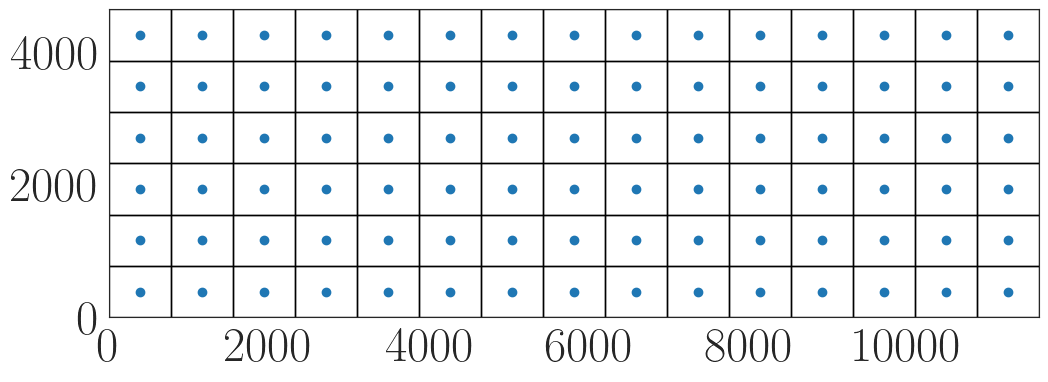

In [9]:
x = poss[:,0]
y = poss[:,1]
fig, ax = plt.subplots(figsize=(12,4))
ax.scatter(x,y)

for i,j in poss:
        ax.add_patch(Rectangle((i-l/2, j-l/2), l,l, fill = False,
                              edgecolor='black', lw=1))

ax.set_xlim(0,11604)
ax.set_ylim(0,4640)

In [10]:
coords  = np.array(wcs_n.pixel_to_world_values(poss)).astype(np.float64)

NameError: name 'wcs_n' is not defined

In [ ]:
coords_cen  = np.array(wcs_n.pixel_to_world_values([[0,7*20/ps]]))

In [ ]:
ra_cen, dec_cen = coords_cen[0]

In [ ]:
360 - 309.41851

In [ ]:
fig, ax = plt.subplots(figsize=(12,4))
angle =  245.00492
x = coords[:,0]
y = coords[:,1]
ax.scatter(x,y)

regions = {}
for n,coord in enumerate(coords):
    i = coord[0]
    j = coord[1]
    regions[f'reg_{n}'] = {}
    regions[f'reg_{n}']['ra'] = i
    regions[f'reg_{n}']['dec'] = j
    print(f"""box({np.round(i,9)}, {np.round(j,9)}, {l*ps}", {l*ps}",{angle}) # text=""" + '{' + f'Reg {n}' + '}')


ra_t = regions['reg_0']['ra']
dec_t = regions['reg_0']['dec']

ax.scatter([ra_t], [dec_t], marker='x', color='black')
ax.invert_xaxis()
ax.axis('equal')

In [11]:
with open('regions90_m83.json', 'w') as convert_file: 
     convert_file.write(json.dumps(regions))

NameError: name 'regions' is not defined

# **Photometric Analysis**

In [7]:
Av_dict = { 
            'f275w': 2.02499,
            'f336w': 1.67536,
            'f435w': 1.33879,
            'f555w': 1.03065,
            'f814w': 0.59696,
    
            'f090w': 0.583,
            'f115w': 0.419,
            'f150w': 0.287,
            'f200w': 0.195,
    
            'f438w': 1.34148,
            'f606w': 0.90941,
            'f814w': 0.59845
          }

In [8]:
regions_dict = {'bubble' : {'ra'   : 24.1858128,  
                       'dec'  : 15.7725802,
                       'F115W': 25.4, 
                       'F150W': 24.63,
                       'F200W': 23.53,
                      
                       'F435W': 27.88, 
                       'F555W': 27.48,
                       'F814W': 26.52},
           
           'bkg1'   : {'ra'   : 24.1918038,
                       'dec'  : 15.7600032,
                       'F115W': 26., 
                       'F150W': 25.26,
                       'F200W': 24.21,
                      
                      'F435W': 28.26, 
                       'F555W': 27.94,
                       'F814W': 27.05},
              
           'bkg2'   : {'ra'   : 24.1787197,
                       'dec'  : 15.7543227,
                       'F115W': 26.31, 
                       'F150W': 25.39,
                       'F200W': 24.39,
                      
                      'F435W': 28.26, 
                       'F555W': 27.94,
                       'F814W': 27.05},
              
           'bkg3'   : {'ra'   : 24.1728133,
                       'dec'  : 15.7669357,
                       'F115W': 25.42, 
                       'F150W': 24.55,
                       'F200W': 23.56,
                      
                      'F435W': 27.88, 
                       'F555W': 27.48,
                       'F814W': 26.52},
                
            'ngc628' : {'ra'   : 24.1738983, 
                       'dec'  : 15.7836543,
                       'F115W': 25.42, 
                       'F150W': 24.55,
                       'F200W': 23.56},
            'm83' :   {'ra'   : 204.2536827 ,  
                       'dec'  : -29.8655432,
                       'F115W': 25.42, 
                       'F150W': 24.55,
                       'F200W': 23.56},
                
            'm51' :  {'ra'   : 202.4696435,
                       'dec'  : 47.1952141,
                       'F115W': 25.42, 
                       'F150W': 24.55,
                       'F200W': 23.56},   
                
            'm81-gc' :  {'ra':  149.47781,
                           'dec': 68.816955,
                          },
            
            'bubble_outer': {'ra':24.1560650 ,
                            'dec': 15.8189300,
                            'radius': 16.187}}
                             
            
with open('regions90_ngc628.json') as json_file:
    data = json.load(json_file)
    
regions_dict.update(data)

with open('../data/DS9 regions/bubbles.reg') as f:
    dat = f.readlines()
    
bubbles = {}
for n,i in enumerate(dat[3:]):
    ra = float(i.split(',')[0][7:])
    dec = float(i.split(',')[1])
    radius = float(i.split(',')[2].split('"')[0])
    bubbles[f'bubble_{n}'] = {'ra' : ra,
                              'dec': dec,
                              'radius': radius}
regions_dict.update(bubbles) ;

with open('../data/DS9 regions/24_arcsec_regions_m83.reg') as f:
    dat = f.readlines()
    
bubbles = {}
for n,i in enumerate(dat[3:]):
    ra = float(i.split(',')[0][4:])
    dec = float(i.split(',')[1])
    radius = float(i.split(',')[2].split('"')[0])
    bubbles[f'm83_{n}'] = {'ra' : ra,
                              'dec': dec,
                              'radius': radius}
regions_dict.update(bubbles) ;

In [9]:
ra,dec,radius

(204.208197863, -29.892344514, 24.0)

## **JWST**

In [10]:
df_cmd_jwst = pd.read_csv("../data/isochrones_master/cmd_jwst.csv")

In [11]:
ages= np.unique(df_cmd_jwst['logAge'])
mets = np.unique(df_cmd_jwst['Zini'])

In [12]:
np.sqrt(0.02**2 + 0.02**2)

0.0282842712474619

In [159]:
mss = []
colss = []

filt1 = 'F115W'
filt2 = 'F200W'
filt3 = 'F200W'

for i in [9.6, 9.7, 9.8, 9.9, 10,10.1139]:
    df = df_cmd_jwst[np.round(df_cmd_jwst['logAge'],4)==i]
    df = df[df['label']<=3]
    ms = []
    cols = []
    for j in [0.001 , 0.002 , 0.003 , 0.004 , 0.006]:
        df_ = df[df['Zini']==j]
        df_ = df_[df_['logL']==df_['logL'].max()]
        m = df_[f'{filt3}mag'].values[0]
        col = (df_[f'{filt1}mag'] - df_[f'{filt2}mag']).values[0]
        ms.append(m)
        cols.append(col)
    mss.append(ms)
    colss.append(cols)
m = np.array(mss)
col = np.array(colss)

m_parsec = m
col_parsec = col

In [160]:
x__ = np.array([1.4964601769911505, 1.649557522123894])
y__ = np.array([ 19.174193548387098, 18.98494623655914]) -25

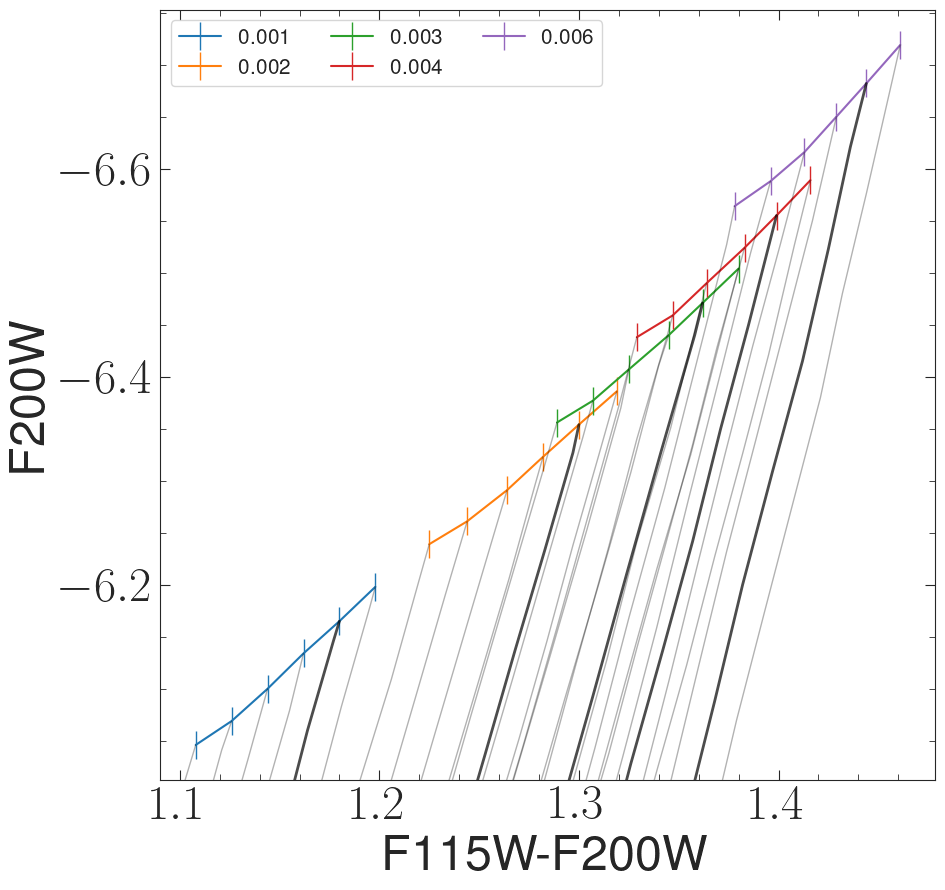

In [163]:
fig, ax = plt.subplots(figsize=(10,10))

ax.plot(col_parsec,m_parsec, '-|', markersize=20)

ax.xaxis.set_major_locator(AutoLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())

ax.yaxis.set_major_locator(AutoLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', length=7,direction="in", bottom=True, top=True,left=True, right=True)
ax.tick_params(which='minor', length=4)
ax.invert_yaxis()

ax.legend([0.001 , 0.002 , 0.003 , 0.004 , 0.006],
         ncols=3, fontsize=15)
ax.set_xlabel(f'{filt1}-{filt2}')
ax.set_ylabel(f'{filt3}')

Av_ = 0.3
Av_x = 1
Av_y = -6.5

AF1_ =  Av_dict[f'{filt1.lower()}']*Av_
AF2_ =  Av_dict[f'{filt2.lower()}']*Av_
AF3_ =  Av_dict[f'{filt3.lower()}']*Av_

dx = AF1_ - AF2_
dy = AF3_

ax.annotate('', xy=(Av_x, Av_y),
             xycoords='data',
             xytext=(Av_x+dx, Av_y+dy),
             textcoords='data',
             arrowprops=dict(arrowstyle= '<|-',
                             color='black',
                             lw=2,
                             ls='-')
           )

ax.annotate(f'Av = {Av_}', xy=(Av_x-0.01, Av_y-0.01),fontsize=20)

ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1])
ax.set_xlim(ax.get_xlim()[0], ax.get_xlim()[1])


for i in [9.6,9.7,9.8,9.9, 10, 10.1139]:
    df = df_cmd_jwst[np.round(df_cmd_jwst['logAge'],4)==i]
    df = df[df['label']==3]
    for j in np.array([0.001 , 0.002 , 0.003 , 0.004 , 0.006]):
        df_ = df[df['Zini']==j]
        x = df_[f'{filt1}mag'] - df_[f'{filt2}mag']
        y = df_[f'{filt3}mag']

        mask = (y.values[1:]- y.values[:-1])<1
        mask = np.array([True] + list(mask))
        mask = np.where(~mask, np.nan, 1)

        if i ==10:
            lw = 2
            alpha=0.7
        else:
            lw =1
            alpha=0.3
        ax.plot(x,y*mask, color='black',alpha=alpha,lw=lw) 
        

In [162]:
df_cmd_jwst_basti = pd.read_csv('../data/isochrones_master/cmd_jwst_basti_v2.csv')

In [17]:
np.unique(np.round(df_cmd_jwst_basti['logAge'],1))

array([ 9.6,  9.7,  9.8,  9.9, 10. , 10.1])

In [18]:
mss = []
colss = []

filt1 = 'F115W'
filt2 = 'F200W'
filt3 = 'F200W'

for i in [9.6,9.8,10,10.1]:
    df = df_cmd_jwst_basti[np.round(df_cmd_jwst_basti['logAge'],1)==i]
    ms = []
    cols = []
    for j in np.unique(df_cmd_jwst_basti['Zini']):
        df_ = df[df['Zini']==j]
        df_ = df_[df_['log(L/Lo)']==df_['log(L/Lo)'].max()]
        m = df_[f'{filt3}'].values[0]
        col = (df_[f'{filt1}'] - df_[f'{filt2}']).values[0]
        ms.append(m)
        cols.append(col)
    mss.append(ms)
    colss.append(cols)
m = np.array(mss)
col = np.array(colss)

m_basti = m
col_basti = col

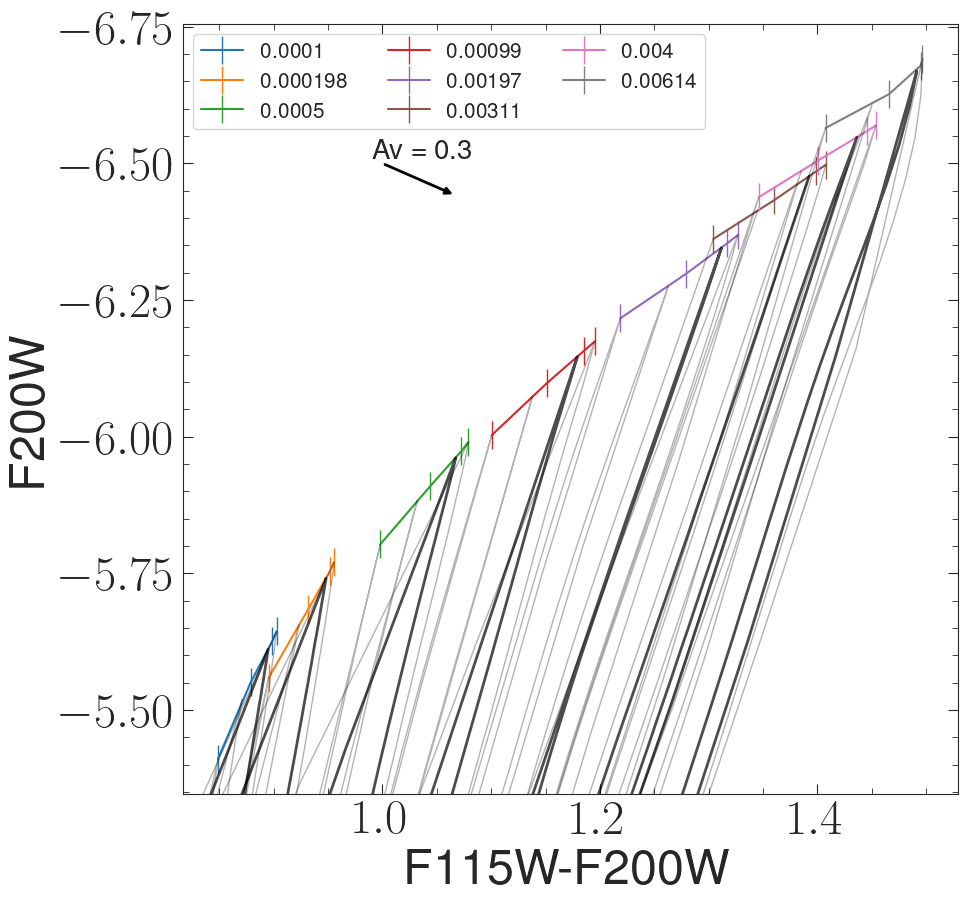

In [19]:
fig, ax = plt.subplots(figsize=(10,10))

ax.plot(col_basti,m_basti, '-|', markersize=20)

ax.xaxis.set_major_locator(AutoLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())

ax.yaxis.set_major_locator(AutoLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', length=7,direction="in", bottom=True, top=True,left=True, right=True)
ax.tick_params(which='minor', length=4)
ax.invert_yaxis()

ax.legend(np.unique(df_cmd_jwst_basti['Zini']),
         ncols=3, fontsize=15)
ax.set_xlabel(f'{filt1}-{filt2}')
ax.set_ylabel(f'{filt3}')

Av_ = 0.3
Av_x = 1
Av_y = -6.5

AF1_ =  Av_dict[f'{filt1.lower()}']*Av_
AF2_ =  Av_dict[f'{filt2.lower()}']*Av_
AF3_ =  Av_dict[f'{filt3.lower()}']*Av_

dx = AF1_ - AF2_
dy = AF3_

ax.annotate('', xy=(Av_x, Av_y),
             xycoords='data',
             xytext=(Av_x+dx, Av_y+dy),
             textcoords='data',
             arrowprops=dict(arrowstyle= '<|-',
                             color='black',
                             lw=2,
                             ls='-')
           )

ax.annotate(f'Av = {Av_}', xy=(Av_x-0.01, Av_y-0.01),fontsize=20)

ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1])
ax.set_xlim(ax.get_xlim()[0], ax.get_xlim()[1])


for i in [9.6, 9.78,10, 10.11]:
    df = df_cmd_jwst_basti[np.round(df_cmd_jwst_basti['logAge'],2)==i]
    for j in np.unique(df['Zini']):
        df_ = df[df['Zini']==j]
        x = df_[f'{filt1}'] - df_[f'{filt2}']
        y = df_[f'{filt3}']

        mask = (y.values[1:]- y.values[:-1])<1
        mask = np.array([True] + list(mask))
        mask = np.where(~mask, np.nan, 1)

        if i ==10:
            lw = 2
            alpha=0.7
        else:
            lw =1
            alpha=0.3
        ax.plot(x,y*mask, color='black',alpha=alpha,lw=lw) 
        

In [20]:
np.unique(np.round(df_cmd_jwst_basti['logAge'],2))

array([ 9.6 ,  9.7 ,  9.78,  9.85,  9.9 ,  9.95, 10.  , 10.04, 10.08,
       10.11])

### **CMD**

Label: 0=PMS, 1=MS, 2=SGB, 3=RGB, (4,5,6)=different stages of CHEB, 7=EAGB, 8=TPAGB, 9=post-AGB

In [ ]:
ages_ = [6.8,7,7.2, 7.5,7.8,8,8.2,8.5,8.8,9,9.6,10]

ages_y = [6.8, 7.0,7.3,7.6,7.8,8,8.5,8.8]
ages_o = [9.0, 9.6,10]

mag_err_lim = 0.2

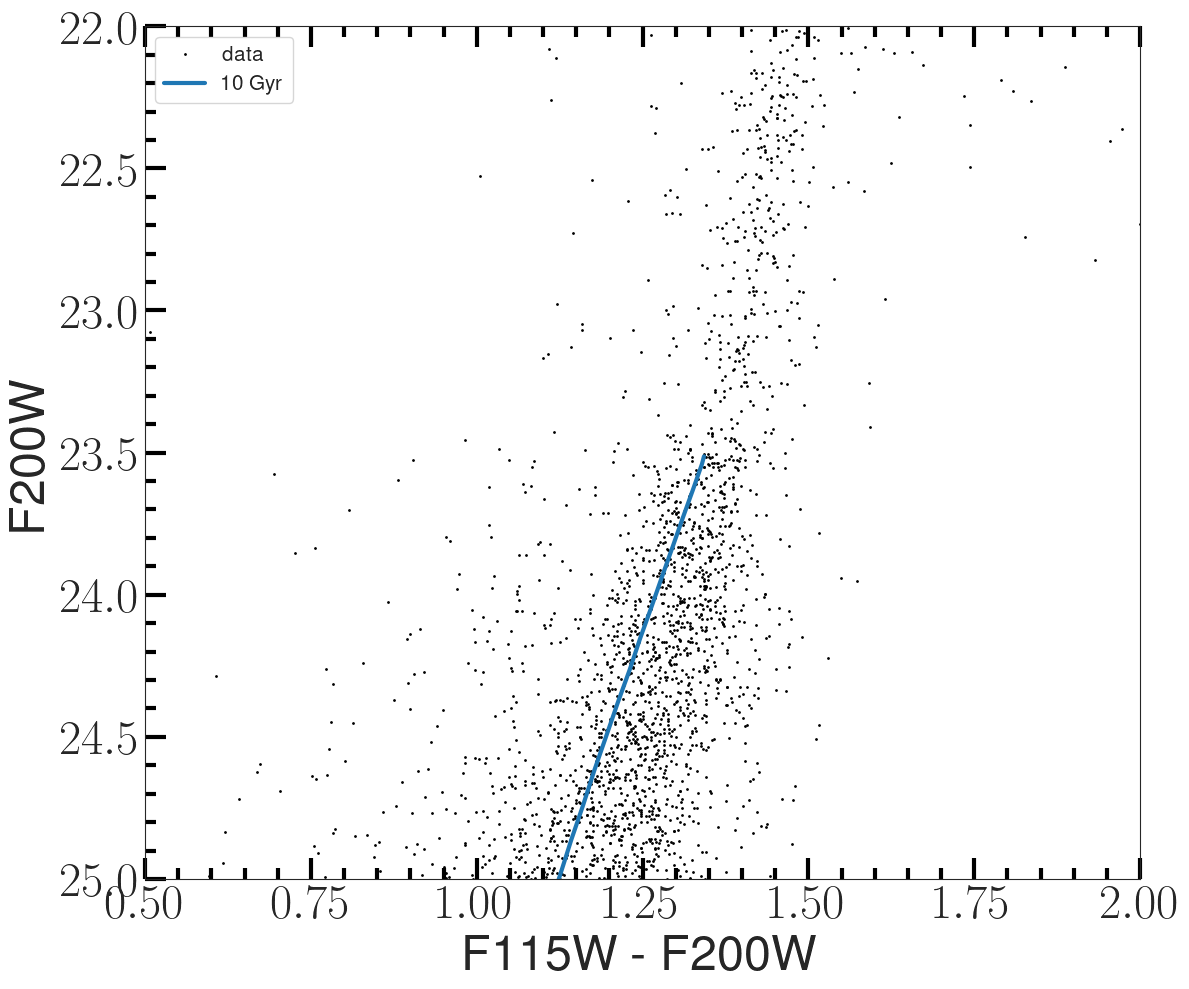

In [23]:
tab = Table.read('../photometry/ngc628/f115w_f200w_photometry.fits')


ra_cen = regions_dict['reg_10']['ra']
dec_cen = regions_dict['reg_10']['dec']

filters = {'filt1':'f115w',
           'filt2':'f200w',
           'filt3':'f200w'}

positions = {'ra_col': 'ra',
             'dec_col' : 'dec',
             'ra_cen': ra_cen,
             'dec_cen': dec_cen}

region = {'width_in':0,
          'height_in':0,
          'width_out':24,
          'height_out':24,
          'ang': 257,
          'spatial_filter': 'circle'}
       
extinction = {'Av': 0.19,
              'Av_x': 2,
              'Av_y': 26,
              'Av_': 1}

axis_limits= {'xlims': [0.5, 2], 
              'ylims': [22, 25]}

isochrone_params={'met': [0.002],
                  'label_max': 3,
                  'ages': [10]}

error_settings = {'ref_xpos': -0.25,
                  'mag_err_lim':0.2}

plot_settings = {'s':1, 'legend.ncols':1}

fig,ax, tab1 = gen_CMD(tab, 
                      df_cmd_jwst,
                      filters, 
                      positions,
                      region,
                      extinction,
                      29.83,
                      axis_limits,
                      isochrone_params,
                      plot_settings=plot_settings,
                      error_settings=error_settings,
                      other_settings={'ab_dist': False, 'skip_data': False})

In [ ]:
x= tab1['ra']
y = tab1['dec']
c = tab1['mag_vega_F200W']
plt.figure(figsize=(10,10))
plt.scatter(x,y, c=c, s=1, cmap='jet')
plt.axis('equal')

In [ ]:
r_in = 0
r_out = 24


tab = Table.read('../photometry/ngc628/f115w_f200w_photometry.fits')


ra_cen = regions_dict['reg_7']['ra']
dec_cen = regions_dict['reg_7']['dec']

fig,_, tab1 = gen_CMD(tab,'f115w', 'f200w', 'f200w', ra_cen=ra_cen, dec_cen=dec_cen,
                       ra_col = 'ra', dec_col ='dec',
                       cmd=None, Av_=1, Av_x=2.5, Av_y=26, 
                       xlims=[-0.5,4], ylims=[19,27.5],
                       gen_kde=False, gen_contours=False, met=0.002,dismod=29.7126, ages=[10],
                       r_in=r_in, r_out=r_out, sqr_field=True)


In [ ]:
tab = Table.read('../photometry/ngc628/f115w_f150w_f200w_photometry.fits')
df_cmd_jwst = pd.read_csv("../data/isochrones_master/cmd_jwst.csv")
df = tab[(tab['mag_err_F115W']<=0.2) & (tab['mag_err_F150W']<=0.2) & (tab['mag_err_F200W']<=0.2)] 

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))

x = df['mag_vega_F115W']
y = df['mag_err_F115W']

init = models.Exponential1D()
fit = fitting.LevMarLSQFitter()
model_f115w = fit(init,x,y)

ax.scatter(x,y,s=0.01,color='blue', label='F115W')
ax.axvline([24.49524254],ls='--', color='blue')
ax.axvline([27.27155834],ls='-', color='blue')

x = df['mag_vega_F150W']
y = df['mag_err_F150W']

model_f150w = fit(init,x,y)
ax.scatter(x,y,s=0.01,color='green')
ax.axvline([23.5535029],ls='--', color='green')
ax.axvline([25.71734278],ls='-', color='green')

x = df['mag_vega_F200W']
y = df['mag_err_F200W']

model_f200w = fit(init,x,y)

x_ = np.linspace(x.min(), x.max())
y_ = model_f200w(x_)
#ax.plot(x_,y_,'--k')

ax.scatter(x,y,s=0.001,color='red', label='F200W')
ax.axvline([22.7474432],ls='--', color='red')
ax.axvline([25.9781503],ls='-', color='red')


ax.xaxis.set_major_locator(AutoLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())

ax.yaxis.set_major_locator(AutoLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', length=15,direction="in", bottom=True, top=True,left=True, right=True,width=3)
ax.tick_params(which='minor', length=8,width=3)

ax.set_xlabel('mag')
ax.set_ylabel('mag_err')

In [ ]:
y = np.sqrt(df['mag_err_F115W']**2 + df['mag_err_F200W']**2)
x = df['mag_vega_F200W']

plt.scatter(x,y,s= 1)

model_f115w_f200W = fit(init,x,y)

In [ ]:
tab = Table.read('../photometry/ngc628/f115w_f200w_photometry.fits')


ra_cen = regions_dict['reg_10']['ra']
dec_cen = regions_dict['reg_10']['dec']

filters = {'filt1':'f115w',
           'filt2':'f200w',
           'filt3':'f200w'}

positions = {'ra_col': 'ra',
             'dec_col' : 'dec',
             'ra_cen': ra_cen,
             'dec_cen': dec_cen}

region = {'width_in': 0,
          'width_out': 24,
          'height_in': 0,
          'height_out': 24,
          'ang' : 245.00492,
          'spatial_filter': 'box'}
       
extinction = {'Av': 0.19,
              'Av_x': 3,
              'Av_y': 21,
              'Av_': 3}

axis_limits= {'xlims': [1.,1.6], 
              'ylims': [22.5, 24.5]}

isochrone_params={'met': [0.02],
                  'label_min': None,
                  'label_max': None, 
                  'ages': [7.0, 8.0, 9.0]}

error_settings = {'ref_xpos': 1.25,
                  'mag_err_lim':0.2}

kde_contours = {'gen_kde':False,
                'gen_contours':False}

fig,ax, tab1 = gen_CMD(tab, 
                      df_cmd_jwst,
                      filters, 
                      positions,
                      region,
                      extinction,
                      29.83,
                      axis_limits,
                      isochrone_params,
                      kde_contours=kde_contours,
                      error_settings=error_settings,
                      other_settings={'ab_dist':False},
                      plot_settings={'s':5})


In [ ]:
r_in  = 0
r_out = 24

tab = Table.read('../photometry/ngc628/f115w_f200w_photometry.fits')

fig, ax = plt.subplots(6,15,figsize=(120,50), sharex=True, sharey=True)

k = 0
for i in range(15):
    for j in range(6):

        ra_cen  = regions_dict[f'reg_{k}']['ra']
        dec_cen = regions_dict[f'reg_{k}']['dec']

        fig, ax1, _ = gen_CMD(tab,'f115w', 'f200w', 'f200w',ra_col = 'ra', dec_col ='dec',
                              ra_cen=ra_cen, dec_cen=dec_cen,
                              cmd=df_cmd_jwst, Av_=1, Av_x=2.5, Av_y=26, sqr_field=True,
                              xlims=[-0.5,3], ylims=[21,27.5], lw=1, gen_kde=False, 
                              met=0.002,dismod=29.7416, ages=[10], r_in=r_in, r_out=r_out,
                              fig=fig, ax=ax[5-j,i])
        ax1.set_title(f'reg_{k}')
        
        if j!=0:
            ax1.set_xlabel(None)
        if i!=0:
            ax1.set_ylabel(None)
        k+=1

plt.subplots_adjust(hspace=0.1, wspace=0.6) 

In [ ]:
df = df_cmd_jwst[df_cmd_jwst['logAge']==6.7]
x = df['F115Wmag'] - df['F200Wmag']
y = df['F200Wmag']

fig, ax = plt.subplots()

img = ax.scatter(x,y,c=df['label'],s=1, cmap='Set1')
ax.invert_yaxis()

plt.colorbar(img,ax=ax)

In [ ]:
tab = Table.read('../photometry/ngc628/f115w_f200w_photometry.fits')

filters = {'filt1':'f115w',
           'filt2':'f200w',
           'filt3':'f200w'}

ra_cen = regions_dict['ngc628']['ra']
dec_cen = regions_dict['ngc628']['dec']

positions = {'ra_col': 'ra',
             'dec_col' : 'dec',
             'ra_cen': ra_cen,
             'dec_cen': dec_cen}

region = {'r_in' : 0,
          'r_out' : 2000,
          'spatial_filter': 'circle'}
       
extinction = {'Av': 0.19,
              'Av_x': 3,
              'Av_y': 26,
              'Av_': 3}

axis_limits= {'xlims': [-1, 5], 
              'ylims': [17.5, 28]}

isochrone_params={'met': [0.02],
                  'label_min':1,
                  'label_max':10,
                  'ages': [ 6.8,7,7.5, 8,8.5, 9]}

error_settings = {'ref_xpos': -0.25,
                  'mag_err_lim':0.2}

kde_contours = {'gen_kde':False,
                'gen_contours':False}


fig,ax, tab1 = gen_CMD(tab, 
                      df_cmd_jwst,
                      filters, 
                      positions,
                      region,
                      extinction,
                      29.83,
                      axis_limits,
                      isochrone_params,
                      kde_contours=kde_contours,
                      error_settings=error_settings,
                      other_settings = {'ab_dist':False})

isochrone_params['met'] = [0.002]
isochrone_params['ages'] = [9.1,10]

fig,ax, tab1 = gen_CMD(tab, 
                      df_cmd_jwst,
                      filters, 
                      positions,
                      region,
                      extinction,
                      29.83,
                      axis_limits,
                      isochrone_params,
                      kde_contours=kde_contours,
                      error_settings=error_settings,
                      other_settings={'ab_dist':True, 'skip_data':True},
                      fig=fig,
                      ax=ax)

### **Crowding**

In [21]:
ms_f115w_mc = []
ms_f200w_mc = []
ms_f115w_f200w_mc = []

hdu = fits.open(f"../photometry/ngc628/completeness/F200W_i2d.fits")[1]
wcs = WCS(hdu.header)

for i in range(100):
    fs = glob.glob(f'../photometry/ngc628/crowding_old/fake_out__{i}_25_23.5_f115w_f200w_??_filt.fits')
    t = []
    for f in fs:
        tab = Table.read(f)

        positions = np.transpose([tab['x'] - 0.5, tab['y']-0.5])
        coords = np.array(wcs.pixel_to_world_values(positions))

        tab['ra']  = coords[:,0]
        tab['dec'] = coords[:,1]
        t.append(tab)
    tab_c = vstack(t)
    ms_f115w = []
    ms_f200w = []
    ms_f115w_f200w = []

    ra = regions_dict[f'bubble']['ra']
    dec = regions_dict[f'bubble']['dec']
    tab_c['r'] = angular_separation(
        tab_c['ra'] * u.deg,
        tab_c['dec'] * u.deg,
        ra * u.deg,
        dec*u.deg).to(u.arcsec).value
    tab = tab_c[tab_c['r']<=8.9]
    ms_f115w.append(np.median(tab['mag_vega_F115W']))
    ms_f200w.append(np.median(tab['mag_vega_F200W']))
    ms_f115w_f200w.append(np.median(tab['mag_vega_F115W'] - tab['mag_vega_F200W']))
    
    ms_f115w_mc.append(ms_f115w)
    ms_f200w_mc.append(ms_f200w)
    ms_f115w_f200w_mc.append(ms_f115w_f200w)
    
ms_f115w = np.array(ms_f115w_mc)
ms_f200w = np.array(ms_f200w_mc)
ms_f115w_f200w = np.array(ms_f115w_f200w_mc)

f115w = np.median(ms_f115w,axis=0)

err = 25 - np.percentile(ms_f115w, [16,84], axis=0) 

f115w_err_p = abs(err[1])
f115w_err_m = abs(err[0])

f200w = np.median(ms_f200w,axis=0)

err = 23.5 - np.percentile(ms_f200w, [16,84],axis=0)
f200w_err_p = abs(err[1])
f200w_err_m = abs(err[0])

f115w_f200w = np.median(ms_f115w_f200w,axis=0)

err = 1.5 - np.percentile(ms_f115w_f200w, [16,84],axis=0)
f115w_f200w_err_p = abs(err[1])
f115w_f200w_err_m = abs(err[0]) 

model_f115w_crowd = 25 - f115w

f115w_err_p = abs(f115w_err_p-model_f115w_crowd)
f115w_err_m = abs(f115w_err_m-model_f115w_crowd)

model_f200w_crowd = 23.5 - f200w
f200w_err_p = abs(f200w_err_p-model_f200w_crowd)
f200w_err_m = abs(f200w_err_m-model_f200w_crowd)

model_f115w_f200w_crowd = 1.5 - f115w_f200w
f115w_f200w_err_p = abs(f115w_f200w_err_p-model_f115w_f200w_crowd)
f115w_f200w_err_m = abs(f115w_f200w_err_m-model_f115w_f200w_crowd)

In [22]:
bubble_f200w_crowd = model_f200w_crowd[0]
bubble_f200w_crowd_err_m = f200w_err_m[0]
bubble_f200w_crowd_err_p = f200w_err_p[0]

bubble_col_crowd = model_f115w_f200w_crowd[0]
bubble_col_crowd_err_m = f115w_f200w_err_m[0]
bubble_col_crowd_err_p = f115w_f200w_err_p[0]

In [23]:
np.round(bubble_f200w_crowd,3), np.round(bubble_f200w_crowd_err_m,3), np.round(bubble_f200w_crowd_err_p,3),

(0.046, 0.017, 0.014)

In [24]:
np.round(bubble_col_crowd,3), np.round(bubble_col_crowd_err_m,3), np.round(bubble_col_crowd_err_p,3)

(0.011, 0.009, 0.008)

In [25]:
0.052, 0.016, 0.023, 0.01, 0.008, 0.007

(0.052, 0.016, 0.023, 0.01, 0.008, 0.007)

In [ ]:
ms_f115w_mc = []
ms_f200w_mc = []
ms_f115w_f200w_mc = []

hdu = fits.open(f"../photometry/ngc628/completeness/F200W_i2d.fits")[1]
wcs = WCS(hdu.header)

for i in range(100):
    fs = glob.glob(f'../photometry/ngc628/crowding_old/fake_out__{i}_25_23.5_f115w_f200w_??_filt.fits')
    t = []
    for f in fs:
        tab = Table.read(f)

        positions = np.transpose([tab['x'] - 0.5, tab['y']-0.5])
        coords = np.array(wcs.pixel_to_world_values(positions))

        tab['ra']  = coords[:,0]
        tab['dec'] = coords[:,1]
        t.append(tab)
    tab_c = vstack(t)
    ms_f115w = []
    ms_f200w = []
    ms_f115w_f200w = []
    for i in range(90):
        ra = regions_dict[f'reg_{i}']['ra']
        dec = regions_dict[f'reg_{i}']['dec']
        tab = box(tab_c,'ra','dec',ra,dec,0,0,24/3600,24/3600)
        ms_f115w.append(np.median(tab['mag_vega_F115W']))
        ms_f200w.append(np.median(tab['mag_vega_F200W']))
        ms_f115w_f200w.append(np.median(tab['mag_vega_F115W'] - tab['mag_vega_F200W']))
    
    ms_f115w_mc.append(ms_f115w)
    ms_f200w_mc.append(ms_f200w)
    ms_f115w_f200w_mc.append(ms_f115w_f200w)
    
ms_f115w = np.array(ms_f115w_mc)
ms_f200w = np.array(ms_f200w_mc)
ms_f115w_f200w = np.array(ms_f115w_f200w_mc)

f115w = np.median(ms_f115w,axis=0)

err = 25 - np.percentile(ms_f115w, [16,84], axis=0) 

f115w_err_p = abs(err[1])
f115w_err_m = abs(err[0])

f200w = np.median(ms_f200w,axis=0)

err = 23.5 - np.percentile(ms_f200w, [16,84],axis=0)
f200w_err_p = abs(err[1])
f200w_err_m = abs(err[0])

f115w_f200w = np.median(ms_f115w_f200w,axis=0)

err = 1.5 - np.percentile(ms_f115w_f200w, [16,84],axis=0)
f115w_f200w_err_p = abs(err[1])
f115w_f200w_err_m = abs(err[0]) 

model_f115w_crowd = 25 - f115w

f115w_err_p = abs(f115w_err_p-model_f115w_crowd)
f115w_err_m = abs(f115w_err_m-model_f115w_crowd)

model_f200w_crowd = 23.5 - f200w
f200w_err_p = abs(f200w_err_p-model_f200w_crowd)
f200w_err_m = abs(f200w_err_m-model_f200w_crowd)

model_f115w_f200w_crowd = 1.5 - f115w_f200w
f115w_f200w_err_p = abs(f115w_f200w_err_p-model_f115w_f200w_crowd)
f115w_f200w_err_m = abs(f115w_f200w_err_m-model_f115w_f200w_crowd)

In [27]:
model_f200w_crowd[0], f200w_err_p[0], f200w_err_m[0]

(0.009750000000003922, 0.0027500000000024727, 0.0022499999999965326)

In [28]:
model_f115w_crowd[0], f115w_err_p[0], f115w_err_m[0]

(0.013999999999999346, 0.003999999999997783, 0.0030000000000001137)

In [29]:
model_f115w_f200w_crowd[0], f115w_f200w_err_p[0], f115w_f200w_err_m[0]

(0.004999999999999005, 0.003999999999998449, 0.0035800000000008048)

In [30]:
x, y = np.mgrid[0:15,0:6]/1.0
x -= 7
y-= 2.5
x *= 24
y *= 24

r = np.sqrt(x**2 + y**2).ravel()

ind = np.argsort(r)

init = models.Polynomial1D(4)
fit = fitting.LevMarLSQFitter()
r_model_f200w_crowd = fit(init,r[ind],model_f200w_crowd[ind])
r_model_f200w_err_p = fit(init,r[ind],f200w_err_p[ind])
r_model_f200w_err_m = fit(init,r[ind],f200w_err_m[ind])

r_model_f115w_crowd = fit(init,r[ind],model_f115w_crowd[ind])
r_model_f115w_err_p = fit(init,r[ind],f115w_err_p[ind])
r_model_f115w_err_m = fit(init,r[ind],f115w_err_m[ind])

r_model_f115w_f200w_crowd = fit(init,r[ind],model_f115w_f200w_crowd[ind])
r_model_f115w_f200w_err_p = fit(init,r[ind],f115w_f200w_err_p[ind])
r_model_f115w_f200w_err_m = fit(init,r[ind],f115w_f200w_err_m[ind])

In [31]:
model_f200w_crowd.shape

(90,)

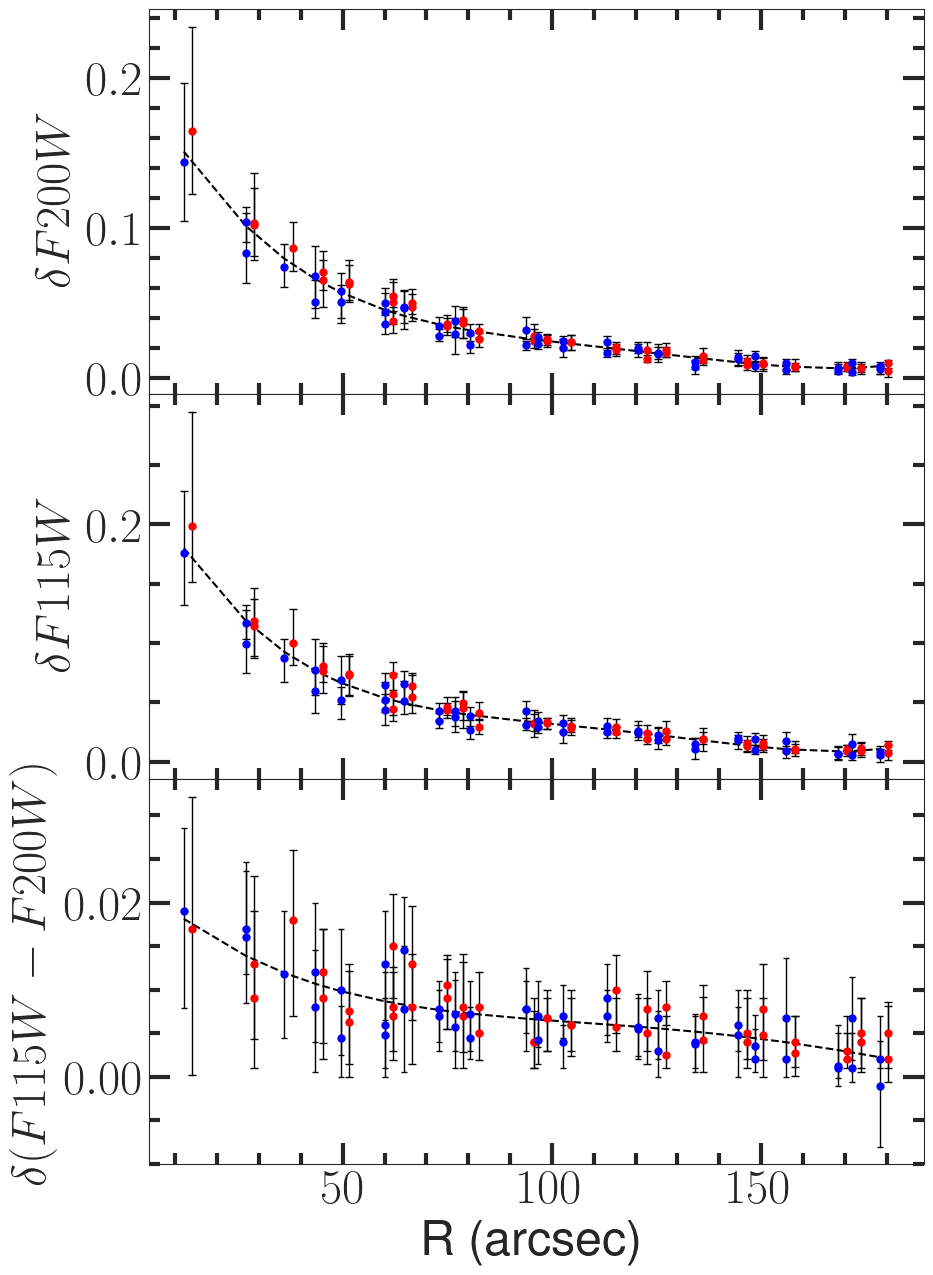

In [32]:
fig, axs = plt.subplots(3,1,figsize=(10,15),sharex=True)
ax = axs[0]
ax.errorbar(r[:45]+2,model_f200w_crowd[:45],yerr=[f200w_err_p[:45],f200w_err_m[:45]],
             label='F200W', marker='o', capsize=3,ls='none',markersize=5,  markeredgecolor='red',
             markerfacecolor='red',ecolor='black',elinewidth=1)

ax.errorbar(r[45:],model_f200w_crowd[45:],yerr=[f200w_err_p[45:],f200w_err_m[45:]],
             label='F200W', marker='o',capsize=3,ls='none',markersize=5,  markeredgecolor='blue',
             markerfacecolor='blue',ecolor='black',elinewidth=1)

ax.plot(r[ind], r_model_f200w_crowd(r[ind]),'--', color='black')
#ax.set_xlabel('R (arcsec)')
ax.set_ylabel(r'$\delta F200W$')

ax.xaxis.set_major_locator(AutoLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())

ax.yaxis.set_major_locator(AutoLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', length=15,direction="in", bottom=True, top=True,left=True, right=True,width=3)
ax.tick_params(which='minor', length=8,width=3)

ax = axs[1]
ax.errorbar(r[:45]+2,model_f115w_crowd[:45],yerr=[f115w_err_p[:45],f115w_err_m[:45]],
             label='F115W', marker='o',capsize=3,ls='none',markersize=5,  markeredgecolor='red',
             markerfacecolor='red',ecolor='black',elinewidth=1)

ax.errorbar(r[45:],model_f115w_crowd[45:],yerr=[f115w_err_p[45:],f115w_err_m[45:]],
             label='F115W', marker='o', capsize=3,ls='none',markersize=5,  markeredgecolor='blue',
             markerfacecolor='blue',ecolor='black',elinewidth=1)

ax.plot(r[ind], r_model_f115w_crowd(r[ind]),'--', color='black')
#ax.set_xlabel('R (arcsec)')
ax.set_ylabel(r'$\delta F115W$')

ax.xaxis.set_major_locator(AutoLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())

ax.yaxis.set_major_locator(AutoLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', length=15,direction="in", bottom=True, top=True,left=True, right=True,width=3)
ax.tick_params(which='minor', length=8,width=3)

ax = axs[2]
ax.errorbar(r[:45]+2,model_f115w_f200w_crowd[:45], yerr=[f115w_f200w_err_p[:45],f115w_f200w_err_m[:45]],
            marker='o', capsize=3,ls='none',markersize=5,  markeredgecolor='red',
             markerfacecolor='red',ecolor='black',elinewidth=1)

ax.errorbar(r[45:],model_f115w_f200w_crowd[45:], yerr=[f115w_f200w_err_p[45:],f115w_f200w_err_m[45:]],
            marker='o', capsize=2,ls='none',markersize=5,  markeredgecolor='blue',
             markerfacecolor='blue',ecolor='black',elinewidth=1)

ax.plot(r[ind], r_model_f115w_f200w_crowd(r[ind]),'--', color='black')
ax.set_xlabel('R (arcsec)') 
ax.set_ylabel(r'$\delta (F115W-F200W)$')


ax.xaxis.set_major_locator(AutoLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())

ax.yaxis.set_major_locator(AutoLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', length=15,direction="in", bottom=True, top=True,left=True, right=True,width=3)
ax.tick_params(which='minor', length=8,width=3)

plt.subplots_adjust(hspace=0)

### **TRGB**

In [211]:
def parsec_model(l, col_ind=-8):
    x = col_parsec.ravel().copy()
    y = m_parsec.ravel().copy()
    ind = np.argsort(x)

    x = x[ind]
    y = y[ind]
        
    init = models.Polynomial1D(2)
    fit = fitting.LevMarLSQFitter()
    model = fit(init,x,y)
    y_piv = y[col_ind]
    
    return model(l) - y_piv

def basti_model(l, col_ind):
    x = col_basti.ravel().copy()
    y = m_basti.ravel().copy()
    ind = np.argsort(x)

    x = x[ind]
    y = y[ind]
        
    init = models.Polynomial1D(2)
    fit = fitting.LevMarLSQFitter()
    model = fit(init,x,y)
    y_piv = y[col_ind]
    
    return model(l) - y_piv

In [305]:
trgb_cols.shape

(15, 6, 9)

In [ ]:
model_mag_err_f200w = models.Exponential1D(4.62861558e-10, 1.35545518e+00)
model_col_err = models.Exponential1D(1.01336272e-08, 1.57271500e+00)

tab = Table.read('../photometry/ngc628/f115w_f200w_photometry.fits')

filt1 = 'f115w'
filt2 = 'f200w'
filt3 = 'f200w'

dy= 0.25

y_lo = 19
y_hi = 28

cmd_xlo = 1.25
y0 = 23.5

cmd_xhi = cmd_xlo + dy*1.1

col_lims = [23.20, 23.5]
ms = []
for i in range(90):
    bins = np.arange(y_lo, y_hi, b)
    #sigma_s = 0.1

    r_in  = 0
    r_out = 24
   # fig = plt.figure(figsize=(20, 9))
   # gs = fig.add_gridspec(1, 3,  width_ratios=(3, 1,1),
     #                     left=0.1, right=0.9, bottom=0.1, top=0.9,
    #                      wspace=0.05, hspace=0.05)

   # ax =  fig.add_subplot(gs[0, 0])
    
    fig, ax = plt.subplots(figsize=(10,10))
    y_lo = 19
    y_hi = 28

    k = i
    ra_cen  = regions_dict[f'reg_{i}']['ra']
    dec_cen = regions_dict[f'reg_{i}']['dec']

    y = tab['mag_vega_F200W']
    x = tab['mag_vega_F115W'] - tab['mag_vega_F200W'] - 0.19*(Av_dict['f115w'] - Av_dict['f200w'])
    tab_n = tab.copy()
    tab_n['mag_vega_F200W'] = tab['mag_vega_F200W'].value - parsec_model(x.value,-18)
    tab_n['mag_vega_F115W'] = tab['mag_vega_F115W'].value - parsec_model(x.value,-18)
    #print(parsec_model(x_piv))
    newcmp = ListedColormap(["#FFFFFF",  # Black
        "#0000FF",  # Blue
        "#00FF00",  # Green
        "#FFFF00",  # Yellow
        "#FFA500",  # Orange
        "#FF0000",  # Red
        "#800000"   # Dark Red
                            ])
    fig, ax, dats_bub, x_val, y_val, y_bins,params = gen_CMD_ycut(tab, filt1, filt2, filt3,cmd=df_cmd_jwst, 
                                                                  ra_col='ra', dec_col='dec',
                                                                  cmap=newcmp,
                                                                  ra_cen=ra_cen, dec_cen=dec_cen,
                                                                  r_in=r_in, r_out=r_out,Av = 0.19, Av_=0.5,
                                                                  met=0.002, sqr_field=True, mag_err_lim=0.2,
                                                                  age=10, gen_kde=True, Av_y = 22.85, Av_x=1.2,
                                                                  y_lo=y_lo, y_hi=y_hi, rgb_ylo=23.2, rgb_yhi=26,
                                                                  dy=dy, cmd_xlo=cmd_xlo, cmd_xhi=cmd_xhi,
                                                                  xlims=[1,1.6], ylims=[22.5,24.5], y0=y0,
                                                                  fit_isochrone=True, perp_iso=False, 
                                                                  dismod=29.81, fig=fig, ax=ax,s=10,lw=2,
                                                                  ref_xpos=1.05, ref_dy=0.25)

    #x = col_parsec[-1][3:]  + (Av_dict['f115w'] - Av_dict['f200w'])*0.19
    #y = m_parsec[-1][3:] + 29.83 + Av_dict['f200w']*0.19

    x = col_parsec.ravel().copy()
    y = m_parsec.ravel().copy()
    ind = np.argsort(x)

    x = x[ind]
    y = y[ind]
    x_piv = x[-18]
    y_piv = y[-18]

    x = np.linspace(1.2,1.4)
    y = parsec_model(x,-18) + y_piv  

    x +=  (Av_dict['f115w'] - Av_dict['f200w'])*0.19
    y +=  29.81 + 0.19*Av_dict['f200w']
    ax.plot(x,y, '--k', lw=3.5)

    m = trgb_f200w_mag.ravel()[k]
    col = trgb_cols[:,:,3].ravel()[k]

    ax.scatter(col, m, s=1000, lw=5, marker='+', color='black')
    ax.set_title(f'Region {i}')
    """
    #x = col_basti[-1][3:]  + (Av_dict['f115w'] - Av_dict['f200w'])*0.19
    #y = m_basti[-1][3:] + 29.79 + Av_dict['f200w']*0.19
    #ax.plot(x,y, '--', color='black', lw=3.5)

    ax_hist = fig.add_subplot(gs[0, 1], sharey=ax)
    ax_edge = fig.add_subplot(gs[0, 2], sharey=ax)
    


    for dat in dats_bub:
        #ms = []
        x_ = dat[0]
        y_ = dat[1]

        for _ in range(1):
            x = x_#np.random.normal(loc=x_,scale=model_col_err(y_))
            y = y_#np.random.normal(loc=y_,scale=model_mag_err_f200w(y_))

            lf_count = len(x)
            bins = np.arange(y_lo, y_hi, b)
            yh,xh,_, = ax_hist.hist(y,bins, orientation='horizontal' , histtype='step', color='grey')
            xh = 0.5*(xh[1:] + xh[:-1])

            yf = gloess(xh,yh,sigma_s,1)
            ysob = np.convolve(yf,np.array([-1,0,1]), mode='same')

            ax_hist.plot(yf, xh, color='black')
            ax_edge.plot(ysob, xh,'b',alpha=1)

            c1 = (xh>=col_lims[0]) & (xh<=col_lims[1])
            m = xh[c1][ysob[c1]==ysob[c1].min()][0]
            ms.append(m)


    ax_hist.tick_params(axis="y", labelleft=False)
    ax_edge.tick_params(axis="x", labelbottom=False)
    ax_edge.tick_params(axis="y", labelleft=False)

    ax_edge.set_title(f'{filt3.upper()}'+ '$_{TRGB}$' f': {np.round(m,5)}', fontsize=25,x=-1.5)
    #m = 23.40525000
    #ax.plot([0,3],[m,m],'--k', zorder=201)
    ax_hist.plot([0,yh.max()],[m,m],'--k',label=f'{filt3.upper()}'+ '$_{TRGB}$')
    ax_hist.legend(fontsize=15)
    ax_hist.set_xticks([np.ceil(yh.max())],[np.ceil(yh.max())])
    ax_hist.tick_params(axis='both', labelsize=0)
    dismod = m - params[0]-params[1]
    #ax_hist.set_title(f'DM : {np.round(dismod, 3)}', fontsize=25)
    ax_edge.plot([ysob.min(),ysob.max()],[m,m],'--k')
    ax_edge.set_xlim([ysob.min()*1.1,0])
    #ax_edge.invert_xaxis()

    for ax_ in [ax_hist, ax_edge]:
        ax_.xaxis.set_major_locator(AutoLocator())
        ax_.xaxis.set_minor_locator(AutoMinorLocator())


        ax_.yaxis.set_major_locator(AutoLocator())
        ax_.yaxis.set_minor_locator(AutoMinorLocator())

        ax_.tick_params(which='both', length=7,direction="in", bottom=True, top=True,left=True, right=True)
        ax_.tick_params(which='minor', length=4)
    """
    fig.savefig(f'TRGBv2/gif/reg_{k}.png', bbox_inches='tight')
    plt.close(fig)

In [310]:
from PIL import Image
import os

In [326]:
from PIL import Image
import os

# Define the directory containing PNG files
image_dir = "TRGBv2/gif/"
output_gif = "TRGBv2/output.gif"

# Get all PNG files sorted by name
images = sorted([img for img in os.listdir(image_dir) if img.endswith(".png")])

images = sorted(images,key = lambda x: float(x.split('_')[1].split('.png')[0]))
# Open images and convert them into a sequence
image_sequence = [Image.open(os.path.join(image_dir, img)) for img in images]

# Save as GIF
if image_sequence:
    image_sequence[0].save(output_gif, save_all=True, append_images=image_sequence[1:], duration=600, loop=0)
    print(f"GIF saved as {output_gif}")
else:
    print("No PNG images found!")

GIF saved as TRGBv2/output.gif


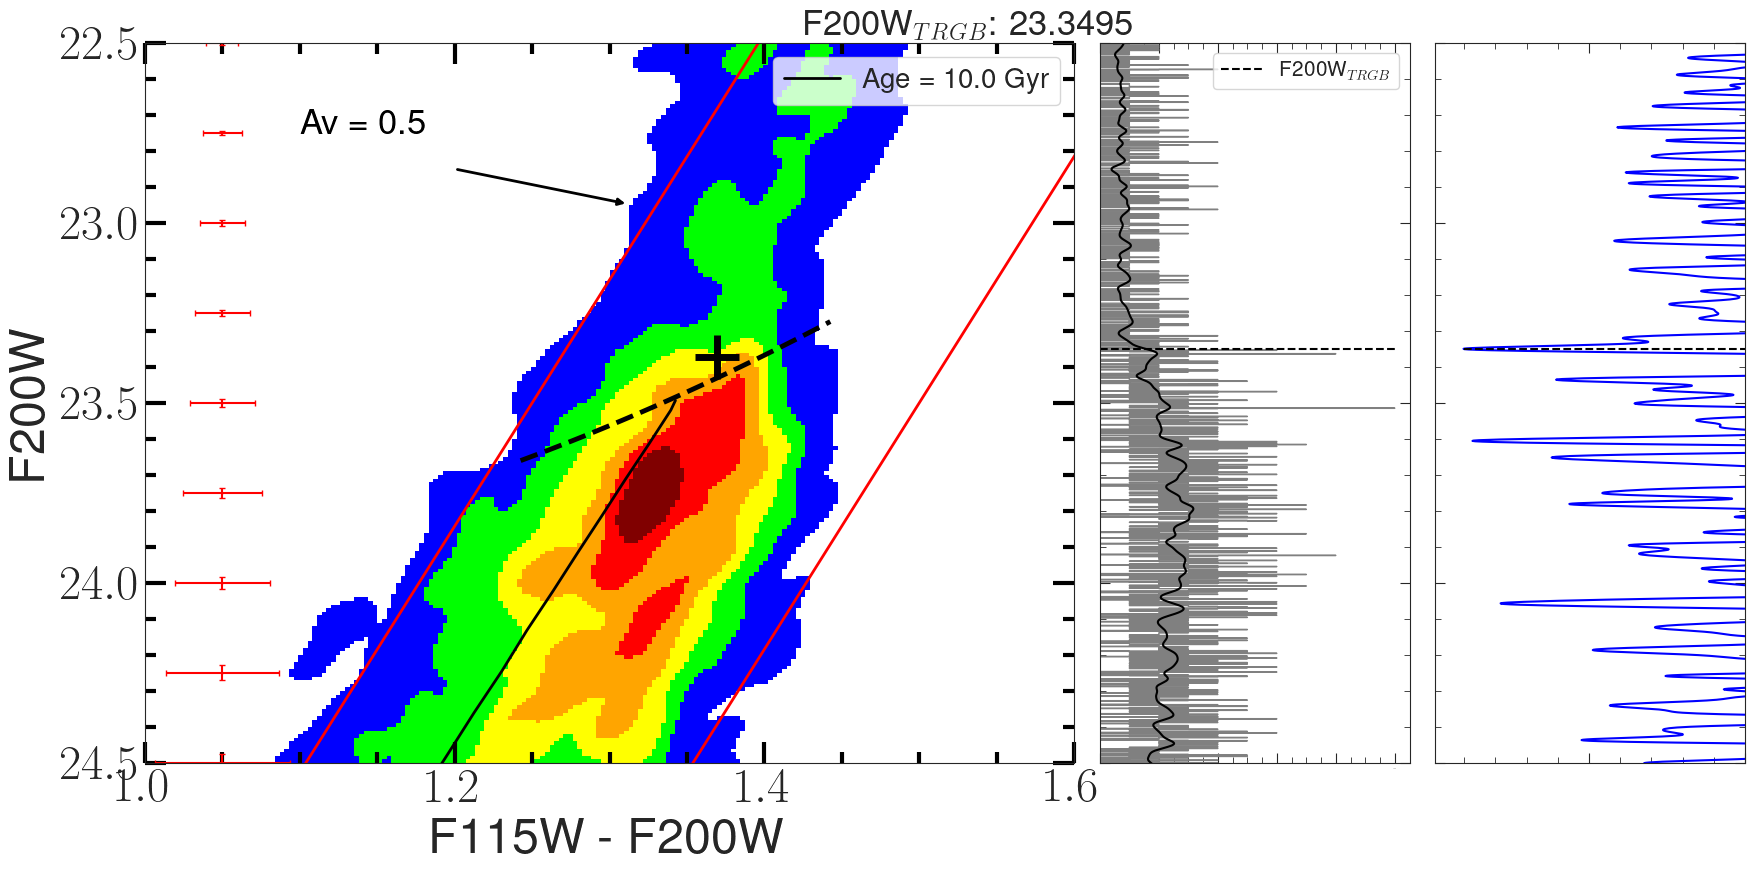

In [298]:
model_mag_err_f200w = models.Exponential1D(4.62861558e-10, 1.35545518e+00)
model_col_err = models.Exponential1D(1.01336272e-08, 1.57271500e+00)

tab = Table.read('../photometry/ngc628/f115w_f200w_photometry.fits')

filt1 = 'f115w'
filt2 = 'f200w'
filt3 = 'f200w'

dy= 0.25

y_lo = 19
y_hi = 28

cmd_xlo = 1.25
y0 = 23.5

cmd_xhi = cmd_xlo + dy*1.1

col_lims = [23.20, 23.5]
ms = []
for b in np.arange(0.001,0.0101,0.001):
    for sigma_s in np.arange(0.01,0.101,0.01):
        bins = np.arange(y_lo, y_hi, b)
        #sigma_s = 0.1

        r_in  = 0
        r_out = 8.9
        fig = plt.figure(figsize=(20, 9))
        gs = fig.add_gridspec(1, 3,  width_ratios=(3, 1,1),
                              left=0.1, right=0.9, bottom=0.1, top=0.9,
                              wspace=0.05, hspace=0.05)

        ax =  fig.add_subplot(gs[0, 0])
        y_lo = 19
        y_hi = 28

        k = i
        ra_cen  = regions_dict[f'bubble']['ra']
        dec_cen = regions_dict[f'bubble']['dec']
        
        y = tab['mag_vega_F200W']
        x = tab['mag_vega_F115W'] - tab['mag_vega_F200W'] - 0.19*(Av_dict['f115w'] - Av_dict['f200w'])
        tab_n = tab.copy()
        tab_n['mag_vega_F200W'] = tab['mag_vega_F200W'].value - parsec_model(x.value,-18)
        tab_n['mag_vega_F115W'] = tab['mag_vega_F115W'].value - parsec_model(x.value,-18)
        #print(parsec_model(x_piv))
        newcmp = ListedColormap(["#FFFFFF",  # Black
            "#0000FF",  # Blue
            "#00FF00",  # Green
            "#FFFF00",  # Yellow
            "#FFA500",  # Orange
            "#FF0000",  # Red
            "#800000"   # Dark Red
                                ])
        fig, ax, dats_bub, x_val, y_val, y_bins,params = gen_CMD_ycut(tab, filt1, filt2, filt3,cmd=df_cmd_jwst, 
                                                                      ra_col='ra', dec_col='dec',
                                                                      cmap=newcmp,
                                                                      ra_cen=ra_cen, dec_cen=dec_cen,
                                                                      r_in=r_in, r_out=r_out,Av = 0.19, Av_=0.5,
                                                                      met=0.002, sqr_field=False, mag_err_lim=0.2,
                                                                      age=10, gen_kde=True, Av_y = 22.85, Av_x=1.2,
                                                                      y_lo=y_lo, y_hi=y_hi, rgb_ylo=23.2, rgb_yhi=26,
                                                                      dy=dy, cmd_xlo=cmd_xlo, cmd_xhi=cmd_xhi,
                                                                      xlims=[1,1.6], ylims=[22.5,24.5], y0=y0,
                                                                      fit_isochrone=True, perp_iso=False, 
                                                                      dismod=29.81, fig=fig, ax=ax,s=10,lw=2,
                                                                      ref_xpos=1.05, ref_dy=0.25)

        #x = col_parsec[-1][3:]  + (Av_dict['f115w'] - Av_dict['f200w'])*0.19
        #y = m_parsec[-1][3:] + 29.83 + Av_dict['f200w']*0.19
        
        x = col_parsec.ravel().copy()
        y = m_parsec.ravel().copy()
        ind = np.argsort(x)

        x = x[ind]
        y = y[ind]
        x_piv = x[-18]
        y_piv = y[-18]
        
        x = np.linspace(1.2,1.4)
        y = parsec_model(x,-18) + y_piv  
        
        x +=  (Av_dict['f115w'] - Av_dict['f200w'])*0.19
        y +=  29.81 + 0.19*Av_dict['f200w']
        ax.plot(x,y, '--k', lw=3.5)
        
        m = bubble_f200w - bubble_f200w_crowd
        col = bubble_col - bubble_col_crowd
    
        ax.scatter(col, m, s=1000, lw=5, marker='+', color='black')

        #x = col_basti[-1][3:]  + (Av_dict['f115w'] - Av_dict['f200w'])*0.19
        #y = m_basti[-1][3:] + 29.79 + Av_dict['f200w']*0.19
        #ax.plot(x,y, '--', color='black', lw=3.5)

        ax_hist = fig.add_subplot(gs[0, 1], sharey=ax)
        ax_edge = fig.add_subplot(gs[0, 2], sharey=ax)
        ax.set_title('')


        for dat in dats_bub:
            #ms = []
            x_ = dat[0]
            y_ = dat[1]

            for _ in range(1):
                x = x_#np.random.normal(loc=x_,scale=model_col_err(y_))
                y = y_#np.random.normal(loc=y_,scale=model_mag_err_f200w(y_))

                lf_count = len(x)
                bins = np.arange(y_lo, y_hi, b)
                yh,xh,_, = ax_hist.hist(y,bins, orientation='horizontal' , histtype='step', color='grey')
                xh = 0.5*(xh[1:] + xh[:-1])

                yf = gloess(xh,yh,sigma_s,1)
                ysob = np.convolve(yf,np.array([-1,0,1]), mode='same')

                ax_hist.plot(yf, xh, color='black')
                ax_edge.plot(ysob, xh,'b',alpha=1)

                c1 = (xh>=col_lims[0]) & (xh<=col_lims[1])
                m = xh[c1][ysob[c1]==ysob[c1].min()][0]
                ms.append(m)


        ax_hist.tick_params(axis="y", labelleft=False)
        ax_edge.tick_params(axis="x", labelbottom=False)
        ax_edge.tick_params(axis="y", labelleft=False)

        ax_edge.set_title(f'{filt3.upper()}'+ '$_{TRGB}$' f': {np.round(m,5)}', fontsize=25,x=-1.5)
        #m = 23.40525000
        #ax.plot([0,3],[m,m],'--k', zorder=201)
        ax_hist.plot([0,yh.max()],[m,m],'--k',label=f'{filt3.upper()}'+ '$_{TRGB}$')
        ax_hist.legend(fontsize=15)
        ax_hist.set_xticks([np.ceil(yh.max())],[np.ceil(yh.max())])
        ax_hist.tick_params(axis='both', labelsize=0)
        dismod = m - params[0]-params[1]
        #ax_hist.set_title(f'DM : {np.round(dismod, 3)}', fontsize=25)
        ax_edge.plot([ysob.min(),ysob.max()],[m,m],'--k')
        ax_edge.set_xlim([ysob.min()*1.1,0])
        #ax_edge.invert_xaxis()

        for ax_ in [ax_hist, ax_edge]:
            ax_.xaxis.set_major_locator(AutoLocator())
            ax_.xaxis.set_minor_locator(AutoMinorLocator())


            ax_.yaxis.set_major_locator(AutoLocator())
            ax_.yaxis.set_minor_locator(AutoMinorLocator())

            ax_.tick_params(which='both', length=7,direction="in", bottom=True, top=True,left=True, right=True)
            ax_.tick_params(which='minor', length=4)
            
        #fig.savefig(f'TRGBv2/{np.round(sigma_s,3)}_{np.round(b,3)}_bubble.png', bbox_inches='tight')
        #plt.close(fig)
        break
    break

In [299]:
bubble_f200w - bubble_f200w_crowd

23.372

In [300]:
m

23.349500000005314

In [254]:
ms = np.array(ms)

In [255]:
np.median(ms) - y_piv - 0.19*Av_dict['f200w'] + bubble_f200w_crowd

29.830950000000694

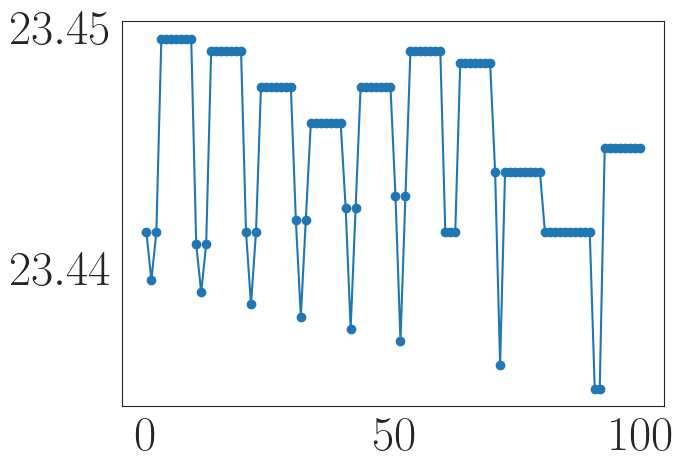

In [256]:
plt.plot(ms, '-o')

In [210]:
bubble_f200w

23.418

In [200]:
np.median(ms)

23.40525000000043

In [197]:
np.median(ms[ms<23.425])

23.401000000000167

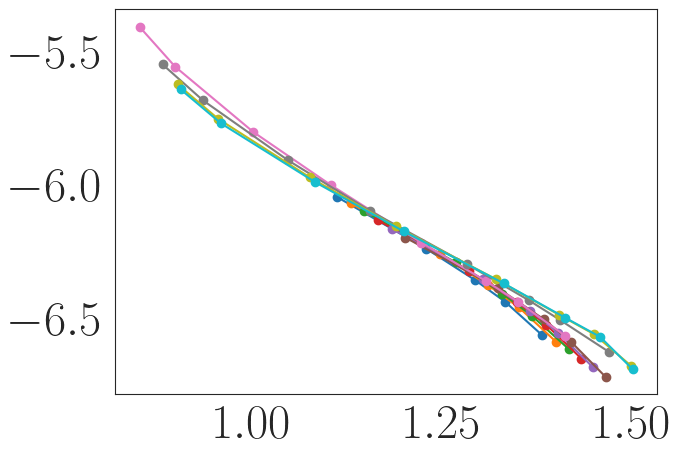

In [246]:
plt.plot(col_parsec.T,m_parsec.T,'-o')

plt.plot(col_basti.T,m_basti.T,'-o')

In [231]:
x = col_parsec.ravel().copy()
y = m_parsec.ravel().copy()
ind = np.argsort(x)

x = x[ind]
y = y[ind]

init = models.Linear1D()
fit = fitting.LinearLSQFitter()
model = fit(init,x,y)

x_piv = x[-18]
y_piv = y[-18]

In [235]:
y_piv

-6.377

In [252]:
Av_dict['f115w'], Av_dict['f200w']

(0.419, 0.195)

In [249]:
0.19*Av_dict['f115w'] - 0.19*Av_dict['f200w']

0.04256

In [238]:
23.41 - y_piv - 0.19*Av_dict['f200w'] + bubble_f200w_crowd

29.795949999999998

In [247]:
x = col_basti.ravel().copy()
y = m_basti.ravel().copy()
ind = np.argsort(x)

x = x[ind]
y = y[ind]

init = models.Linear1D()
fit = fitting.LinearLSQFitter()
model = fit(init,x,y)

x_piv = x[-18]
y_piv = y[-18]

In [227]:
np.median(ms)

23.34724999999965

In [229]:
y_piv

-6.1565

In [228]:
np.median(ms) - y_piv - 0.19*Av_dict['f200w'] + bubble_f200w_crowd

29.51269999999965

In [190]:
np.percentile(ms, [16,84]) - np.median(ms)

array([-0.00925,  0.04225])

In [150]:
np.sqrt(0.05**2 + 0.03**2)

0.05830951894845301

Number of objects in the selected region: 10374


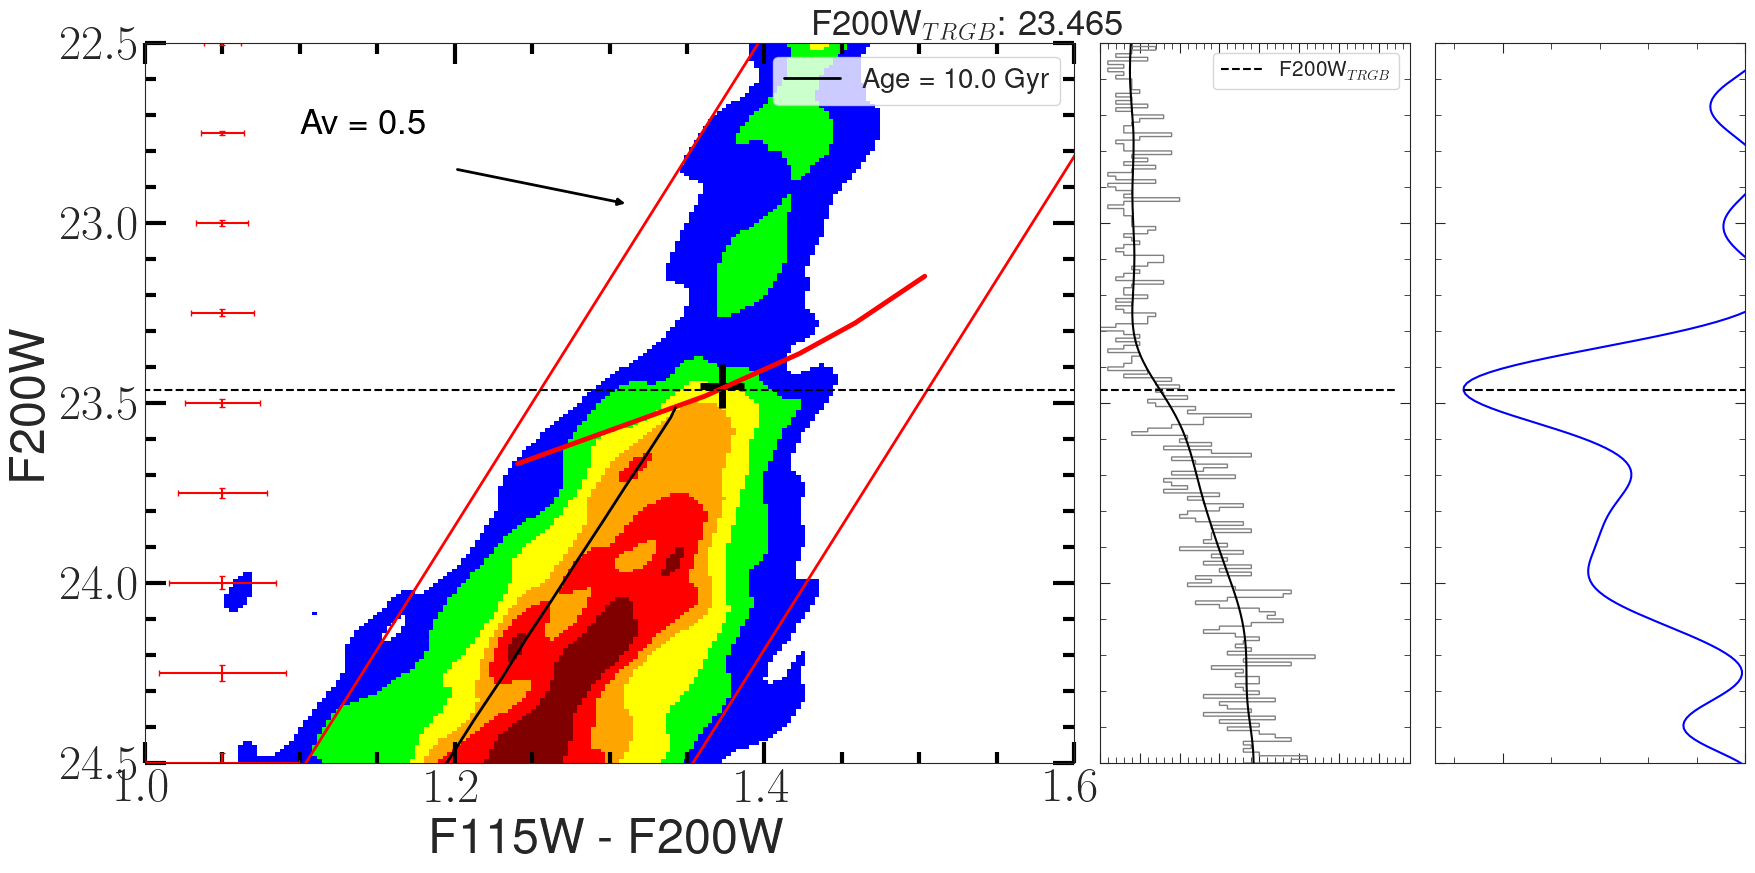

In [134]:
model_mag_err_f200w = models.Exponential1D(4.62861558e-10, 1.35545518e+00)
model_col_err = models.Exponential1D(1.01336272e-08, 1.57271500e+00)

tab = Table.read('../photometry/ngc628/f115w_f200w_photometry.fits')

filt1 = 'f115w'
filt2 = 'f200w'
filt3 = 'f200w'


for i in range(90):
    i=10
    dy= 0.25

    y_lo = 19
    y_hi = 28

    cmd_xlo = 1.25
    y0 = 23.5

    cmd_xhi = cmd_xlo + dy*1.1

    col_lims = [23.20, 23.7]
    bins = np.arange(y_lo, y_hi, 0.01)
    sigma_s = 0.1

    r_in  = 0
    r_out = 24
    fig = plt.figure(figsize=(20, 9))
    gs = fig.add_gridspec(1, 3,  width_ratios=(3, 1,1),
                          left=0.1, right=0.9, bottom=0.1, top=0.9,
                          wspace=0.05, hspace=0.05)
    
    ax =  fig.add_subplot(gs[0, 0])
    #fig, ax = plt.subplots(figsize=(10,10))
    y_lo = 19
    y_hi = 28

    k = i
    ra_cen  = regions_dict[f'reg_{int(i)}']['ra']
    dec_cen = regions_dict[f'reg_{int(i)}']['dec']

    y = tab['mag_vega_F200W']
    x = tab['mag_vega_F115W'] - tab['mag_vega_F200W']

    #parsec_model = lambda x_: np.interp(x_,col_basti[-1][3:], m_basti[-1][3:] - m_basti[-1][-3])

    tab_n = tab.copy()
    #tab_n['mag_vega_F200W'] = tab['mag_vega_F200W'] - parsec_model(x)
    #tab_n['mag_vega_F115W'] = tab['mag_vega_F115W'] - parsec_model(x)
    newcmp = ListedColormap(["#FFFFFF",  # Black
        "#0000FF",  # Blue
        "#00FF00",  # Green
        "#FFFF00",  # Yellow
        "#FFA500",  # Orange
        "#FF0000",  # Red
        "#800000"   # Dark Red
                            ])
    fig, ax, dats_bub, x_val, y_val, y_bins,params = gen_CMD_ycut(tab, filt1, filt2, filt3,cmd=df_cmd_jwst, 
                                                                  ra_col='ra', dec_col='dec',
                                                                  cmap=newcmp,
                                                                  ra_cen=ra_cen, dec_cen=dec_cen,
                                                                  r_in=r_in, r_out=r_out,Av = 0.19, Av_=0.5,
                                                                  met=0.002, sqr_field=True, mag_err_lim=0.2,
                                                                  age=10, gen_kde=True, Av_y = 22.85, Av_x=1.2,
                                                                  y_lo=y_lo, y_hi=y_hi, rgb_ylo=23.2, rgb_yhi=26,
                                                                  dy=dy, cmd_xlo=cmd_xlo, cmd_xhi=cmd_xhi,
                                                                  xlims=[1,1.6], ylims=[22.5,24.5], y0=y0,
                                                                  fit_isochrone=True, perp_iso=False, 
                                                                  dismod=29.83, fig=fig, ax=ax,s=10,lw=2,
                                                                  ref_xpos=1.05, ref_dy=0.25)

    x = col_parsec[-1][3:]  + (Av_dict['f115w'] - Av_dict['f200w'])*0.19
    y = m_parsec[-1][3:] + 29.83 + Av_dict['f200w']*0.19
    ax.plot(x,y, color='red', lw=3.5)

    #x = col_basti[-1][3:]  + (Av_dict['f115w'] - Av_dict['f200w'])*0.19
    #y = m_basti[-1][3:] + 29.79 + Av_dict['f200w']*0.19
    #ax.plot(x,y, '--', color='black', lw=3.5)

    ax_hist = fig.add_subplot(gs[0, 1], sharey=ax)
    ax_edge = fig.add_subplot(gs[0, 2], sharey=ax)
    ax.set_title('')
    
    m = trgb_f200w_mag.ravel()[k] 
    col = trgb_cols[:,:,7].ravel()[k]
    
    ax.scatter(col, m, s=1000, lw=5, marker='+', color='black')
    #fig.savefig(f'TRGBv2/Reg_{i}.png',bbox_inches='tight')
    #plt.close(fig)
    
    for dat in dats_bub:
        ms = []
        x_ = dat[0]
        y_ = dat[1]

        for _ in range(1):
            x = x_#np.random.normal(loc=x_,scale=model_col_err(y_))
            y = y_#np.random.normal(loc=y_,scale=model_mag_err_f200w(y_))

            lf_count = len(x)
            bins = np.arange(y_lo, y_hi, 0.01)
            yh,xh,_, = ax_hist.hist(y,bins, orientation='horizontal' , histtype='step', color='grey')
            xh = 0.5*(xh[1:] + xh[:-1])

            yf = gloess(xh,yh,sigma_s,1)
            ysob = np.convolve(yf,np.array([-1,0,1]), mode='same')

            ax_hist.plot(yf, xh, color='black')
            ax_edge.plot(ysob, xh,'b',alpha=1)

            c1 = (xh>=col_lims[0]) & (xh<=col_lims[1])
            m = xh[c1][ysob[c1]==ysob[c1].min()][0]
            ms.append(m)

    
    ax_hist.tick_params(axis="y", labelleft=False)
    ax_edge.tick_params(axis="x", labelbottom=False)
    ax_edge.tick_params(axis="y", labelleft=False)

    ax_edge.set_title(f'{filt3.upper()}'+ '$_{TRGB}$' f': {np.round(m,5)}', fontsize=25,x=-1.5)
    ax.plot([0,3],[m,m],'--k', zorder=201)
    ax_hist.plot([0,yh.max()],[m,m],'--k',label=f'{filt3.upper()}'+ '$_{TRGB}$')
    ax_hist.legend(fontsize=15)
    ax_hist.set_xticks([np.ceil(yh.max())],[np.ceil(yh.max())])
    ax_hist.tick_params(axis='both', labelsize=0)
    dismod = m - params[0]-params[1]
    #ax_hist.set_title(f'DM : {np.round(dismod, 3)}', fontsize=25)
    ax_edge.plot([ysob.min(),ysob.max()],[m,m],'--k')
    ax_edge.set_xlim([ysob.min()*1.1,0])
    #ax_edge.invert_xaxis()

    for ax_ in [ax_hist, ax_edge]:
        ax_.xaxis.set_major_locator(AutoLocator())
        ax_.xaxis.set_minor_locator(AutoMinorLocator())


        ax_.yaxis.set_major_locator(AutoLocator())
        ax_.yaxis.set_minor_locator(AutoMinorLocator())

        ax_.tick_params(which='both', length=7,direction="in", bottom=True, top=True,left=True, right=True)
        ax_.tick_params(which='minor', length=4)
    
    break
    dy= 0.1
    cmd_xlo = 1.2
    cmd_xhi = 1.5

    dats  = []
    min_  = cmd_xlo
    max_  = cmd_xhi

    step  = 0.02

    bins  = np.arange(min_, max_, step)

    y_lo  = m - 0.02
    y_hi  = m + 0.081
    
    fig, ax = plt.subplots(1,2,figsize=(25, 9))

    _, _, dats, x_val, y_val, y_bins, model_rgb,_ = gen_CMD_xcut(tab_n,filt1, filt2,filt3,
                                                               ra_col='ra', dec_col='dec',
                                                               ra_cen=ra_cen, dec_cen=dec_cen,
                                                               cmd=df_cmd_jwst, label_min=0, label_max=3,Av=0.19, sqr_field=False,
                                                               r_in=r_in, r_out=r_out, age=10, met=0.002,Av_y=24.64, Av_x=1.73,
                                                               y_lo=y_lo, y_hi=y_hi,dismod=29.83,xlims=[1,1.6], ylims=[21,27],
                                                               dy=dy, dx=cmd_xhi-cmd_xlo, Av_=1,
                                                               cmd_xlo=cmd_xlo, cmd_xhi=cmd_xhi, rgb_ylo=m, rgb_yhi=26,          
                                                               fit_isochrone=False,fig=fig, ax=ax[0],s=0.5,
                                                               mag_err_lim=0.2)

    ax[0].tick_params(which='both', length=20,direction="in", bottom=True, top=True,left=True, right=True)
    ax[0].tick_params(which='minor', length=15)

    dat = dats[0][0]
    y, x = np.histogram(dat, bins=bins)

    max_bub = y.max()

    x = 0.5*(x[1:] + x[:-1])

    ax[1].step(x,y, where='mid', color='black')

    mean, median, stddev= sigma_clipped_stats(dat, sigma=2, cenfunc=biweight_location, stdfunc=biweight_scale, maxiters=10)

    p = x[y==y.max()][0]
    x_p1 = mean
    s_p1 = stddev

    ax[1].bar(x_p1,height=y.max(), width=0.02, align='center', color='blue', alpha=0.6,zorder=100)
    ax[1].axvline(model_rgb(m), linestyle = '--', color='red', lw=2,zorder=200)

    title = ''
    title += r"$Biweighted_{\mu}:$ " + f"{np.round(x_p1,4)} | "
    title += r'$Biweighted_{\sigma}:$ ' + f"{np.round(s_p1,4)}"
    title += r' | $Peak :$' + f' {np.round(p,4)}\n'

    ax[1].set_title(title, fontsize=35,x=-0.1)
    ax[1].set_ylabel('Counts', fontsize=35)

    ax[1].set_xlabel(f'{filt1.upper()}-{filt2.upper()}')

    ax[1].xaxis.set_major_locator(AutoLocator())
    ax[1].xaxis.set_minor_locator(AutoMinorLocator())


    ax[1].yaxis.set_major_locator(AutoLocator())
    ax[1].yaxis.set_minor_locator(AutoMinorLocator())

    ax[1].tick_params(which='both', length=15,direction="in", bottom=True, top=True,left=True, right=True, width = 3)
    ax[1].tick_params(which='minor', length=8, width = 3)
    ax[1].legend()
    break
    plt.close(fig)


In [67]:
trgb_f200w_mag.

array([[23.476, 23.477, 23.493, 23.467, 23.513, 23.471],
       [23.467, 23.605, 23.51 , 23.516, 23.453, 23.491],
       [23.468, 23.666, 23.686, 23.461, 23.439, 23.499],
       [23.478, 23.443, 23.515, 23.391, 23.466, 23.443],
       [23.481, 23.502, 23.473, 23.44 , 23.452, 23.449],
       [23.421, 23.46 , 23.446, 23.356, 23.308, 23.396],
       [23.424, 23.408, 23.357, 23.25 , 23.353, 23.316],
       [23.554, 23.411,    nan,    nan, 23.281, 23.358],
       [23.421, 23.335, 23.298, 23.314, 23.442, 23.45 ],
       [23.35 , 23.455, 23.438, 23.361, 23.449, 23.381],
       [23.559, 23.445, 23.419, 23.377, 23.363, 23.46 ],
       [23.428, 23.475, 23.475, 23.427, 23.477, 23.488],
       [23.495, 23.425, 23.55 , 23.442, 23.443, 23.473],
       [23.446, 23.459, 23.526, 23.472, 23.54 , 23.425],
       [23.526, 23.589, 23.541, 23.486, 23.486, 23.54 ]])

In [ ]:
LinearSegmentedColormap

In [ ]:
model_rgb(m)-0.05, model_rgb(m)+0.05

In [ ]:
filt1 = 'f115w'
filt2 = 'f200w'
filt3 = 'f200w'

model_mag_err_f200w = models.Exponential1D(4.62861558e-10, 1.35545518e+00)
model_col_err = models.Exponential1D(1.01336272e-08, 1.57271500e+00)

r_s = [192.   , 173.   , 165.1  , 158.   , 151.   , 145.   , 140.   ,
       135.4  , 131.   , 127.   , 123.6  , 121.1  , 118.   , 114.6  ,
       112.2  , 109.5  , 107.   , 104.3  , 101.   ,  99.   ,  97.   ,
        94.7  ,  92.2  ,  90.   ,  88.   ,  86.   ,  84.   ,  82.   ,
        80.3  ,  78.8  ,  77.2  ,  76.   ,  74.6  ,  73.39 ,  72.16 ,
        71.   ,  69.9  ,  68.9  ,  68.05 ,  67.1  ,  66.1  ,  65.2  ,
        64.4  ,  63.6  ,  62.6  ,  61.4  ,  60.362,  59.641,  58.7  ,
        57.6  ,  56.77 ,  55.6  ,  54.7  ,  53.7  ,  52.9  ,  51.9  ,
        50.9  ,  49.98 ,  49.07 ,  48.28 ,  47.1  ,  46.15 ,  45.26 ,
        44.3  ,  43.3  ,  42.4  ,  41.4  ,  40.2  ,  39.3  ,  38.3  ,
        37.3]
r_count= []

sigma_s = 0.071
tab = Table.read('../photometry/ngc628/f115w_f200w_photometry.fits')

ra_cen  = regions_dict[f'ngc628']['ra']
dec_cen = regions_dict[f'ngc628']['dec']

for i in range(20):
    
    r_in  = np.floor(r_s[-1])
    r_out = r_s[-1]
    count = 0
    
    decrement = -1  # Initial decrement step size
    cross_flag = False
    fine_flag = False
    
    while not (190 <= count <= 210):
        # Adjust decrement step size based on count
        skip_while = False
        if count>210 and not fine_flag and not cross_flag:
            cross_flag = True
            fine_flag = True
            
        if cross_flag and fine_flag:
            decrement *= -0.1
            fine_flag = False
            
        if cross_flag and count<190:
            decrement *= -0.1
            cross_flag = False
             
        r_in += decrement            

        r_in = np.round(r_in,5)
        
        fig = plt.figure(figsize=(20, 9))
        gs = fig.add_gridspec(1, 3,  width_ratios=(4, 1,1),
                              left=0.1, right=0.9, bottom=0.1, top=0.9,
                              wspace=0.05, hspace=0.05)

        ax =  fig.add_subplot(gs[0, 0])
        
        dy= 0.25

        y_lo = 19
        y_hi = 28

        cmd_xlo = 1.25
        y0 = 23.5

        cmd_xhi = cmd_xlo + dy*1.1
        col_lims = [23.20, 23.7]
        bins = np.arange(y_lo, y_hi, 0.005)
        
        Av_corr = 0.0
        fig, ax, dats_bub, x_val, y_val, y_bins,params = gen_CMD_ycut(tab, filt1, filt2, filt3,cmd=df_cmd_jwst, 
                                                                      ra_col='ra', dec_col='dec',
                                                                      ra_cen=ra_cen, dec_cen=dec_cen,
                                                                      r_in=r_in, r_out=r_out,Av = 0.19+Av_corr, Av_=1,
                                                                      met=0.002, sqr_field=False, mag_err_lim=0.2,
                                                                      age=10, gen_kde=True, Av_y = 23.64, Av_x=1.73,
                                                                      y_lo=y_lo, y_hi=y_hi, rgb_ylo=23.2, rgb_yhi=26,
                                                                      dy=dy, cmd_xlo=cmd_xlo, cmd_xhi=cmd_xhi,
                                                                      xlims=[0.5,2], ylims=[22.5,25], y0=y0,
                                                                      fit_isochrone=True, perp_iso=False, 
                                                                      dismod=29.7416, fig=fig, ax=ax,s=10,lw=2,)
        ax_hist = fig.add_subplot(gs[0, 1], sharey=ax)
        ax_edge = fig.add_subplot(gs[0, 2], sharey=ax)
        ax.set_title('')
        for dat in dats_bub:
            ms = []
            x = dat[0]
            y = dat[1]
            
            lf_count = len(x)
            bins = np.arange(y_lo, y_hi, 0.005)
            yh,xh,_, = ax_hist.hist(y,bins, orientation='horizontal' , histtype='step', color='grey')
            xh = 0.5*(xh[1:] + xh[:-1])

            yf = gloess(xh,yh,sigma_s,1)
            ysob = np.convolve(yf,np.array([-1,0,1]), mode='same')

            #ax_hist.plot(yf, xh, color='black')
            #ax_edge.plot(ysob, xh,'b',alpha=1)
            
            c1 = (xh>=col_lims[0]) & (xh<=col_lims[1])
            m = xh[c1][ysob[c1]==ysob[c1].min()][0]
            ms.append(m)
        plt.close(fig)

        filt1 = 'f115w'
        filt2 = 'f200w'
        filt3 = 'f200w'

        dy= 0.08
        cmd_xlo = 1.2
        cmd_xhi = 1.6

        dats  = []
        min_  = cmd_xlo
        max_  = cmd_xhi

        step  = 0.02

        bins  = np.arange(min_, max_, step)

        y_lo  = m - 0.02
        y_hi  = m + 0.061
        dats  = []
        fig, ax = plt.subplots(1,2,figsize=(20, 9))

        ra_cen  = regions_dict[f'ngc628']['ra']
        dec_cen = regions_dict[f'ngc628']['dec']

        _, _, dats, x_val, y_val, y_bins, model_rgb = gen_CMD_xcut(tab,filt1, filt2,filt3, 
                                                                   ra_col ='ra', dec_col = 'dec',
                                                                   ra_cen=ra_cen, dec_cen=dec_cen,
                                                                   cmd=df_cmd_jwst, label_min=0, label_max=3,Av=0.19, sqr_field=False,
                                                                   r_in=r_in, r_out=r_out, age=10, met=0.002,Av_y=23.4, Av_x=2,
                                                                   y_lo=y_lo, y_hi=y_hi,dismod=29.7416,xlims=[-0.5,3], ylims=[19,28],
                                                                   dy=dy, dx=cmd_xhi-cmd_xlo,
                                                                   cmd_xlo=cmd_xlo, cmd_xhi=cmd_xhi, rgb_ylo=m, rgb_yhi=26,          
                                                                   fit_isochrone=False,fig=fig, ax=ax[0],s=5)

        ax[0].tick_params(which='both', length=20,direction="in", bottom=True, top=True,left=True, right=True)
        ax[0].tick_params(which='minor', length=15)

        dat = dats[0][0]

        count = len(dat)
        print(count, r_in, r_out)
        plt.close(fig)
    print(count, r_in, r_out)
    r_count.append(lf_count)
    r_s.append(r_in)

In [ ]:
filt1 = 'f115w'
filt2 = 'f200w'
filt3 = 'f200w'

model_mag_err_f200w = models.Exponential1D(4.62861558e-10, 1.35545518e+00)
model_col_err = models.Exponential1D(1.01336272e-08, 1.57271500e+00)

if filt3 == 'f200w':
    dy= 0.25
elif filt3 == 'f115w':
    dy = 0.25
elif filt3== 'f150w':
    dy = 0.25
    
y_lo = 19
y_hi = 28

if filt3 == 'f200w':
    cmd_xlo = 1.25
    y0 = 23.5
elif filt3 == 'f115w':
    cmd_xlo = 1.25
    y0 = 24.8
elif filt3 == 'f150w':
    cmd_xlo = 1.23
    y0 = 24.

cmd_xhi = cmd_xlo + dy*1.1

nx = 15
ny = 6

if filt3 == 'f200w':
    col_lims = [23.20, 23.7]
    
elif filt3 == 'f115w':
    col_lims = [24.4, 25.1]
    
elif filt3 == 'f150w':
    col_lims = [23.5, 24.3]

tab = Table.read('../photometry/ngc628/f115w_f200w_photometry.fits')

grid_TRGB = []

r_in  = 0
r_out = 24

col_lims = [23.20, 23.7]

mss = []
for k in [89]:
    if k in [70]:
        col_lims = [23.20, 23.55]       
    for b in np.arange(0.001,0.0101,0.001):
        bins = np.arange(y_lo, y_hi, b)
        ms = []
        for sigma_s in np.arange(0.05,0.101,0.01):


            fig = plt.figure(figsize=(20, 9))
            gs = fig.add_gridspec(1, 3,  width_ratios=(4, 1,1),
                                  left=0.1, right=0.9, bottom=0.1, top=0.9,
                                  wspace=0.05, hspace=0.05)

            ax =  fig.add_subplot(gs[0, 0])

            ra_cen  = regions_dict[f'reg_{k}']['ra']
            dec_cen = regions_dict[f'reg_{k}']['dec']

            fig, ax, dats_bub, x_val, y_val, y_bins,params = gen_CMD_ycut(tab, filt1, filt2, filt3,cmd=df_cmd_jwst, 
                                                                          ra_col='ra', dec_col='dec',
                                                                          ra_cen=ra_cen, dec_cen=dec_cen,
                                                                          r_in=r_in, r_out=r_out,
                                                                          met=0.002, sqr_field=True, mag_err_lim=0.2,
                                                                          age=10, gen_kde=True,
                                                                          y_lo=y_lo, y_hi=y_hi, rgb_ylo=23,
                                                                          dy=dy, cmd_xlo=cmd_xlo, cmd_xhi=cmd_xhi,
                                                                          xlims=[0.5,2], ylims=[21,27], y0=y0,
                                                                          fit_isochrone=True, perp_iso=False, 
                                                                          dismod=29.86, fig=fig, ax=ax)

            ax_hist = fig.add_subplot(gs[0, 1], sharey=ax)
            ax_edge = fig.add_subplot(gs[0, 2], sharey=ax)


            for dat in dats_bub:
                ms_ = []
                for _ in range(1):
                    x = dat[0]
                    y = dat[1]

                    #x = np.random.normal(loc=x,scale=model_col_err(x))
                    #y = np.random.normal(loc=y,scale=model_mag_err_f200w(y))

                    yh,xh,_, = ax_hist.hist(y,bins, orientation='horizontal' , histtype='step', color='grey')
                    xh = 0.5*(xh[1:] + xh[:-1])

                    yf = gloess(xh,yh,sigma_s,1)
                    ysob = np.convolve(yf,np.array([-1,0,1]), mode='same')

                    ax_hist.plot(yf, xh, color='black')
                    ax_edge.plot(ysob, xh,'b')

                    c1 = (xh>=col_lims[0]) & (xh<=col_lims[1])
                    m = xh[c1][ysob[c1]==ysob[c1].min()][0]

                    ms_.append(m)

                ax_hist.tick_params(axis="y", labelleft=False)
                ax_edge.tick_params(axis="x", labelbottom=False)
                ax_edge.tick_params(axis="y", labelleft=False)

                ax_edge.set_title(f'{filt3.upper()}'+ '$_{TRGB}$' f': {np.round(m,5)}', fontsize=25)
                ax.plot([0,3],[m,m],'--k', zorder=201)
                ax_hist.plot([0,yh.max()],[m,m],'--k',label=f'{filt3.upper()}'+ '$_{TRGB}$')
                ax_hist.legend(fontsize=15)
                ax_hist.set_xticks([np.ceil(yh.max())],[np.ceil(yh.max())])
                ax_hist.tick_params(axis='both', labelsize=0)
                dismod = m - params[0]-params[1]
                ax_hist.set_title(f'DM : {np.round(dismod, 3)}', fontsize=25)
                ax_edge.plot([ysob.min(),ysob.max()],[m,m],'--k')
                ax_edge.set_xlim([ysob.min()*1.1,0])
                #ax_edge.invert_xaxis()

                for ax_ in [ax_hist, ax_edge]:
                    ax_.xaxis.set_major_locator(AutoLocator())
                    ax_.xaxis.set_minor_locator(AutoMinorLocator())

                    ax_.yaxis.set_major_locator(AutoLocator())
                    ax_.yaxis.set_minor_locator(AutoMinorLocator())

                    ax_.tick_params(which='both', length=7,direction="in", bottom=True, top=True,left=True, right=True)
                    ax_.tick_params(which='minor', length=4)

                fig.savefig(f"TRGB/region_{k}_{filt3}_{np.round(sigma_s,4)}_{np.round(b,4)}_mag.png",
                           bbox_inches='tight')
                plt.close(fig) 
            ms.append(ms_)

        mss.append(ms)

    m_t = np.array(mss)
grid_TRGB = np.array(m_t)

In [ ]:
start = 0
end = None

In [ ]:
np.round(np.nanmedian(grid_TRGB.T[0][start:end]),3)

In [ ]:
p = grid_TRGB.T[0][start:end].ravel()[(grid_TRGB.T[0][start:end].ravel()>=np.nanmedian(grid_TRGB.T[0][start:end]))].std()
np.round(p,4)

In [ ]:
m = grid_TRGB.T[0][start:end].ravel()[(grid_TRGB.T[0][start:end].ravel()<np.nanmedian(grid_TRGB.T[0][start:end]))].std()
np.round(m,4)

In [ ]:
bins = np.arange(0.001, 0.011, 0.001)

plt.figure(figsize=(15,7))
for n, i in enumerate(grid_TRGB.T[0][start:end]):
    
    plt.plot(bins, i, '-o',lw=3)
plt.legend(np.arange(0.05, 0.11, 0.01))

In [ ]:
trgb_f200w_mag trgb_cols[:,:,6]

In [301]:
trgb_f200w_mag = np.array([[23.476, 23.477, 23.493, 23.467, 23.513, 23.471],
                           [23.467, 23.605, 23.510, 23.516, 23.453, 23.491],
                           [23.468, 23.666, 23.686, 23.461, 23.439, 23.499],
                           [23.478, 23.443, 23.515, 23.391, 23.466, 23.443],
                           [23.481, 23.502, 23.473, 23.440, 23.452, 23.449],
                           [23.421, 23.460, 23.446, 23.356, 23.308, 23.396],
                           [23.424, 23.408, 23.357, 23.250, 23.353, 23.316],
                           [23.554, 23.411, np.nan, np.nan, 23.281, 23.358],
                           [23.421, 23.335, 23.298, 23.314, 23.442, 23.450],
                           [23.350, 23.455, 23.438, 23.361, 23.449, 23.381],
                           [23.559, 23.445, 23.419, 23.377, 23.363, 23.460],
                           [23.428, 23.475, 23.475, 23.427, 23.477, 23.488],
                           [23.495, 23.425, 23.550, 23.442, 23.443, 23.473],
                           [23.4460, 23.459, 23.526, 23.472, 23.54, 23.425],
                           [23.526, 23.589, 23.541, 23.486, 23.486, 23.540]])

trgb_f200w_err_p = np.array([[0.0018, 0.0072, 0.0045, 0.0098, 0.0049, 0.0093],
                             [0.0009, 0.0030, 0.0067, 0.0046, 0.0033, 0.0055],
                             [0.0029, 0.0028, 0.0031, 0.0033, 0.0134, 0.0171],
                             [0.0019, 0.0081, 0.0016, 0.0046, 0.0027, 0.0046],                  
                             [0.0099, 0.0011, 0.0015, 0.0045, 0.0050, 0.0019],
                             [0.0052, 0.0014, 0.0063, 0.0068, 0.0049, 0.0032],
                             [0.0056, 0.0118, 0.0041, 0.0167, 0.0018, 0.0089],
                             [0.0033, 0.0033, np.nan, np.nan, 0.0048, 0.0210],
                             [0.0121, 0.0012, 0.0045, 0.0008, 0.0054, 0.0125],
                             [0.0098, 0.0020, 0.0086, 0.0012, 0.0023, 0.0047],
                             [0.0072, 0.0037, 0.0027, 0.0078, 0.0068, 0.0027],
                             [0.0030, 0.0063, 0.0012, 0.0071, 0.0127, 0.0045],
                             [0.0064, 0.0043, 0.0016, 0.0086, 0.0019, 0.0017],
                             [0.0026, 0.0037, 0.0026, 0.0048, 0.0064, 0.0030],
                             [0.0045, 0.0021, 0.0056, 0.0033, 0.0047, 0.0087]])

trgb_f200w_err_m = np.array([[0.0119, 0.0041, 0.0018, 0.0023, 0.0028, 0.0106],
                             [0.0013, 0.0052, 0.0024, 0.0085, 0.0013, 0.0051],
                             [0.0044, 0.0082, 0.0031, 0.0017, 0.0039, 0.0150],
                             [0.0012, 0.0199, 0.0108, 0.0061, 0.0138, 0.0246],
                             [0.008,  0.0026, 0.0025, 0.0050, 0.0021, 0.0050],
                             [0.0022, 0.0057, 0.0103, 0.0028, 0.0044, 0.0021],
                             [0.0028, 0.0030, 0.0040, 0.0034, 0.0019, 0.0104],
                             [0.0133, 0.0054, np.nan, np.nan, 0.0019, 0.0233],
                             [0.0023, 0.0012, 0.0121, 0.0024, 0.0082, 0.0018],
                             [0.0088, 0.0073, 0.0042, 0.0020, 0.0022, 0.0049],
                             [0.0016, 0.0013, 0.0018, 0.0077, 0.0146, 0.0014],
                             [0.0017, 0.0018, 0.0019, 0.0012, 0.0101, 0.0045],
                             [0.0014, 0.0014, 0.0016, 0.0037, 0.0013, 0.0020],
                             [0.0032, 0.0012, 0.0012, 0.0117, 0.0024, 0.0013],
                             [0.0027, 0.0014, 0.0064, 0.0025, 0.0035, 0.0065]])

In [43]:
yy, xx = np.mgrid[0:5,0:15]

In [44]:
z = (xx-7)**2 + (yy-2)**2

In [45]:
nx = 15
ny = 6

k=0
reg_arr = np.zeros((15,6))
for i in range(nx):
    for j in range(ny):
        reg_arr[i,j]=k
        k+=1

In [46]:
grid_TRGB = trgb_f200w_mag.ravel()

In [47]:
mags_f115w = []
mags_f200w = []
slopes = []
ages__ = [9.6,9.8,10.00001]
for age in ages__:
    mags1 = []
    mags2 = []
    slope = []
    for met in [0.001,0.002,0.003,0.004]:
        df = df_cmd_jwst[ (df_cmd_jwst['logAge']==age) & (df_cmd_jwst['Zini']==met) & (df_cmd_jwst['label']==3)]
        x = df['F115Wmag'] - df['F200Wmag']
        y = df['F200Wmag'] + 29.7416
        ind = y<25
        init = models.Linear1D()
        fit = fitting.LinearLSQFitter()
        model = fit(init,y[ind],x[ind])
        y_n = np.linspace(23,24)
        x_n = model(y_n)
        
        t = df[df['F115Wmag']==df['F115Wmag'].min()]
        mag = t['F115Wmag'].values[0] 
        x=mag
        mags1.append(mag)
        
        t = df[df['F200Wmag']==df['F200Wmag'].min()]
        mag = t['F200Wmag'].values[0]    
        x -=mag
        y = mag + 29.89
        mags2.append(mag)
        slope.append(1/model.slope)
    mags_f115w.append(mags1)
    mags_f200w.append(mags2)
    slopes.append(slope)
    
mags_f115w = np.array(mags_f115w)
mags_f200w = np.array(mags_f200w)
slopes = np.array(slopes)

In [48]:
grid_TRGB.shape

(90,)

#### **TRGB Color**

ERROR! Session/line number was not unique in database. History logging moved to new session 1703


/home/avinashck/anaconda3/envs/inaoe/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/avinashck/anaconda3/envs/inaoe/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/avinashck/anaconda3/envs/inaoe/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/avinashck/anaconda3/envs/inaoe/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


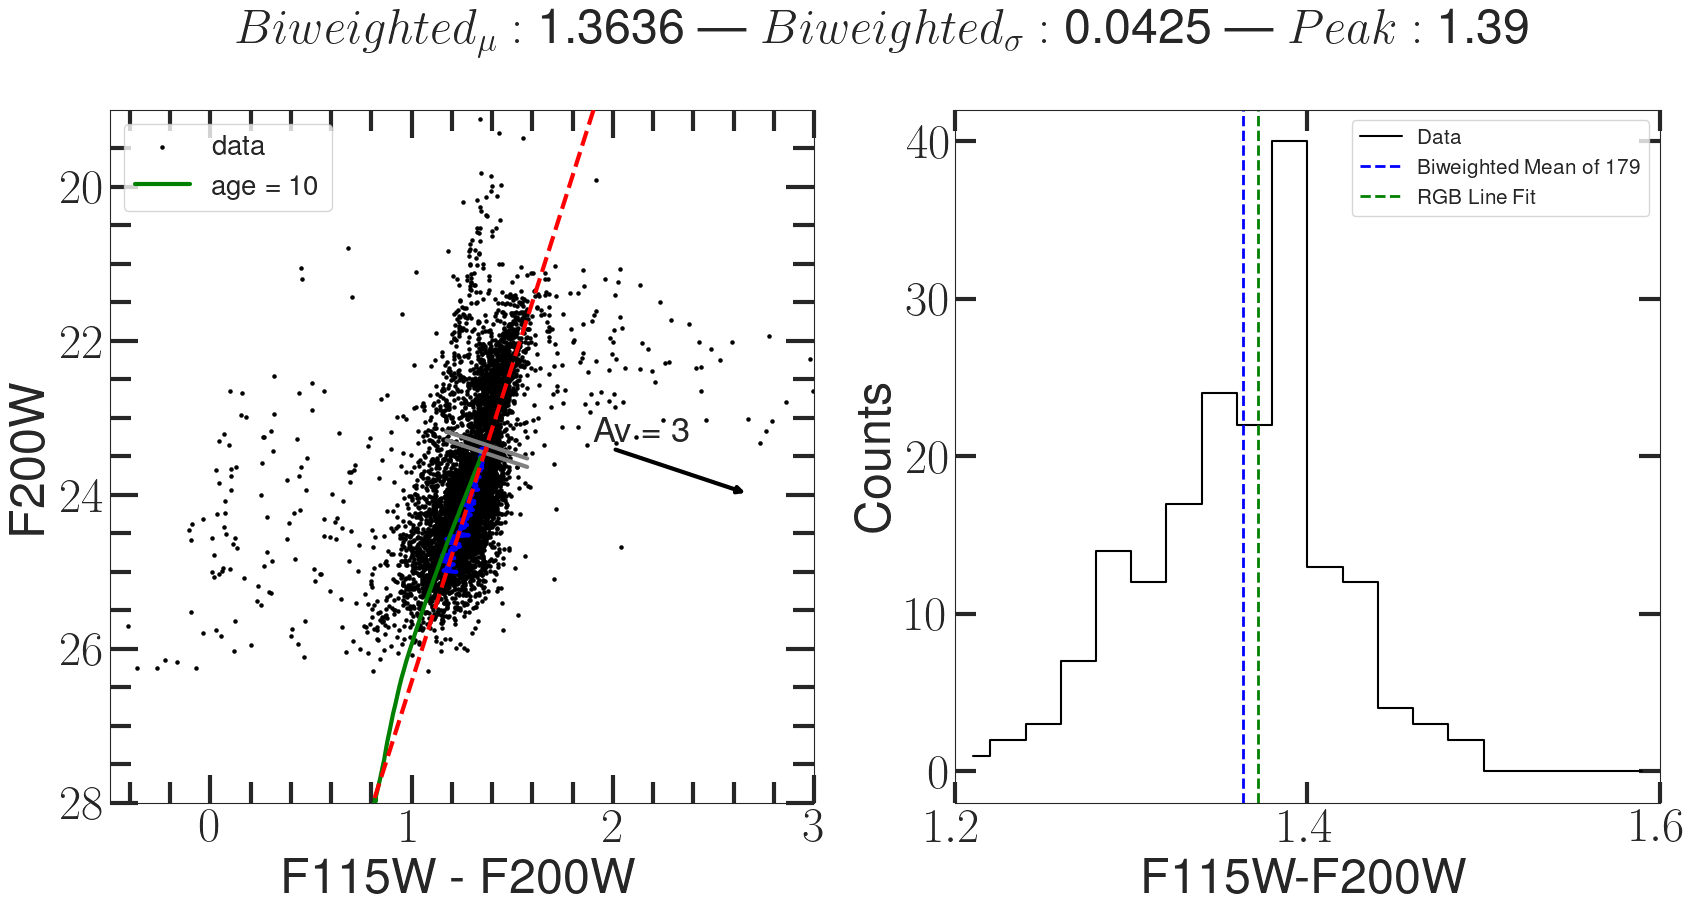

In [262]:
filt1 = 'f115w'
filt2 = 'f200w'
filt3 = 'f200w'

dy= 0.1
cmd_xlo = 1.2
cmd_xhi = 1.6

tab   = Table.read('../photometry/ngc628/f115w_f200w_photometry.fits')
model_mag_err_f200w = models.Exponential1D(4.62861558e-10, 1.35545518e+00)
model_col_err = models.Exponential1D(1.01336272e-08, 1.57271500e+00)
rgb_yhi = 27
r_in  = 0
r_out = 8.9

m_range = np.random.normal(loc=0, scale=0.025,size = 100)

trgb_cols = np.zeros((len(m_range),9))*np.nan

k = 10
mss = []
for k in range(90):
    ms = []
    for i, dm in enumerate(m_range):
        dats  = []
        nx    = 15
        ny    = 6

        min_  = cmd_xlo
        max_  = cmd_xhi
        step  = 0.02

        bins  = np.arange(min_, max_, step)

        m     = bubble_f200w - bubble_f200w_crowd #grid_TRGB[k] + dm

        y_lo  = m - 0.02
        y_hi  = m + 0.081
        dats  = []
        fig, ax = plt.subplots(1,2,figsize=(20, 9))

        ra_cen  = regions_dict[f'reg_{k}']['ra']
        dec_cen = regions_dict[f'reg_{k}']['dec']
        
        ra_cen  = regions_dict[f'bubble']['ra']
        dec_cen = regions_dict[f'bubble']['dec']

        if k>=30 and k <= 60:
            rgb_yhi=25.5
        else:
            rgb_yhi=26

        _, _, dats, x_val, y_val, y_bins, model_rgb,[x_dat,y_dat] = gen_CMD_xcut(tab,filt1, filt2,filt3, 
                                                       ra_col ='ra', dec_col='dec',
                                                       ra_cen=ra_cen, dec_cen=dec_cen,
                                                       cmd=df_cmd_jwst, label_min=0, label_max=3,Av=0.19, sqr_field=False,
                                                       r_in=r_in, r_out=r_out, age=10, met=0.002,Av_y=23.4, Av_x=2,
                                                       y_lo=y_lo, y_hi=y_hi,dismod=29.83,xlims=[-0.5,3], ylims=[19,28],
                                                       dy=dy, dx=cmd_xhi-cmd_xlo,
                                                       cmd_xlo=cmd_xlo, cmd_xhi=cmd_xhi, rgb_ylo=m, rgb_yhi=25,          
                                                       fit_isochrone=False,fig=fig, ax=ax[0],s=5)
        #plt.close(fig)
        ax[0].tick_params(which='both', length=20,direction="in", bottom=True, top=True,left=True, right=True)
        ax[0].tick_params(which='minor', length=15)

        dat = dats[0][0]

        y, x = np.histogram(dat, bins=bins)

        max_bub = y.max()

        x = 0.5*(x[1:] + x[:-1])

        ax[1].step(x,y, where='mid', color='black')

        mean, median, stddev= sigma_clipped_stats(dat, sigma=2, cenfunc=biweight_location, stdfunc=biweight_scale, maxiters=10)

        p = x[y==y.max()][0]
        x_p1 = mean
        s_p1 = stddev

        ax[1].axvline(x_p1, linestyle = '--', color='blue', lw=2)
        ax[1].axvline(model_rgb(m), linestyle = '--', color='green', lw=2)

        title = ''
        title += r"$Biweighted_{\mu}:$ " + f"{np.round(x_p1,4)} | "
        title += r'$Biweighted_{\sigma}:$ ' + f"{np.round(s_p1,4)}"
        title += r' | $Peak :$' + f' {np.round(p,4)}\n'

        ax[1].set_title(title, fontsize=35,x=-0.1)
        ax[1].set_ylabel('Counts', fontsize=35)

        ax[1].set_xlabel(f'{filt1.upper()}-{filt2.upper()}')

        init = models.Gaussian1D()
        fit = fitting.LevMarLSQFitter()
        ridge = []
        ridge_std = []
        for dat in dats:
            data = dat[0]
            bins = np.arange(data.min(), data.max(), 0.02)
            y,x = np.histogram(data,bins=bins)
            x = 0.5*(x[1:] + x[:-1])

            model = fit(init,x,y)
            ridge.append(model.mean.value)
            ridge_std.append(model.stddev.value)

        init = models.Linear1D()
        fit = fitting.LinearLSQFitter()
        model_ridge = fit(init, y_val,ridge)
        #ax[1].axvline(model_ridge(m), linestyle = '--', color='orange', lw=2)

        for _ in range(1000):
            x = np.random.normal(x_dat, model_col_err(y_dat))
            y = np.random.normal(y_dat, model_mag_err_f200w(y_dat))

            y_n, x_n = running_avg(y, x, 100)

            ind = ~np.isnan(x_n)
            x_bin = x_n[ind]
            y_bin = y_n[ind]

            init = models.Linear1D()
            fit = fitting.LinearLSQFitter()
            model_iso = fit(init, y_bin, x_bin)
            ms.append(model_iso(m))

        trgb_cols[i,0] = p   # Peak
        trgb_cols[i,1] = mean # Bi weighted mean
        trgb_cols[i,2] = np.mean(dats[0][0]) # Mean color
        trgb_cols[i,3] = median # Bi weighted median

        trgb_cols[i,4] = model_ridge(m) # Gaussian Mean
        trgb_cols[i,5] = np.median(ridge_std)
        trgb_cols[i,6] = len(dats[0][0])
        trgb_cols[i,7] = model_rgb(m)
        trgb_cols[i,8] = model_rgb.slope.value

        ax[1].legend(['Data',f'Biweighted Mean of {len(dats[0][0])}','RGB Line Fit','Ridge Fit'], fontsize=15)
        #fig.savefig(f"TRGBv2/reg_10_color.png")
        ax[1].tick_params(which='both', length=15,direction="in", bottom=True, top=True,left=True, right=True,width=3)
        ax[1].tick_params(which='minor', length=8,width=3)
        ax[1].set_xlim(cmd_xlo,cmd_xhi)
        #plt.close(fig)
        break
        
    mss.append(ms)
    break

In [264]:
trgb_cols[0]

array([ 1.39000000e+00,  1.36357143e+00,  1.35705587e+00,  1.37000000e+00,
        1.36741170e+00,  4.73374450e-02,  1.79000000e+02,  1.37169769e+00,
       -1.21671639e-01])

In [ ]:
np.percentile(ms,[16,84]) - np.nanmedian(ms)

In [ ]:
len(ms)

In [ ]:
plt.hist(ms)

In [ ]:
np.nanmedian(trgb_cols[:,7])

In [ ]:
np.percentile(trgb_cols[:,7],[16,84]) - np.nanmedian(trgb_cols[:,7])

In [ ]:
ll = len(dats[0][0][(dats[0][0]>=model_ridge(m)-0.05) & (dats[0][0]<= model_ridge(m)+0.05)])

In [ ]:
ll

In [ ]:
filt1 = 'f115w'
filt2 = 'f200w'
filt3 = 'f200w'

dy= 0.1
cmd_xlo = 1.2
cmd_xhi = 1.6

tab   = Table.read('../photometry/ngc628/f115w_f200w_photometry.fits')
trgb_cols = np.zeros((90,9))*np.nan

rgb_yhi = 27
r_in  = 0
r_out = 24

for k in range(90):

    dats  = []
    nx    = 15
    ny    = 6

    min_  = cmd_xlo
    max_  = cmd_xhi
    step  = 0.02

    bins  = np.arange(min_, max_, step)

    m     = grid_TRGB[k]
    if np.isnan(m):
        continue

    y_lo  = m - 0.02
    y_hi  = m + 0.081
    dats  = []
    fig, ax = plt.subplots(1,2,figsize=(20, 9))

    ra_cen  = regions_dict[f'reg_10']['ra']
    dec_cen = regions_dict[f'reg_10']['dec']

    if k>=30 and k <= 60:
        rgb_yhi=25.5
    else:
        rgb_yhi=26
       
    _, _, dats, x_val, y_val, y_bins, model_rgb = gen_CMD_xcut(tab,filt1, filt2,filt3, 
                                                   ra_col ='ra', dec_col='dec',
                                                   ra_cen=ra_cen, dec_cen=dec_cen,
                                                   cmd=df_cmd_jwst, label_min=0, label_max=3,Av=0.19, sqr_field=True,
                                                   r_in=r_in, r_out=r_out, age=10, met=0.002,Av_y=23.4, Av_x=2,
                                                   y_lo=y_lo, y_hi=y_hi,dismod=29.82,xlims=[-0.5,3], ylims=[19,28],
                                                   dy=dy, dx=cmd_xhi-cmd_xlo,
                                                   cmd_xlo=cmd_xlo, cmd_xhi=cmd_xhi, rgb_ylo=m, rgb_yhi=rgb_yhi,          
                                                   fit_isochrone=False,fig=fig, ax=ax[0],s=5)
    #plt.close(fig)
    ax[0].tick_params(which='both', length=20,direction="in", bottom=True, top=True,left=True, right=True)
    ax[0].tick_params(which='minor', length=15)

    dat = dats[0][0]

    y, x = np.histogram(dat, bins=bins)

    max_bub = y.max()

    x = 0.5*(x[1:] + x[:-1])

    ax[1].step(x,y, where='mid', color='black')

    mean, median, stddev= sigma_clipped_stats(dat, sigma=2, cenfunc=biweight_location, stdfunc=biweight_scale, maxiters=10)

    p = x[y==y.max()][0]
    x_p1 = mean
    s_p1 = stddev

    ax[1].axvline(x_p1, linestyle = '--', color='blue', lw=2)
    ax[1].axvline(model_rgb(m), linestyle = '--', color='green', lw=2)

    title = ''
    title += r"$Biweighted_{\mu}:$ " + f"{np.round(x_p1,4)} | "
    title += r'$Biweighted_{\sigma}:$ ' + f"{np.round(s_p1,4)}"
    title += r' | $Peak :$' + f' {np.round(p,4)}\n'

    ax[1].set_title(title, fontsize=35,x=-0.1)
    ax[1].set_ylabel('Counts', fontsize=35)

    ax[1].set_xlabel(f'{filt1.upper()}-{filt2.upper()}')

    init = models.Gaussian1D()
    fit = fitting.LevMarLSQFitter()
    ridge = []
    ridge_std = []
    for dat in dats:
        data = dat[0]
        bins = np.arange(data.min(), data.max(), 0.02)
        y,x = np.histogram(data,bins=bins)
        x = 0.5*(x[1:] + x[:-1])

        model = fit(init,x,y)
        ridge.append(model.mean.value)
        ridge_std.append(model.stddev.value)

    init = models.Linear1D()
    fit = fitting.LinearLSQFitter()
    model_ridge = fit(init, y_val,ridge)
    #ax[1].axvline(model_ridge(m), linestyle = '--', color='orange', lw=2)

    trgb_cols[k,0] = p   # Peak
    trgb_cols[k,1] = mean # Bi weighted mean
    trgb_cols[k,2] = np.mean(dats[0][0]) # Mean color
    trgb_cols[k,3] = median # Bi weighted median

    trgb_cols[k,4] = model_ridge(m) # Gaussian Mean
    trgb_cols[k,5] = np.median(ridge_std)
    ll = len(dats[0][0][(dats[0][0]>=model_rgb(m)-0.05) & (dats[0][0]<= model_rgb(m)+0.05)])
    trgb_cols[k,6] = ll
    trgb_cols[k,7] = model_rgb(m)
    trgb_cols[k,8] = model_rgb.slope.value

    ax[1].legend(['Data',f'Biweighted Mean of {len(dats[0][0])}','RGB Line Fit','Ridge Fit'], fontsize=15)
    fig.savefig(f"TRGB/reg_{k}_color.png")
    ax[1].tick_params(which='both', length=15,direction="in", bottom=True, top=True,left=True, right=True,width=3)
    ax[1].tick_params(which='minor', length=8,width=3)
    ax[1].set_xlim(cmd_xlo,cmd_xhi)
    plt.close(fig)
    break

In [ ]:
dy

In [ ]:
t = trgb_cols.reshape(15,6,9)

In [ ]:
trgb_nstars

In [ ]:
#np.save('TRGB/trgb_cols_JK.npy', trgb_cols.reshape(15,6,9))

In [ ]:
#np.save('TRGB/trgb_nstars.npy', trgb_nstars)

In [304]:
trgb_cols = np.load('TRGB/trgb_cols_JK.npy')
trgb_nstars = np.load('TRGB/trgb_nstars.npy')

Text(0, 0.5, 'Bi-weighted')

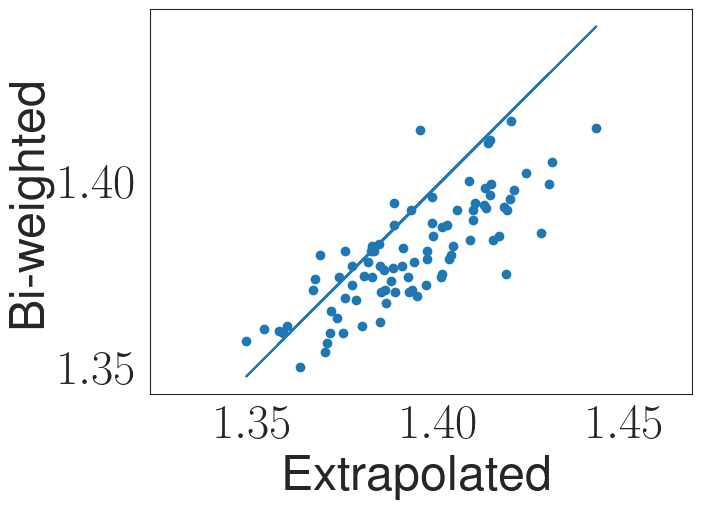

In [43]:
x = trgb_cols[:,:,7].ravel()
y = trgb_cols[:,:,3].ravel()

plt.scatter(x,y)
plt.plot(x,x)
plt.axis('equal')
plt.xlabel('Extrapolated')
plt.ylabel('Bi-weighted')

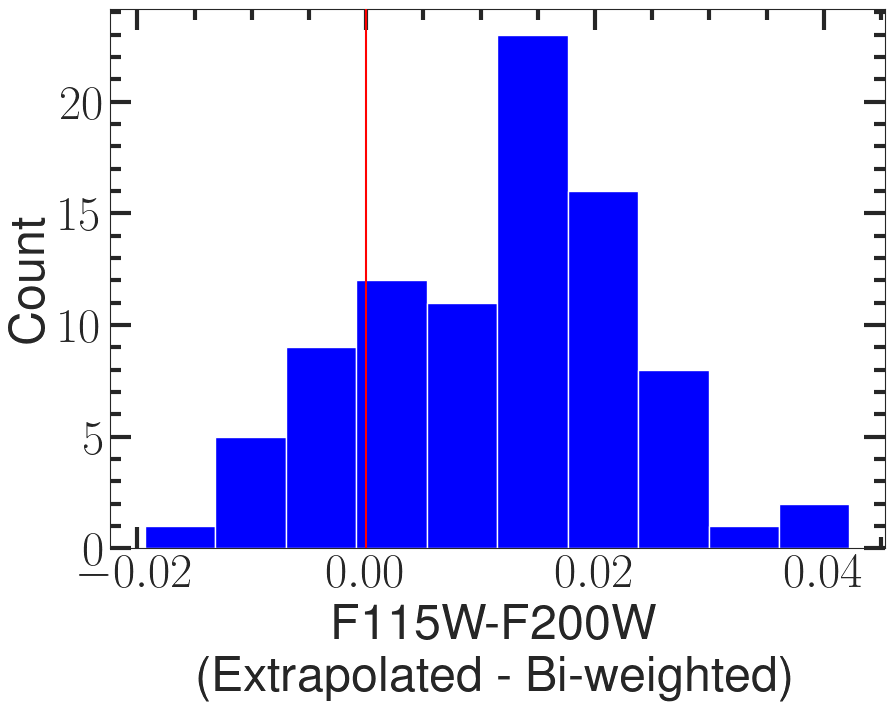

In [45]:
x = trgb_cols[:,:,7].ravel()
y = trgb_cols[:,:,7].ravel()-trgb_cols[:,:,3].ravel()

fig, ax = plt.subplots(figsize=(10,7))
ax.hist(y, color='blue')
ax.set_xlabel('F115W-F200W\n (Extrapolated - Bi-weighted)')
ax.set_ylabel("Count")


ax.xaxis.set_major_locator(AutoLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_major_locator(AutoLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', length=15,direction="in", bottom=True, top=True,left=True, right=True,width=3)
ax.tick_params(which='minor', length=8,width=3)
ax.minorticks_on()

ax.axvline(0, zorder=300, color='red')

Text(0, 0.5, 'Extrapolated - Bi-weighted')

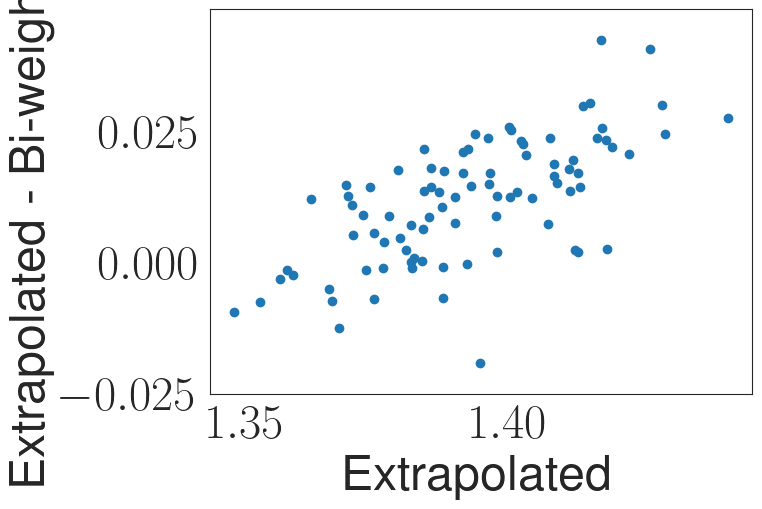

In [124]:
x = trgb_cols[:,:,7].ravel()
y = x-trgb_cols[:,:,3].ravel()

plt.scatter(x,y)
plt.axis('equal')
plt.xlabel('Extrapolated')
plt.ylabel('Extrapolated - Bi-weighted')

Text(0, 0.5, 'Extrapolated - Bi-weighted')

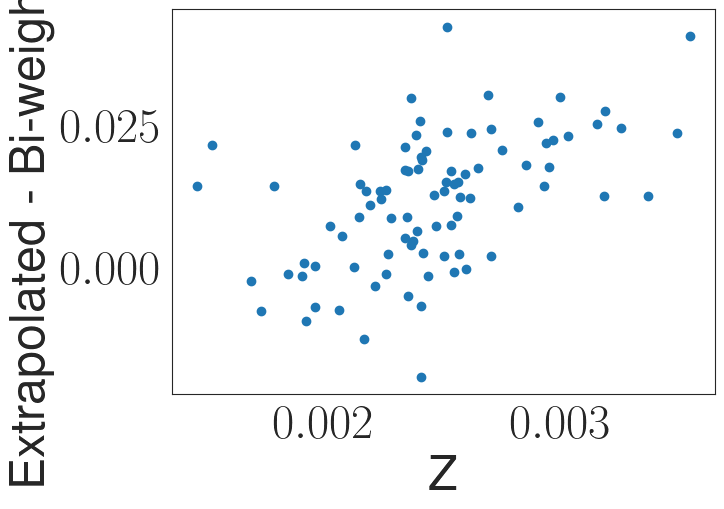

In [125]:
x = met_map.ravel() #trgb_cols[:,:,7].ravel()
y = trgb_cols[:,:,7].ravel()-trgb_cols[:,:,3].ravel()

plt.scatter(x,y)
plt.xlabel('Z')
plt.ylabel('Extrapolated - Bi-weighted')

In [ ]:
bubble_col = np.array([ 1.39000000e+00,  1.36431481e+00,  1.36055307e+00,  1.36950000e+00,
        1.36882959e+00,  4.97432983e-02,  1.79000000e+02,  1.37797784e+00,
       -1.30524740e-01])

In [ ]:
plt.figure(figsize=(32,10))
img = plt.imshow(1/trgb_cols.T[8], cmap='jet')
cb = plt.colorbar(img, pad=0.02)
cb.set_label('RGB slope')
plt.xlabel('x')
plt.ylabel('y')

In [ ]:
plt.figure(figsize=(32,10))
img = plt.imshow(trgb_cols.T[7], cmap='jet')
cb = plt.colorbar(img, pad=0.02)
cb.set_label('TRGB Color: RGB Line Fitting')
plt.xlabel('x')
plt.ylabel('y')

In [ ]:
plt.figure(figsize=(32,10))
img = plt.imshow(trgb_cols.T[3], cmap='jet')
cb = plt.colorbar(img, pad=0.02)
cb.set_label('TRGB Color: Median')
plt.xlabel('x')
plt.ylabel('y')

In [ ]:
bubble_col_crowd

In [ ]:
model_mag_err_f200w(23.372)

In [ ]:
np.nanmedian(trgb_f200w_err_p), np.nanmedian(trgb_f200w_err_m)

In [367]:
bubble_f200w_crowd

0.045999999999999375

In [363]:
np.sqrt(0.01**2+ 0.02**3 + 0.03**2 + 0.04**2 + (0.19*0.044)**2 )

0.05174832944163512

In [362]:
np.sqrt(0.008**2 + 0.008**2 + 0.004**2)

0.012

In [364]:
bubble_f200w_crowd_err_p

0.013999999999999346

In [365]:
bubble_f200w_crowd_err_m

0.017160000000000508

In [366]:
bubble_col_crowd_err_p

0.008079999999998089

In [32]:
bubble_f200w     = 23.372 
bubble_col = 1.36950 

In [198]:
bubble_f200w_crowd, bubble_col_crowd

(0.045999999999999375, 0.010999999999998344)

In [52]:
bubble_f200w

23.418

In [302]:
model_mag_err_f200w = models.Exponential1D(4.62861558e-10, 1.35545518e+00)
model_col_err = models.Exponential1D(1.01336272e-08, 1.57271500e+00)

bubble_f200w     = 23.372 + bubble_f200w_crowd
bubble_col = 1.36950 + bubble_col_crowd
                            # (MC+bin+smooth + Photometric error) + Crowding                   
bubble_f200w_err_p = np.sqrt(0.025**2         + bubble_f200w_crowd_err_p**2 )
bubble_f200w_err_m = np.sqrt(0.025**2         + bubble_f200w_crowd_err_m**2 )

bubble_col_err_p = np.sqrt(0.0084**2           + bubble_col_crowd_err_p**2)
bubble_col_err_m = np.sqrt(0.0085**2           + bubble_col_crowd_err_m**2)

trgb_f200w_mag = np.array([[23.476, 23.477, 23.493, 23.467, 23.513, 23.471],
                           [23.467, 23.605, 23.510, 23.516, 23.453, 23.491],
                           [23.468, 23.666, 23.686, 23.461, 23.439, 23.499],
                           [23.478, 23.443, 23.515, 23.391, 23.466, 23.443],
                           [23.481, 23.502, 23.473, 23.440, 23.452, 23.449],
                           [23.421, 23.460, 23.446, 23.356, 23.308, 23.396],
                           [23.424, 23.408, 23.357, 23.250, 23.353, 23.316],
                           [23.554, 23.411, np.nan, np.nan, 23.281, 23.358],
                           [23.421, 23.335, 23.298, 23.314, 23.442, 23.450],
                           [23.350, 23.455, 23.438, 23.361, 23.449, 23.381],
                           [23.559, 23.445, 23.419, 23.377, 23.363, 23.460],
                           [23.428, 23.475, 23.475, 23.427, 23.477, 23.488],
                           [23.495, 23.425, 23.550, 23.442, 23.443, 23.473],
                           [23.4460, 23.459, 23.526, 23.472, 23.54, 23.425],
                           [23.526, 23.589, 23.541, 23.486, 23.486, 23.540]])

trgb_f200w_err_p = np.array([[0.0018, 0.0072, 0.0045, 0.0098, 0.0049, 0.0093],
                             [0.0009, 0.0030, 0.0067, 0.0046, 0.0033, 0.0055],
                             [0.0029, 0.0028, 0.0031, 0.0033, 0.0134, 0.0171],
                             [0.0019, 0.0081, 0.0016, 0.0046, 0.0027, 0.0046],                  
                             [0.0099, 0.0011, 0.0015, 0.0045, 0.0050, 0.0019],
                             [0.0052, 0.0014, 0.0063, 0.0068, 0.0049, 0.0032],
                             [0.0056, 0.0118, 0.0041, 0.0167, 0.0018, 0.0089],
                             [0.0033, 0.0033, np.nan, np.nan, 0.0048, 0.0210],
                             [0.0121, 0.0012, 0.0045, 0.0008, 0.0054, 0.0125],
                             [0.0098, 0.0020, 0.0086, 0.0012, 0.0023, 0.0047],
                             [0.0072, 0.0037, 0.0027, 0.0078, 0.0068, 0.0027],
                             [0.0030, 0.0063, 0.0012, 0.0071, 0.0127, 0.0045],
                             [0.0064, 0.0043, 0.0016, 0.0086, 0.0019, 0.0017],
                             [0.0026, 0.0037, 0.0026, 0.0048, 0.0064, 0.0030],
                             [0.0045, 0.0021, 0.0056, 0.0033, 0.0047, 0.0087]])

trgb_f200w_err_m = np.array([[0.0119, 0.0041, 0.0018, 0.0023, 0.0028, 0.0106],
                             [0.0013, 0.0052, 0.0024, 0.0085, 0.0013, 0.0051],
                             [0.0044, 0.0082, 0.0031, 0.0017, 0.0039, 0.0150],
                             [0.0012, 0.0199, 0.0108, 0.0061, 0.0138, 0.0246],
                             [0.008,  0.0026, 0.0025, 0.0050, 0.0021, 0.0050],
                             [0.0022, 0.0057, 0.0103, 0.0028, 0.0044, 0.0021],
                             [0.0028, 0.0030, 0.0040, 0.0034, 0.0019, 0.0104],
                             [0.0133, 0.0054, np.nan, np.nan, 0.0019, 0.0233],
                             [0.0023, 0.0012, 0.0121, 0.0024, 0.0082, 0.0018],
                             [0.0088, 0.0073, 0.0042, 0.0020, 0.0022, 0.0049],
                             [0.0016, 0.0013, 0.0018, 0.0077, 0.0146, 0.0014],
                             [0.0017, 0.0018, 0.0019, 0.0012, 0.0101, 0.0045],
                             [0.0014, 0.0014, 0.0016, 0.0037, 0.0013, 0.0020],
                             [0.0032, 0.0012, 0.0012, 0.0117, 0.0024, 0.0013],
                             [0.0027, 0.0014, 0.0064, 0.0025, 0.0035, 0.0065]])
                          
                         #   MC     +  (bin+smooth)       +   Crowding                   + Photometric error  
trgb_f200w_err_p = np.sqrt(0.015**2 + trgb_f200w_err_p**2 + f200w_err_p.reshape(15,6)**2 )
trgb_f200w_err_m = np.sqrt(0.015**2 + trgb_f200w_err_m**2 + f200w_err_m.reshape(15,6)**2 )


trgb_col_err_p = np.sqrt(f115w_f200w_err_p**2 + 0.007**2)
trgb_col_err_m = np.sqrt(f115w_f200w_err_m**2 + 0.007**2)

In [266]:
np.nanmedian(trgb_f200w_err_p), np.nanmedian(trgb_f200w_err_m)

(0.0167503412710388, 0.017177891831043318)

In [267]:
np.nanmedian(f200w_err_p), np.nanmedian(f200w_err_m)

(0.004999999999999005, 0.004999999999999005)

In [268]:
np.nanmedian(trgb_col_err_p), np.nanmedian(trgb_col_err_m)

(0.008062257748297505, 0.008231253183959904)

In [269]:
mags_f115w = []
mags_f200w = []
slopes = []
ages__ = [9.6,9.8,10.00001]
for age in ages__:
    mags1 = []
    mags2 = []
    slope = []
    for met in [0.001,0.002,0.003,0.004]:
        df = df_cmd_jwst[ (df_cmd_jwst['logAge']==age) & (df_cmd_jwst['Zini']==met) & (df_cmd_jwst['label']==3)]
        x = df['F115Wmag'] - df['F200Wmag']
        y = df['F200Wmag'] + 29.83
        ind = y<26
        init = models.Linear1D()
        fit = fitting.LinearLSQFitter()
        model = fit(init,y[ind],x[ind])
        y_n = np.linspace(23,24)
        x_n = model(y_n)
        
        t = df[df['logL']==df['logL'].max()]
        mag = t['F115Wmag'].values[0] 
        mags1.append(mag)
        mag = t['F200Wmag'].values[0]    
        mags2.append(mag)
        slope.append(1/model.slope)
        
    mags_f115w.append(mags1)
    mags_f200w.append(mags2)
    slopes.append(slope)
    
mags_f115w = np.array(mags_f115w)
mags_f200w = np.array(mags_f200w)
slopes = np.array(slopes)

In [270]:
df_cmd_jwst_basti = pd.read_csv('../data/isochrones_master/cmd_jwst_basti_v2.csv')

In [271]:
np.unique(np.round(df_cmd_jwst_basti['Zini'],5))

array([0.0001 , 0.0002 , 0.0005 , 0.00099, 0.00197, 0.00311, 0.004  ,
       0.00614])

In [272]:
mags_f115w_basti = []
mags_f200w_basti = []
slopes = []
ages__ = [9.6,9.8,10.0000]
for age in ages__:
    mags1 = []
    mags2 = []
    slope = []
    for met in [0.001,0.002,0.003,0.004]:
        df = df_cmd_jwst_basti[(np.round(df_cmd_jwst_basti['logAge'],1)==age) 
                               & (np.round(df_cmd_jwst_basti['Zini'],3)==met)]
        #print(np.median(df['Zini']))
        x = df['F115W'] - df['F200W']
        y = df['F200W'] + 29.79
        ind = y<26
        init = models.Linear1D()
        fit = fitting.LinearLSQFitter()
        model = fit(init,y[ind],x[ind])
        y_n = np.linspace(23,24)
        x_n = model(y_n)
        
        t = df[df['log(L/Lo)']==df['log(L/Lo)'].max()]
        mag = t['F115W'].values[0] 
        mags1.append(mag)
        mag = t['F200W'].values[0]    
        mags2.append(mag)
        slope.append(1/model.slope)
        
    mags_f115w_basti.append(mags1)
    mags_f200w_basti.append(mags2)
    slopes.append(slope)
    
mags_f115w_basti = np.array(mags_f115w_basti)
mags_f200w_basti = np.array(mags_f200w_basti)
slopes = np.array(slopes)

In [286]:
Av = 0.19
ind = -1
y_r = mags_f200w[ind] + Av_dict['f200w']*Av
x_r = (mags_f115w[ind] + Av_dict['f115w']*Av) - (mags_f200w[ind] +  Av_dict['f200w']*Av)

y_10 = np.arange(y_r.min(),y_r.max(),0.0001)
ind = np.argsort(y_r)
x_10 = np.interp(y_10,y_r[ind],x_r[ind])

met_10 = np.interp(x_10,x_r, [0.001,0.002,0.003,0.004])

x_c = bubble_col
y_c = bubble_f200w
d = np.arange(29,30,0.0001).reshape(-1,1)
 
r = np.sqrt( (x_10 - x_c)**2 + (y_10 + d - y_c)**2)

dismod = d[np.argwhere(r==r.min())[0][0]][0]
met = met_10[np.argwhere(r==r.min())[0][1]]

dismod_parsec = dismod
z_parsec = met

In [290]:
dismod_parsec = dismod
z_parsec = met

In [291]:
np.round(dismod_parsec,4), np.round(z_parsec,4)

(29.8066, 0.0026)

In [280]:
Av = 0.19
ind = -1
y_r = mags_f200w_basti[ind] + Av_dict['f200w']*Av
x_r = (mags_f115w_basti[ind] + Av_dict['f115w']*Av) - (mags_f200w_basti[ind] +  Av_dict['f200w']*Av)

y_10 = np.arange(y_r.min(),y_r.max(),0.0001)
ind = np.argsort(y_r)
x_10 = np.interp(y_10,y_r[ind],x_r[ind])

met_10 = np.interp(x_10,x_r, [0.00099, 0.00197, 0.00311, 0.004])

x_c = bubble_col
y_c = bubble_f200w

d = np.arange(29,30,0.0001).reshape(-1,1)
 
r = np.sqrt( (x_10 - x_c)**2 + (y_10 + d - y_c)**2)

dismod = d[np.argwhere(r==r.min())[0][0]][0]
met = met_10[np.argwhere(r==r.min())[0][1]]

dismod_basti = dismod
z_basti = met

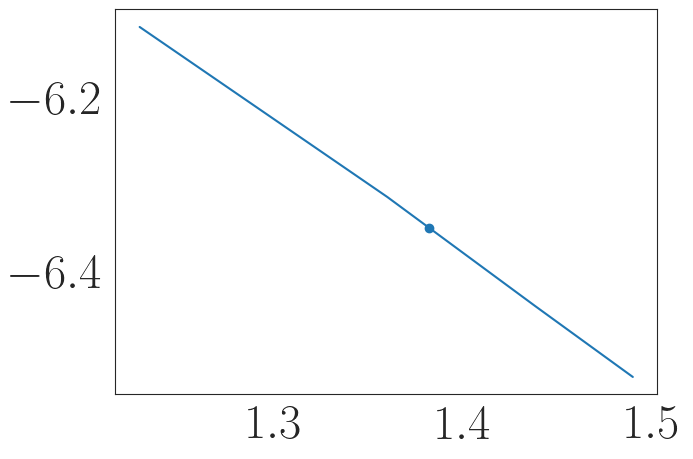

In [285]:
plt.plot(x_10,y_10)
plt.scatter(x_c,y_c-dismod_basti)

In [282]:
np.round(dismod_basti,4), np.round(z_basti,4)

(29.7683, 0.0023)

In [61]:
bubble_f200w_err_m, bubble_f200w_err_p

(0.03032269117344332, 0.028653097563788487)

In [62]:
bubble_col_err_m, bubble_col_err_p

(0.012077516300962378, 0.01165531638352083)

In [63]:
dismods = []
mets = []
Av = 0.19
ind = -1

col_p = bubble_col_err_p
col_m = bubble_col_err_m

mag_p =  bubble_f200w_err_p
mag_m =  bubble_f200w_err_m

for i in [-mag_m, mag_p]:
    for j in [-col_m, col_p]:

        y_r = mags_f200w[ind] + Av_dict['f200w']*Av
        x_r = mags_f115w[ind] + Av_dict['f115w']*Av - (mags_f200w[ind] +  Av_dict['f200w']*Av)

        x_10 = np.arange(1.3,1.5,0.001)
        y_10 = np.interp(x_10,x_r,y_r)
        met_10 = np.interp(x_10,x_r, [0.001,0.002,0.003,0.004])

        x_c = bubble_col + j 
        y_c = bubble_f200w + i
        d = np.arange(29,30,0.0001).reshape(-1,1)

        r = np.sqrt( (x_10 - x_c)**2 + (y_10 + d - y_c)**2)

        dismod = d[np.argwhere(r==r.min())[0][0]][0]
        met = met_10[np.argwhere(r==r.min())[0][1]]
        
        dismods.append(dismod)
        mets.append(met)
        
dismods = np.array(dismods)
mets = np.array(mets)

In [64]:
np.round(dismods[dismods<dismod_parsec].min()-dismod_parsec,4), np.round(dismods[dismods>=dismod_parsec].max()-dismod_parsec,4)

(-0.0539, 0.0504)

In [65]:
np.round(mets[mets<z_parsec].min()-z_parsec,5),np.round(mets[mets>=z_parsec].max()-z_parsec,5), 

(-0.0002, 0.00019)

In [66]:
dismods = []
mets = []
for i in [-mag_m, mag_p]:
    for j in [-col_m, col_p]:
        Av = 0.19
        ind = -1
        y_r = mags_f200w_basti[ind] + Av_dict['f200w']*Av
        x_r = mags_f115w_basti[ind] + Av_dict['f115w']*Av - (mags_f200w_basti[ind] +  Av_dict['f200w']*Av)

        x_10 = np.arange(1.3,1.5,0.001)
        y_10 = np.interp(x_10,x_r,y_r)
        met_10 = np.interp(x_10,x_r, [0.00099, 0.00197, 0.00311, 0.004])

        x_c = bubble_col + j 
        y_c = bubble_f200w + i
        d = np.arange(29,30,0.0001).reshape(-1,1)

        r = np.sqrt( (x_10 - x_c)**2 + (y_10 + d - y_c)**2)

        dismod = d[np.argwhere(r==r.min())[0][0]][0]
        met = met_10[np.argwhere(r==r.min())[0][1]]
        
        dismods.append(dismod)
        mets.append(met)
    
dismods = np.array(dismods)
mets = np.array(mets)

In [67]:
np.round(dismods[dismods<dismod_basti].min()-dismod_basti,4), np.round(dismods[dismods>=dismod_basti].max()-dismod_basti,4)

(-0.0496, 0.0479)

In [68]:
np.round(mets[mets<z_basti].min()-z_basti,5), np.round(mets[mets>=z_basti].max()-z_basti,5)

(-0.00017, 0.00017)

In [69]:
yy, xx = np.mgrid[0:5,0:15]

In [70]:
z = (xx-7)**2 + (yy-2)**2

In [71]:
nx = 15
ny = 6

k=0
reg_arr = np.zeros((15,6))
for i in range(nx):
    for j in range(ny):
        reg_arr[i,j]=k
        k+=1

In [72]:
x, y = np.mgrid[0:15,0:6]/1.0
x -= 7
y-= 2.5
x *= 24
y *= 24


r = np.sqrt(x**2 + y**2)

r = np.where(x<0,r,r)*43/1e3

In [73]:
np.nanmedian(f115w_f200w_err_p)

0.003999999999997894

In [74]:
np.median(xerr_p), np.median(xerr_m) 

NameError: name 'xerr_p' is not defined

0.017177891831043318 0.0167503412710388 0.008062257748297505 0.008231253183959904


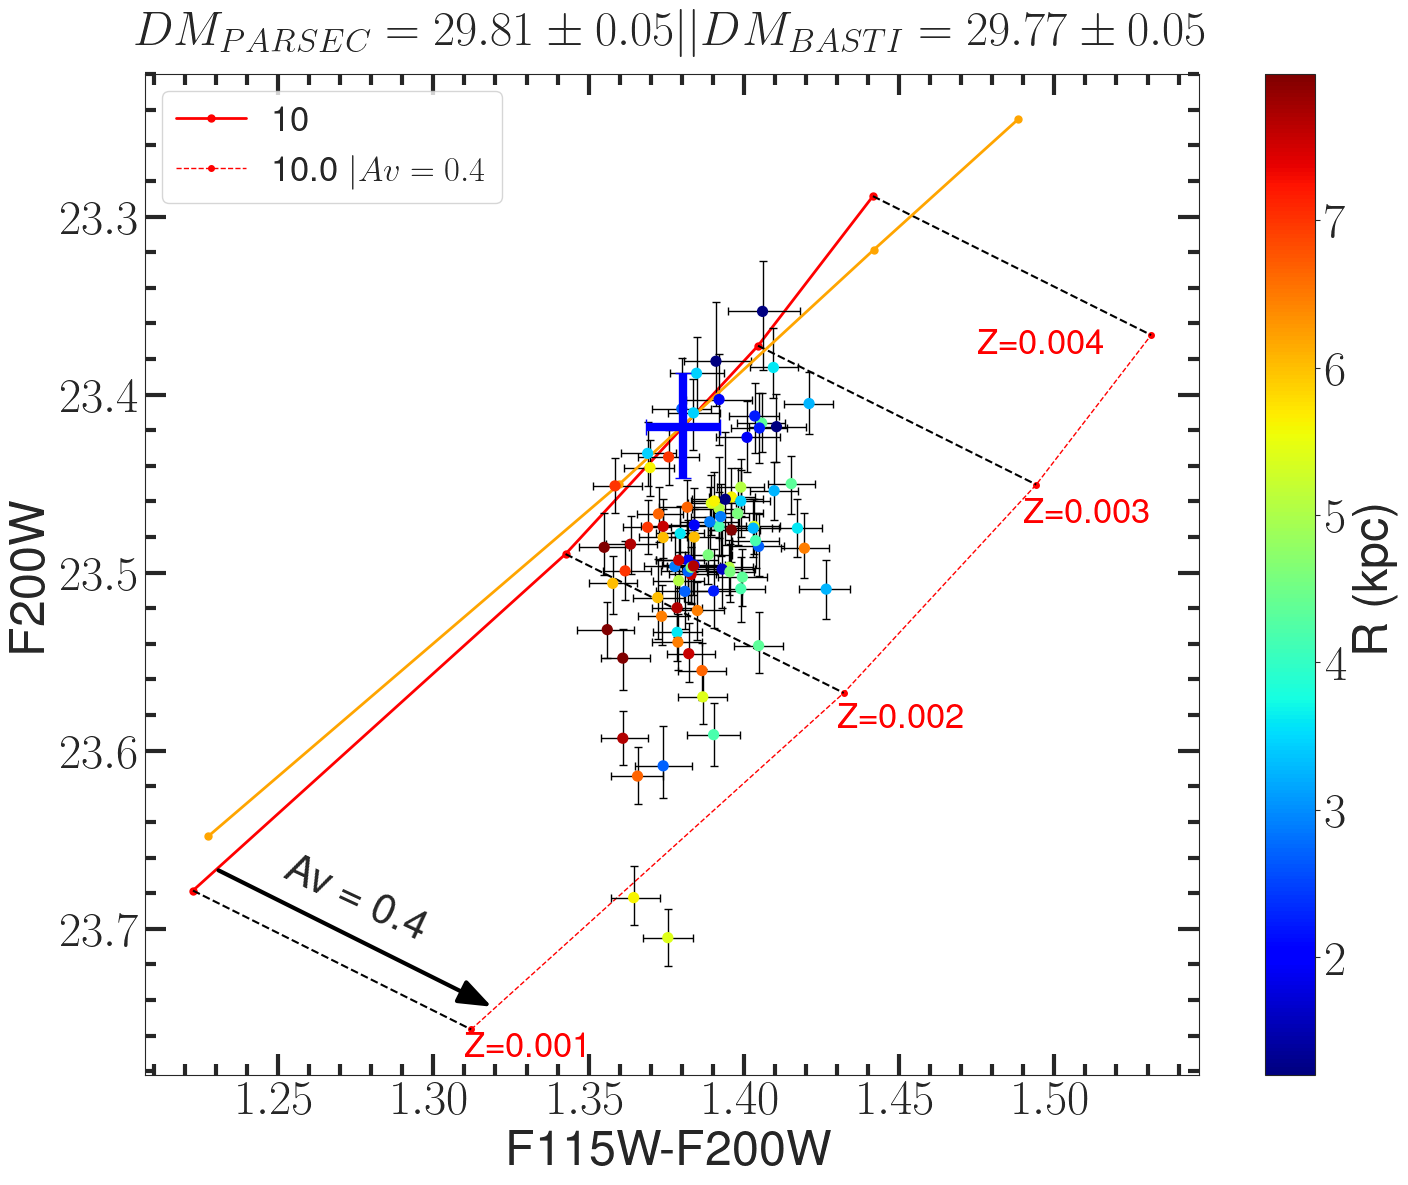

In [85]:
x, y = np.mgrid[0:15,0:6]/1.0
x -= 7
y-= 2.5
x *= 24
y *= 24

r = np.sqrt(x**2 + y**2)

r = np.where(x<0,r,r)

fig, ax = plt.subplots(figsize=(17,13))

dismod = dismod_parsec
Av = 0.19

Av_t = 0.0

x = (mags_f115w[-1] + Av_dict['f115w']*(Av+Av_t)) - (mags_f200w[-1] + Av_dict['f200w']*(Av+Av_t))
y = mags_f200w[-1] + Av_dict['f200w']*(Av+Av_t) + dismod


x1 = x
y1 = y
ax.plot(x,y, '-ro',
       linewidth=2, markersize=5)

Av_t = 0.4

x = (mags_f115w.T + Av_dict['f115w']*(Av+Av_t)) - (mags_f200w.T + Av_dict['f200w']*(Av+Av_t))
y = mags_f200w.T + Av_dict['f200w']*(Av+Av_t) + dismod

ax.plot(x[:,-1],y[:,-1], '--ro',
       linewidth=1, markersize=4, )
x2 = x[:,-1]
y2 = y[:,-1]

x_n = np.concatenate([[x1],[x2]])
y_n = np.concatenate([[y1],[y2]])

ax.plot(x_n,y_n,'--k')

Av_t = 0.
x = (mags_f115w.T + Av_dict['f115w']*(Av+Av_t)) - (mags_f200w.T + Av_dict['f200w']*(Av+Av_t))
y = mags_f200w.T + Av_dict['f200w']*(Av+Av_t) + dismod


#ax.plot(x.T,y.T, '--k',linewidth=1)

start = 0
end = 89
    
x = trgb_cols[:,:,3].ravel()[start:end+1].copy()*mask.ravel()
y = trgb_f200w_mag[:,:].ravel()[start:end+1].copy()

x += model_f115w_f200w_crowd[start:end+1]
y += model_f200w_crowd[start:end+1]
    
xerr_p = np.sqrt(f115w_f200w_err_p[start:end+1]**2 + 0.007**2)
xerr_m = np.sqrt(f115w_f200w_err_m[start:end+1]**2 + 0.007**2)
yerr_p = trgb_f200w_err_p.ravel()[start:end+1]
yerr_m = trgb_f200w_err_m.ravel()[start:end+1]

print(np.nanmedian(yerr_m), np.nanmedian(yerr_p),np.nanmedian(xerr_p),np.nanmedian(xerr_m))
#xerr_p, xerr_m = np.nanmean(xerr_p), np.nanmean(xerr_m)
#yerr_p, yerr_m = np.nanmean(yerr_p), np.nanmean(yerr_m)

xerr = [xerr_p, xerr_m]
yerr = [yerr_m, yerr_p]

ax.errorbar(x,y,xerr=xerr, yerr=yerr, color='black',elinewidth=1,ls='None',
           markersize=3, capsize=3)
img = ax.scatter(x,y,c=r.ravel()[start:end+1]*44.8e-3, s=50,cmap='jet',zorder=300)

cb = plt.colorbar(img,ax=ax)
cb.set_label('R (kpc)')
            
#ax.errorbar([1.23],[23.4], xerr=xerr, yerr=yerr, fmt='.r',elinewidth=2,
#             markersize=3, capsize=3)


ax.invert_yaxis()

Av_x = 1.23
Av_y = dismod-6.14

Av_ = 0.4

AF1_ =  Av_dict['f115w']*Av_
AF2_ =  Av_dict['f200w']*Av_

dx = AF1_
dy = AF2_

dx = dx-dy
ax.annotate('', xy=(Av_x, Av_y),
             xycoords='data',
             xytext=(Av_x+dx, Av_y+dy),
             textcoords='data',
             arrowprops=dict(arrowstyle= '<|-, head_width = .75, head_length=2',
                             color='black',
                             lw=3,
                             ls='-',
                             )
           )

ax.annotate(f'Av = {Av_}', xy=(Av_x+0.02, Av_y+0.04),
             xycoords='data',
             #xytext=(Av_x+dx, Av_y+dy),
             textcoords='data', rotation=-25, fontsize=30
           )
"""
for n,i,j in zip(reg_arr.ravel().astype(int)[start:end+1],x,y):
    if n in [7]:
        j-=0.02
    if n in [0,6, 71, 82]:
        i-=0.0025
        
    if n in [14, 79, 32, 72,74]:
        i-=0.006
    ax.annotate(f'{n}', xy=(i- 0.001, j+0.015), 
             xycoords='data', fontsize=20, color = 'black', zorder= 100,
           )"""

x = bubble_col
y = bubble_f200w

xerr = [[bubble_col_err_m],[bubble_col_err_p]]
yerr = [[bubble_f200w_err_m],[bubble_f200w_err_p]]

ax.errorbar([x],[y],xerr=xerr,yerr=yerr, color='blue',elinewidth=6,
            markersize=4, capsize=6, zorder=300)

Av = 0.19
r_ind = -1
y_r = mags_f200w[r_ind] + Av_dict['f200w']*Av + dismod
x_r = mags_f115w[r_ind] + Av_dict['f115w']*Av - (mags_f200w[r_ind] +  Av_dict['f200w']*Av)

#ax.plot(x_r, y_r,'--k',)

ax.xaxis.set_major_locator(AutoLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())

ax.yaxis.set_major_locator(AutoLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', length=15,direction="in", bottom=True, top=True,left=True, right=True, width=3)
ax.tick_params(which='minor', length=8, width=3)

ax.annotate('Z=0.001',(1.34-0.03,dismod-6.035), color='red', fontsize=25)
ax.annotate('Z=0.002',(1.46-0.03,dismod-6.22), color='red', fontsize=25)
ax.annotate('Z=0.003',(1.52-0.03,dismod-6.335), color='red', fontsize=25)
ax.annotate('Z=0.004',(1.56-0.085,dismod- 6.43), color='red', fontsize=25)
#ax.set_xlim(1.21,1.55)
#ax.set_ylim(23.72,23.2)


#######
#BaSTI#
#######

dismod2 =dismod_basti
Av = 0.19
Av_t = 0 

x = (mags_f115w_basti[-1] + Av_dict['f115w']*(Av+Av_t)) - (mags_f200w_basti[-1] + Av_dict['f200w']*(Av+Av_t))
y = mags_f200w_basti[-1] + Av_dict['f200w']*(Av+Av_t) + dismod2

x1 = x
y1 = y
ax.plot(x,y, '-o', color='orange',
       linewidth=2, markersize=5)


ax.set_xlabel('F115W-F200W')
ax.set_ylabel('F200W')
ax.set_title('$DM_{PARSEC} = ' + f'{np.round(dismod,2)} ' + r'\pm0.05 || DM_{BASTI} = '
             + f'{np.round(dismod2,2)}'+ r'\pm0.05 $',y=1.02)
ax.legend(['10',r'10.0 $| Av=0.4$'], fontsize=25)

In [347]:
np.round(np.sqrt(0.01**2 + 0.02**2 + 0.03**2 + 0.04**2),2)

0.05

In [ ]:
(29.95-29.83)

In [ ]:
c.shape

In [ ]:
dismod = 29.86
dmpc = np.round(10*10**(dismod/5)/1e6,3)
dmpc_dx = dmpc*np.arctan(np.deg2rad(1/3600))*1e6

d = 10*10**((dismod+np.array([-0.09,0.09,]))/5)/1e6

dismod, dmpc, dmpc_dx, d-dmpc

In [239]:
dismod = dismod_parsec
dmpc = np.round(10*10**(dismod/5)/1e6,3)
dmpc_dx = dmpc*np.arctan(np.deg2rad(1/3600))*1e6

d = 10*10**((dismod+np.array([-0.09,0.09,]))/5)/1e6

dismod, dmpc, dmpc_dx, d-dmpc

(29.80649999999812,
 9.147,
 44.34590741074181,
 array([-0.37093159,  0.3875456 ]))

In [74]:
dismod = dismod_basti
dmpc = np.round(10*10**(dismod/5)/1e6,3)
dmpc_dx = dmpc*np.arctan(np.deg2rad(1/3600))*1e6

d = 10*10**((dismod+np.array([-0.09,0.1,]))/5)/1e6

dmpc, dmpc_dx, d-dmpc

(8.984, 43.55566111053946, array([-0.36454116,  0.42362505]))

In [75]:
ind = 70

x_c = trgb_cols[:,:,7].ravel()[ind] + r_model_f115w_f200w_crowd(r.ravel()[ind])
y_c = trgb_f200w_mag[:,:].ravel()[ind] + r_model_f200w_crowd(r.ravel()[ind]) 

In [76]:
k = 0
nx = 15
ny = 6
dismod = dismod_parsec
Av_map = np.zeros((nx,ny))*np.nan
met_map = np.zeros((nx,ny))*np.nan

x, y = np.mgrid[0:15,0:6]/1.0
x -= 7
y-= 2.5
x *= 24
y *= 24

r = np.sqrt(x**2 + y**2)

for i in range(15):
    for j in range(6):

        Av = 0.19
        ind_ = -1
        y_r = mags_f200w[ind_] + Av_dict['f200w']*Av + dismod
        x_r = mags_f115w[ind_] + Av_dict['f115w']*Av - (mags_f200w[ind_] +  Av_dict['f200w']*Av)

        x_10 = np.arange(1.2,1.5,0.0001)
        y_10 = np.interp(x_10,x_r,y_r)
        met_10 = np.interp(x_10,x_r, [0.001,0.002,0.003,0.004])

        x_c = trgb_cols[:,:,3].ravel()[k] + model_f115w_f200w_crowd[k] 
        y_c = trgb_f200w_mag[:,:].ravel()[k] + model_f200w_crowd[k]
        
        if np.isnan(x_c) or np.isnan(y_c) :
            print(k)
            k+=1
            continue

        Av_ = np.arange(-1,0.7, 0.001).reshape(-1,1)

        dx = (Av_dict['f115w']-Av_dict['f200w'])*Av_
        dy = Av_dict['f200w']*Av_

        rd = np.sqrt( (x_10 - (x_c-dx))**2 + (y_10 - (y_c-dy))**2)

        av1, z1 = Av_[np.argwhere(rd==rd.min())[0][0]][0], met_10[np.argwhere(rd==rd.min())[0][1]]
        
        Av_map[i, j] = av1
        met_map[i, j] = z1
        
        k+=1

44
45


In [77]:
k = 0
nx = 15
ny = 6
dismod = dismod_basti
Av_map_basti = np.zeros((nx,ny))*np.nan
met_map_basti = np.zeros((nx,ny))*np.nan

for i in range(15):
    for j in range(6):

        Av = 0.19
        ind_ = -1
        y_r = mags_f200w_basti[ind_] + Av_dict['f200w']*Av + dismod
        x_r = mags_f115w_basti[ind_] + Av_dict['f115w']*Av - (mags_f200w_basti[ind_] +  Av_dict['f200w']*Av)

        x_10 = np.arange(1.2,1.5,0.001)
        y_10 = np.interp(x_10,x_r,y_r)
        met_10 = np.interp(x_10,x_r, [0.00099, 0.00197, 0.00311, 0.004])

        x_c = trgb_cols[i,j,3] + model_f115w_f200w_crowd[k]
        y_c = trgb_f200w_mag[i,j] + model_f200w_crowd[k]
        
        if np.isnan(x_c) or np.isnan(y_c) :
            print(k)
            k+=1
            continue

        Av_ = np.arange(-1,0.7, 0.001).reshape(-1,1)

        dx = (Av_dict['f115w']-Av_dict['f200w'])*Av_
        dy = Av_dict['f200w']*Av_

        r = np.sqrt( (x_10 - (x_c-dx))**2 + (y_10 - (y_c-dy))**2)

        av1, z1 = Av_[np.argwhere(r==r.min())[0][0]][0], met_10[np.argwhere(r==r.min())[0][1]]
        
        Av_map_basti[i, j] = av1
        met_map_basti[i, j] = z1
        
        k+=1

44
45


In [78]:
errs = np.array([[bubble_col_err_p, bubble_f200w_err_p],
                 [bubble_col_err_p, -bubble_f200w_err_m],
                 [-bubble_col_err_m, bubble_f200w_err_p],
                 [-bubble_col_err_m, -bubble_f200w_err_m]])

In [79]:
avs = []
zs = []
dismod = dismod_parsec
for i,j in errs:
    Av = 0.19
    ind_ = -1
    y_r = mags_f200w[ind_] + Av_dict['f200w']*Av + dismod
    x_r = mags_f115w[ind_] + Av_dict['f115w']*Av - (mags_f200w[ind_] +  Av_dict['f200w']*Av)

    x_10 = np.arange(1.2,1.5,0.001)
    y_10 = np.interp(x_10,x_r,y_r)
    met_10 = np.interp(x_10,x_r, [0.001,0.002,0.003,0.004])

    x_c = bubble_col + i 
    y_c = bubble_f200w + j 

    Av_ = np.arange(-1,0.7, 0.001).reshape(-1,1)

    dx = (Av_dict['f115w']-Av_dict['f200w'])*Av_
    dy = Av_dict['f200w']*Av_

    r = np.sqrt( (x_10 - (x_c-dx))**2 + (y_10 - (y_c-dy))**2)

    av1, z1 = Av_[np.argwhere(r==r.min())[0][0]][0], met_10[np.argwhere(r==r.min())[0][1]]

    avs.append(av1)
    zs.append(z1)
avs = np.array(avs)
zs = np.array(zs)

In [89]:
np.percentile(avs, [16,84]) -  np.nanmedian(avs)

array([-0.04842,  0.04946])

In [309]:
avs.max() , avs.min()

(0.08200000000000096, -0.08499999999999919)

In [310]:
zs.max() - 0.0027, 0.0027 - zs.min()

(0.000145806451612556, 0.0003219354838712614)

In [311]:
np.round(np.std(avs),4), np.round(np.std(zs),5)

(0.0596, 0.00018)

In [80]:
avs = []
zs = []
dismod = dismod_basti
for i,j in errs:
    Av = 0.19
    ind_ = -1
    y_r = mags_f200w_basti[ind_] + Av_dict['f200w']*Av + dismod
    x_r = mags_f115w_basti[ind_] + Av_dict['f115w']*Av - (mags_f200w_basti[ind_] +  Av_dict['f200w']*Av)

    x_10 = np.arange(1.2,1.5,0.001)
    y_10 = np.interp(x_10,x_r,y_r)
    met_10 = np.interp(x_10,x_r, [0.001,0.002,0.003,0.004])


    x_c = bubble_col + i 
    y_c = bubble_f200w  + j

    Av_ = np.arange(-1,0.7, 0.001).reshape(-1,1)

    dx = (Av_dict['f115w']-Av_dict['f200w'])*Av_
    dy = Av_dict['f200w']*Av_

    r = np.sqrt( (x_10 - (x_c-dx))**2 + (y_10 - (y_c-dy))**2)

    av1, z1 = Av_[np.argwhere(r==r.min())[0][0]][0], met_10[np.argwhere(r==r.min())[0][1]]

    avs.append(av1)
    zs.append(z1)

avs = np.array(avs)
zs = np.array(zs)

In [84]:
np.round(np.std(avs),4), np.round(np.std(zs),5)

(0.0632, 0.00016)

In [81]:
np.save('../data/Av_map.npy',Av_map)

In [82]:
np.nanmin(Av_map)

-0.07799999999999918

In [83]:
mask = np.where(Av_map<-0.04,np.nan,1)
mask_basti = np.where(Av_map_basti<-0.04,np.nan,1)

mask2 = np.where((Av_map<-0.06) |  (Av_map>0.06),np.nan,1)
mask3 = np.where((Av_map_basti<-0.06) |  (Av_map_basti>0.06),np.nan,1)


In [128]:
met_map_basti.shape

(15, 6)

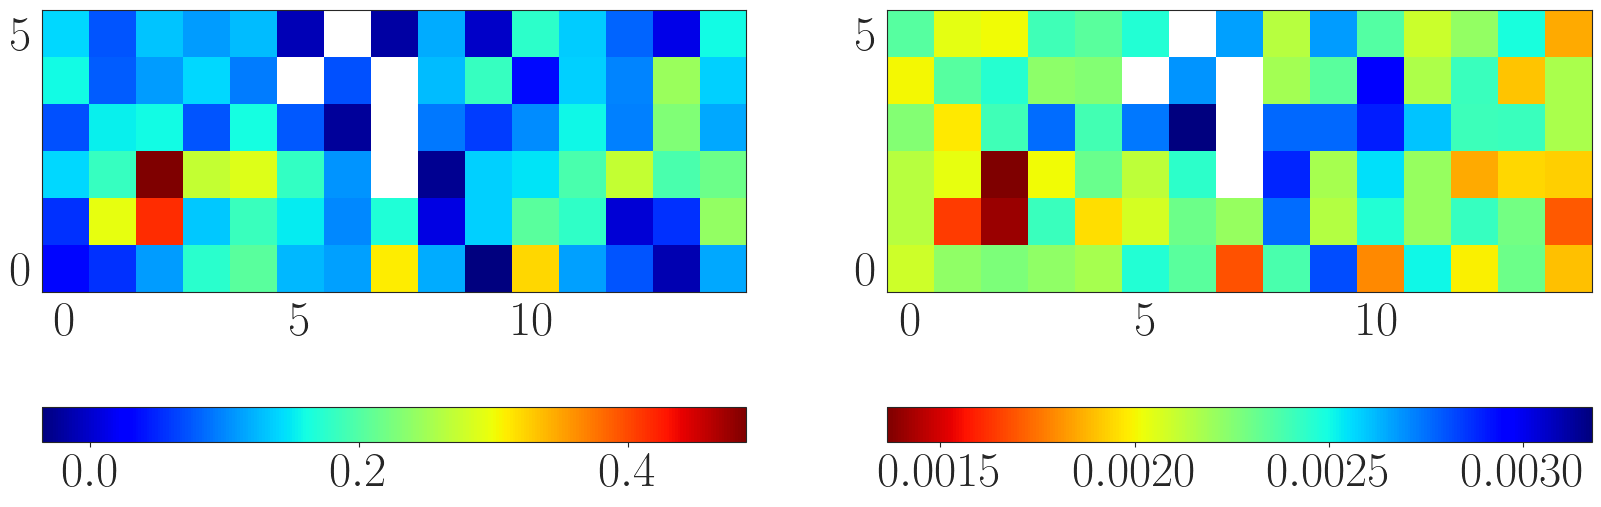

In [129]:
fig, ax = plt.subplots(1,2, figsize=(20,10))

img = ax[0].imshow(Av_map.T*mask.T, cmap='jet')
plt.colorbar(img,ax=ax[0], orientation='horizontal')
img= ax[1].imshow(met_map.T*mask.T, cmap='jet_r')
plt.colorbar(img,ax=ax[1], orientation='horizontal')

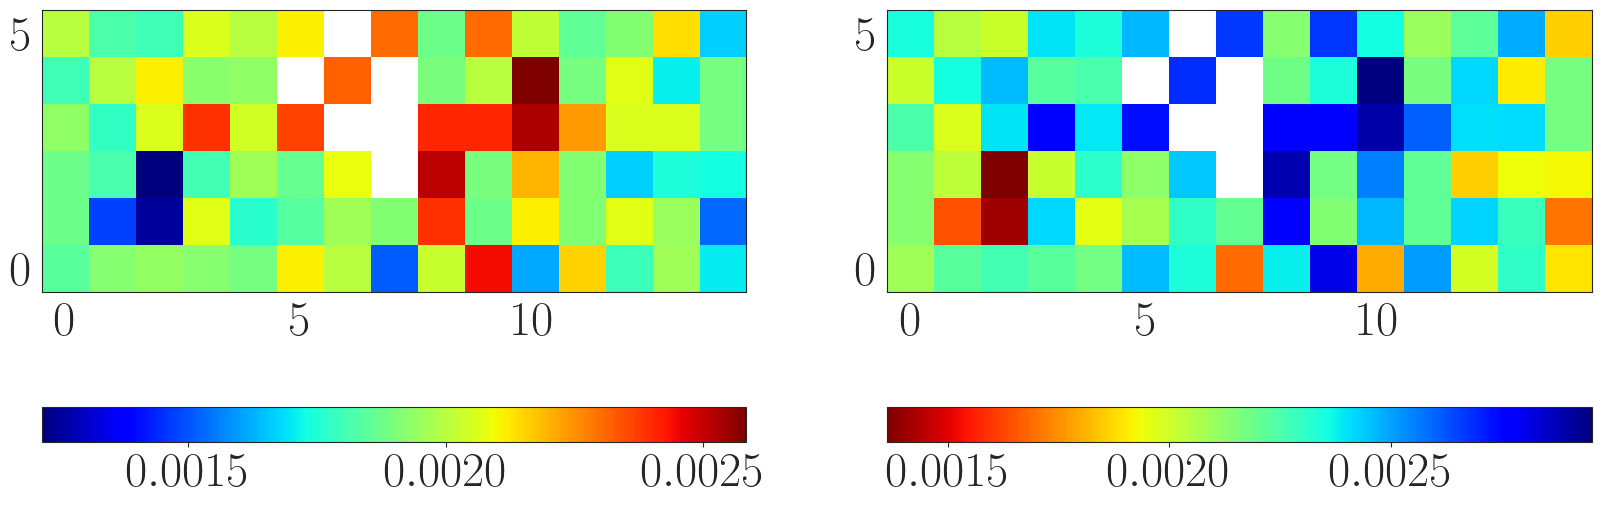

In [125]:
fig, ax = plt.subplots(1,2, figsize=(20,10))

img = ax[0].imshow(met_map_basti.T*mask_basti.T, cmap='jet')
plt.colorbar(img,ax=ax[0], orientation='horizontal')
img= ax[1].imshow(met_map.T*mask_basti.T, cmap='jet_r')
plt.colorbar(img,ax=ax[1], orientation='horizontal')

In [330]:
df = pd.read_csv('../data/Z_5Gyr.csv', header=None)

In [331]:
r.min()

12.0

In [108]:
@custom_model

def exp1d(x,x0=0,tau=1,A=1,B=0.):
    return A*np.exp(-(x+x0)/tau) + B

In [109]:
met_map[:7].ravel().shape

(42,)

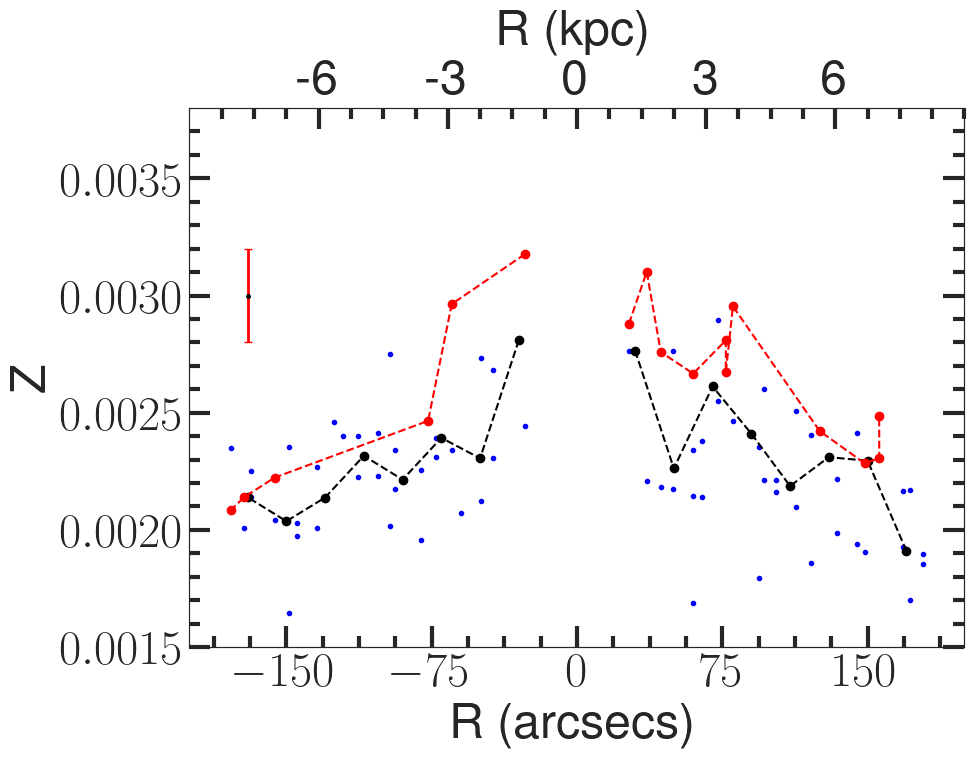

In [130]:
x, y = np.mgrid[0:15,0:6]/1.0
x -= 7
y-= 2.5
x *= 24
y *= 24

r = np.sqrt(x**2 + y**2)

fig , ax = plt.subplots(figsize=(10,7), sharex=True)
# Total

x = r.ravel()
y = (met_map*mask).ravel()
ind = ~np.isnan(y)
x = x[ind]
y = y[ind]

init = exp1d(tau=25)
fit = fitting.LevMarLSQFitter()
model = fit(init,abs(x),y)

# Left
x = r[:7].ravel()
y = (met_map*mask)[:7].ravel()
ind = ~np.isnan(y)

x = x[ind]
y = y[ind]
c = Av_map[:7].ravel()[ind]

x_new = np.arange(0,x.max()*1.1,20)
x_c = 0.5*(x_new[1:] + x_new[:-1])

y_new = []
for i in range(len(x_new)-1):
    ind = np.where((x>x_new[i]) & (x<=x_new[i+1]))
    
    y_new.append(np.median(y[ind]))

y_c = np.array(y_new)

#ax.scatter(-x,y, c=c, marker='.', cmap='seismic',vmin=0, vmax=0.2)
ax.scatter(-x,y,marker='.', color='blue')
ax.plot(-x_c,y_c, '--ok')
x_new = np.linspace(0,x.max(),1000)

init = exp1d(tau=25)
fit = fitting.LevMarLSQFitter()
model1 = fit(init,x,y)


x = r[:7].ravel()
y = (met_map*mask2)[:7].ravel()
ind = ~np.isnan(y)
x = x[ind]
y = y[ind]
ind = np.argsort(x)

x = x[ind]
y = y[ind]

ax.plot(-x,y,'--or')

#ax.plot(-x_new, model(x_new),'--r')

#Right
x = r[7:].ravel()
y = (met_map*mask)[7:].ravel()
ind = ~np.isnan(y)

x = x[ind]
y = y[ind]
c = Av_map[7:].ravel()[ind]

x_new = np.arange(0,x.max()*1.1,20)
x_c = 0.5*(x_new[1:] + x_new[:-1])

y_new = []
for i in range(len(x_new)-1):
    ind = np.where((x>x_new[i]) & (x<=x_new[i+1]))
    
    y_new.append(np.median(y[ind]))

y_c = np.array(y_new)

#img=ax.scatter(x,y, c=c, marker='.', cmap='seismic',vmin=0, vmax=0.2)
ax.scatter(x,y,marker='.', color='blue')
ax.plot(x_c,y_c, '--ok')

#plt.colorbar(img,ax=ax)

x_new = np.linspace(0,x.max(),1000)

init = exp1d(tau=25)
fit = fitting.LevMarLSQFitter()
model2 = fit(init,x,y)


x = r[7:].ravel()
y = (met_map*mask2)[7:].ravel()
ind = ~np.isnan(y)
x = x[ind]
y = y[ind]
ind = np.argsort(x)

x = x[ind]
y = y[ind]

ax.plot(x,y,'--or')

#ax.plot(x_new, model(x_new),'--r')

ax.set_ylabel('Z')
ax.errorbar(x=[-170],y=[0.003],xerr=0,yerr=0.0002, fmt='.r',elinewidth=2,
            markersize=5, capsize=3, markerfacecolor='black', markeredgecolor='black')

ax.set_xlim(-200,200)

ax.set_xticks([-150,-75,0,75,150])

ax.yaxis.set_major_locator(AutoLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', length=15,direction="in", bottom=True,left=True, right=True, top=True, width=3)
ax.tick_params(which='minor', length=8, width=3)


ax1 = ax.twiny()  # instantiate a second axes that shares the same x-axis
ax1.set_xlabel('R (kpc)',labelpad=10)  # we already handled the x-label with ax1

xticks_n = np.array([-6,-3,0,3,6])
xticks = xticks_n*1e3/45

ax1.set_xticks(xticks, xticks_n)

ax1.set_xlim(ax.get_xlim()[0],ax.get_xlim()[1])

ax1.yaxis.set_major_locator(AutoLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())

ax1.tick_params(which='both', length=15,direction="in",top=True, width=3)
ax1.tick_params(which='minor', length=8, width=3)

ax.set_xlabel('R (arcsecs)')
ax.set_ylim(0.0015,0.0038)
ax.minorticks_on()
ax1.minorticks_on()

In [ ]:
x = r.ravel()
y = (met_map).ravel()
ind = ~np.isnan(y)
x = x[ind]
y = y[ind]

taus = []
i=0
while i<1000:
    
    y_ = np.random.normal(loc=y,scale=0.0004)
    init = exp1d(tau=20)
    fit = fitting.LevMarLSQFitter()
    try:
        model = fit(init,abs(x),y_)
        taus.append(model.tau.value)
        i+=1
    except:
        pass
    

In [ ]:
np.max(taus)

In [ ]:
np.median(taus), np.std(taus)

In [ ]:
np.median(taus)*44e-3, np.std(taus)*44e-3

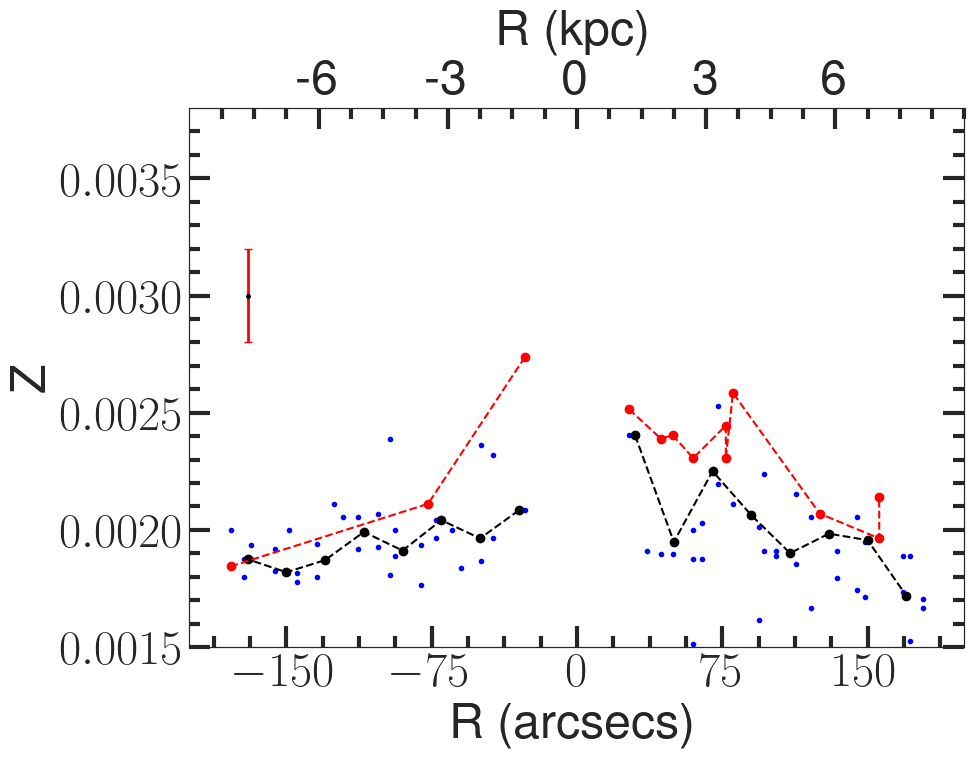

In [131]:
x, y = np.mgrid[0:15,0:6]/1.0
x -= 7
y-= 2.5
x *= 24
y *= 24

r = np.sqrt(x**2 + y**2)

fig , ax = plt.subplots(figsize=(10,7), sharex=True)
# Total

x = r.ravel()
y = (met_map_basti*mask_basti).ravel()
ind = ~np.isnan(y)
x = x[ind]
y = y[ind]

init = exp1d(tau=10)
fit = fitting.LevMarLSQFitter()
model = fit(init,abs(x),y)

# Left
x = r[:7].ravel()
y = (met_map_basti*mask_basti)[:7].ravel()
ind = ~np.isnan(y)

x = x[ind]
y = y[ind]

x_new = np.arange(0,x.max()*1.1,20)
x_c = 0.5*(x_new[1:] + x_new[:-1])

y_new = []
for i in range(len(x_new)-1):
    ind = np.where((x>x_new[i]) & (x<=x_new[i+1]))
    
    y_new.append(np.median(y[ind]))

y_c = np.array(y_new)

ax.scatter(-x,y, marker='.', color='blue')
ax.plot(-x_c,y_c, '--ok')
x_new = np.linspace(0,x.max(),1000)

init = exp1d(tau=10)
fit = fitting.LevMarLSQFitter()
model1 = fit(init,x,y)

#ax.plot(-x_new, model(x_new),'--r')

x = r[:7].ravel()
y = (met_map_basti*mask3)[:7].ravel()
ind = ~np.isnan(y)
x = x[ind]
y = y[ind]
ind = np.argsort(x)

x = x[ind]
y = y[ind]

ax.plot(-x,y,'--or')


#Right
x = r[7:].ravel()
y = (met_map_basti*mask_basti)[7:].ravel()
ind = ~np.isnan(y)

x = x[ind]
y = y[ind]

x_new = np.arange(0,x.max()*1.1,20)
x_c = 0.5*(x_new[1:] + x_new[:-1])

y_new = []
for i in range(len(x_new)-1):
    ind = np.where((x>x_new[i]) & (x<=x_new[i+1]))
    
    y_new.append(np.median(y[ind]))

y_c = np.array(y_new)

ax.scatter(x,y, marker='.', color='blue')
ax.plot(x_c,y_c, '--ok')

x_new = np.linspace(0,x.max(),1000)

init = exp1d(tau=10)
fit = fitting.LevMarLSQFitter()
model2 = fit(init,x,y)

#ax.plot(x_new, model(x_new),'--r')

x = r[7:].ravel()
y = (met_map_basti*mask3)[7:].ravel()
ind = ~np.isnan(y)
x = x[ind]
y = y[ind]
ind = np.argsort(x)

x = x[ind]
y = y[ind]

ax.plot(x,y,'--or')


ax.set_ylabel('Z')
ax.errorbar(x=[-170],y=[0.003],xerr=0,yerr=0.0002, fmt='.r',elinewidth=2,
            markersize=5, capsize=3, markerfacecolor='black', markeredgecolor='black')

ax.set_xlim(-200,200)

ax.set_xticks([-150,-75,0,75,150])

ax.yaxis.set_major_locator(AutoLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', length=15,direction="in", bottom=True,left=True, right=True, top=True, width=3)
ax.tick_params(which='minor', length=8, width=3)


ax1 = ax.twiny()  # instantiate a second axes that shares the same x-axis
ax1.set_xlabel('R (kpc)',labelpad=10)  # we already handled the x-label with ax1

xticks_n = np.array([-6,-3,0,3,6])
xticks = xticks_n*1e3/45

ax1.set_xticks(xticks, xticks_n)

ax1.set_xlim(ax.get_xlim()[0],ax.get_xlim()[1])

ax1.yaxis.set_major_locator(AutoLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())

ax1.tick_params(which='both', length=15,direction="in",top=True, width=3)
ax1.tick_params(which='minor', length=8, width=3)

ax.set_xlabel('R (arcsecs)')
ax.set_ylim(0.0015,0.0038)
ax.minorticks_on()
ax1.minorticks_on()

In [ ]:
model.tau

In [ ]:
x = r.ravel()
y = (met_map_basti).ravel()
ind = ~np.isnan(y)
x = x[ind]
y = y[ind]

taus = []
for i in range(1000):
    y_ = np.random.normal(loc=y,scale=0.00019)
    init = exp1d(tau=10)
    fit = fitting.LevMarLSQFitter()
    model = fit(init,abs(x),y_)
    
    taus.append(model.tau.value)

In [ ]:
np.median(taus)

In [ ]:
np.std(taus)

In [ ]:
8.878e6*np.tan(np.deg2rad(model.tau.value/3600))/1e3

In [ ]:
8.878e6*np.tan(np.deg2rad(10.982/3600))

In [ ]:
model

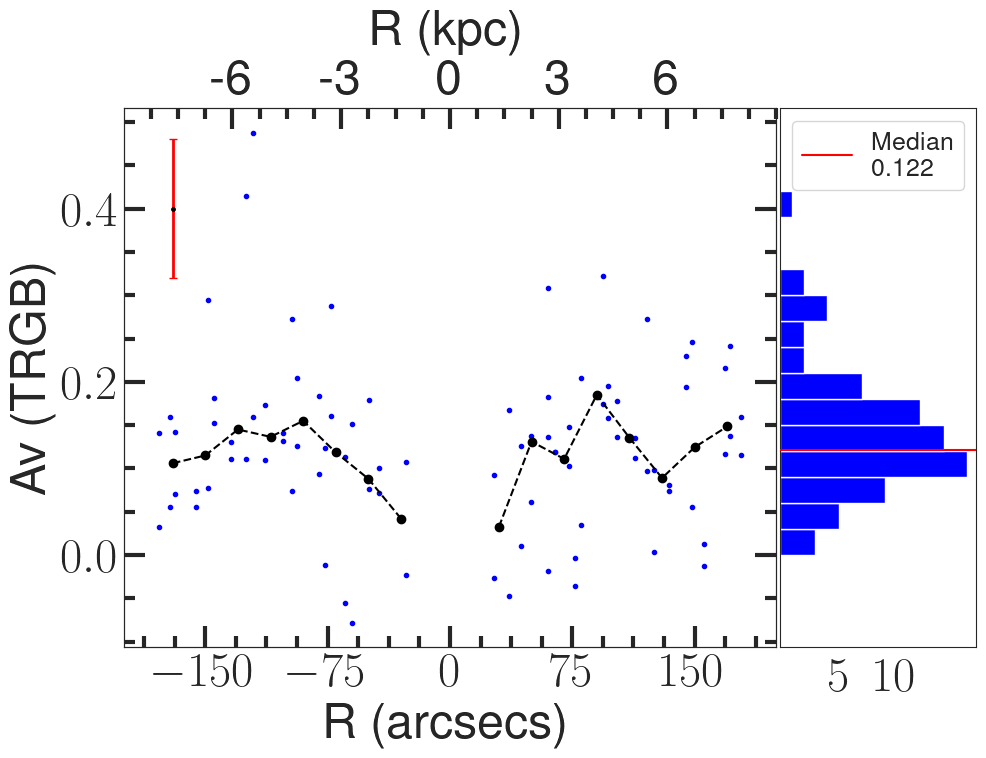

In [336]:
x, y = np.mgrid[0:15,0:6]/1.0
x -= 7
y-= 2.5
x *= 24
y *= 24

r = np.sqrt(x**2 + y**2)

fig , ax_ = plt.subplots(1,2, figsize=(11,7), sharey=True, width_ratios=[1,0.3])
ax = ax_[0]

x = r[:7].ravel()
y = (Av_map*mask)[:7].ravel()
ind = ~np.isnan(y)

x = x[ind]
y = y[ind]

x_new = np.arange(0,x.max()*1.1,20)
x_c = 0.5*(x_new[1:] + x_new[:-1])

y_new = []
for i in range(len(x_new)-1):
    ind = np.where((x>x_new[i]) & (x<=x_new[i+1]))
    
    y_new.append(np.median(y[ind]))

y_c = np.array(y_new)

ax.scatter(-x,y, marker='.', color='blue')
ax.plot(-x_c,y_c, '--ok')

#Right
x = r[7:].ravel()
y = (Av_map*mask)[7:].ravel()
ind = ~np.isnan(y)

x = x[ind]
y = y[ind]

x_new = np.arange(0,x.max()*1.1,20)
x_c = 0.5*(x_new[1:] + x_new[:-1])

y_new = []
for i in range(len(x_new)-1):
    ind = np.where((x>x_new[i]) & (x<=x_new[i+1]))
    
    y_new.append(np.median(y[ind]))

y_c = np.array(y_new)

ax.scatter(x,y, marker='.', color='blue')
ax.plot(x_c,y_c, '--ok')


ax.errorbar(x=[-170],y=[0.4],xerr=0,yerr=0.08, fmt='.r',elinewidth=2,
            markersize=5, capsize=3, markerfacecolor='black', markeredgecolor='black')

ax.set_xlabel('R (arcsecs)')
ax.set_ylabel('Av (TRGB)')
ax.set_xlim(-200,200)

ax.set_xticks([-150,-75,0,75,150])
ax1 = ax.twiny()  # instantiate a second axes that shares the same x-axis
ax1.minorticks_on()
ax1.set_xlabel('R (kpc)',labelpad=10)  # we already handled the x-label with ax1

xticks_n = np.array([-6,-3,0,3,6])
xticks = xticks_n*1e3/45

ax1.set_xticks(xticks, xticks_n)


ax1.set_xlim(ax.get_xlim()[0],ax.get_xlim()[1])

ax.yaxis.set_major_locator(AutoLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', length=15,direction="in", bottom=True,left=True, right=True, width=3)
ax.tick_params(which='minor', length=8, width=3)
ax.minorticks_on()

ax1.yaxis.set_major_locator(AutoLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())

ax1.tick_params(which='both', length=15,direction="in",top=True, width=3)
ax1.tick_params(which='minor', length=8, width=3)


data = (Av_map*mask).ravel()
bins = np.arange(0,0.5,0.03)

ax_[1].hist(data,bins=bins, orientation='horizontal', color='blue', label='_nolegend_')

m = np.median(np.where((Av_map>=0),Av_map,0))
ax_[1].axhline(m, zorder=300, color='red')
ax_[1].set_xticks([5,10])
ax_[1].legend([f'Median\n{np.round(m,3)}'], fontsize=18)
plt.subplots_adjust(wspace=0.01)

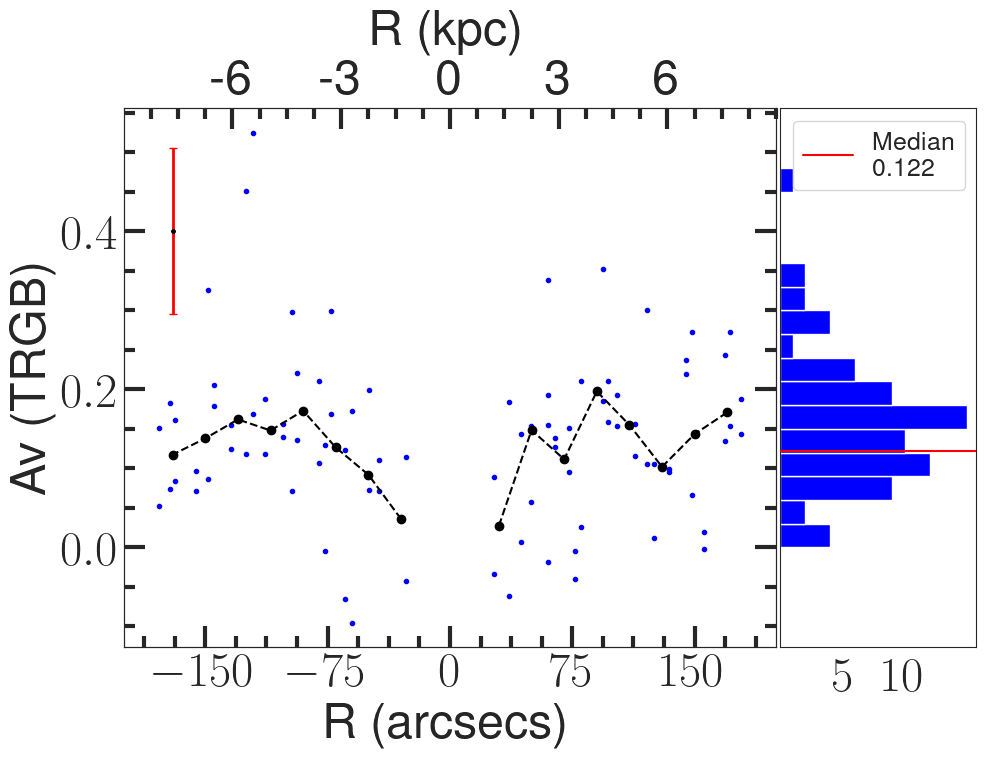

In [337]:
x, y = np.mgrid[0:15,0:6]/1.0
x -= 7
y-= 2.5
x *= 24
y *= 24

r = np.sqrt(x**2 + y**2)

fig , ax_ = plt.subplots(1,2, figsize=(11,7), sharey=True, width_ratios=[1,0.3])
ax = ax_[0]

x = r[:7].ravel()
y = (Av_map_basti*mask)[:7].ravel()
ind = ~np.isnan(y)

x = x[ind]
y = y[ind]

x_new = np.arange(0,x.max()*1.1,20)
x_c = 0.5*(x_new[1:] + x_new[:-1])

y_new = []
for i in range(len(x_new)-1):
    ind = np.where((x>x_new[i]) & (x<=x_new[i+1]))
    
    y_new.append(np.median(y[ind]))

y_c = np.array(y_new)

ax.scatter(-x,y, marker='.', color='blue')
ax.plot(-x_c,y_c, '--ok')

#Right
x = r[7:].ravel()
y = (Av_map_basti*mask)[7:].ravel()
ind = ~np.isnan(y)

x = x[ind]
y = y[ind]

x_new = np.arange(0,x.max()*1.1,20)
x_c = 0.5*(x_new[1:] + x_new[:-1])

y_new = []
for i in range(len(x_new)-1):
    ind = np.where((x>x_new[i]) & (x<=x_new[i+1]))
    
    y_new.append(np.median(y[ind]))

y_c = np.array(y_new)

ax.scatter(x,y, marker='.', color='blue')
ax.plot(x_c,y_c, '--ok')


ax.errorbar(x=[-170],y=[0.4],xerr=0,yerr=0.1049, fmt='.r',elinewidth=2,
            markersize=5, capsize=3, markerfacecolor='black', markeredgecolor='black')

ax.set_xlabel('R (arcsecs)')
ax.set_ylabel('Av (TRGB)')
ax.set_xlim(-200,200)

ax.set_xticks([-150,-75,0,75,150])
ax1 = ax.twiny()  # instantiate a second axes that shares the same x-axis
ax1.minorticks_on()
ax1.set_xlabel('R (kpc)',labelpad=10)  # we already handled the x-label with ax1

xticks_n = np.array([-6,-3,0,3,6])
xticks = xticks_n*1e3/45

ax1.set_xticks(xticks, xticks_n)


ax1.set_xlim(ax.get_xlim()[0],ax.get_xlim()[1])

ax.yaxis.set_major_locator(AutoLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', length=15,direction="in", bottom=True,left=True, right=True, width=3)
ax.tick_params(which='minor', length=8, width=3)
ax.minorticks_on()

ax1.yaxis.set_major_locator(AutoLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())

ax1.tick_params(which='both', length=15,direction="in",top=True, width=3)
ax1.tick_params(which='minor', length=8, width=3)


data = (Av_map_basti*mask).ravel()
bins = np.arange(0,0.5,0.03)

ax_[1].hist(data,bins=bins, orientation='horizontal', color='blue', label='_nolegend_')

m = np.median(np.where((Av_map_basti>=0),Av_map,0))
ax_[1].axhline(m, zorder=300, color='red')
ax_[1].set_xticks([5,10])
ax_[1].legend([f'Median\n{np.round(m,3)}'], fontsize=18)
plt.subplots_adjust(wspace=0.01)

# **Other Metallicity**

In [267]:
hdul = fits.open('../data/MUSE/NGC0628_MAPS_native.fits')  # Open the FITS file for reading

muse_wcs = WCS(hdul[6].header)

ha = hdul[30].data
ha_err = hdul[31].data

hb = hdul[6].data
hb_err = hdul[7].data

nii = hdul[36].data
nii_err = hdul[37].data

oiii = hdul[18].data
oiii_err = hdul[19].data
sii16 = hdul[42].data
sii30 = hdul[48].data
sii = sii16 +  sii30

st_vel = hdul[2].data
st_sigma = hdul[4].data

ha_vel = hdul[32].data
ha_vel_err = hdul[33].data

ha_sigma = hdul[34].data

hdul.close()

In [268]:
ha_mask1 = ha<3*ha_err 
ha_mask2 = np.isnan(ha)
ha_mask3 = np.isnan(ha_err)
ha_mask = ha_mask1 | ha_mask2 | ha_mask3

hb_mask1 = hb<3*hb_err 
hb_mask2 = np.isnan(hb)
hb_mask3 = np.isnan(hb_err)
hb_mask = hb_mask1 | hb_mask2 | hb_mask3

In [269]:
Av_mask = ha_mask | hb_mask
Av_mask = np.where(Av_mask, np.nan,1)

In [270]:
ha_hb = ha/hb
E_B_V = 0.934*np.log(ha_hb/2.86)

Av_map_muse = 3.1*E_B_V*Av_mask

Av_map_muse = np.where(np.isinf(abs(Av_map_muse)),np.nan,Av_map_muse)

Av_muse = np.where(Av_map_muse<0,np.nan,Av_map_muse)

/tmp/ipykernel_194852/3188941267.py:1: RuntimeWarning: divide by zero encountered in divide
  ha_hb = ha/hb
/tmp/ipykernel_194852/3188941267.py:1: RuntimeWarning: invalid value encountered in divide
  ha_hb = ha/hb
/tmp/ipykernel_194852/3188941267.py:2: RuntimeWarning: divide by zero encountered in log
  E_B_V = 0.934*np.log(ha_hb/2.86)


In [271]:
n2 = nii/ha

ha_mask1 = ha<3*ha_err 
ha_mask2 = np.isnan(ha)
ha_mask3 = np.isnan(ha_err)
ha_mask = ha_mask1 | ha_mask2 | ha_mask3

nii_mask1 = nii<3*nii_err 
nii_mask2 = np.isnan(nii)
nii_mask3 = np.isnan(nii_err)
nii_mask = nii_mask1 | nii_mask2 | nii_mask3

n2_mask = nii_mask | ha_mask

n2_mask = np.where(n2_mask, np.nan,1)

oh = 8.9 + 0.57*np.log10(n2)*n2_mask

oh = np.where(np.isinf(abs(oh)),np.nan,oh)

/tmp/ipykernel_194852/1204626428.py:1: RuntimeWarning: divide by zero encountered in divide
  n2 = nii/ha
/tmp/ipykernel_194852/1204626428.py:1: RuntimeWarning: invalid value encountered in divide
  n2 = nii/ha
/tmp/ipykernel_194852/1204626428.py:17: RuntimeWarning: divide by zero encountered in log10
  oh = 8.9 + 0.57*np.log10(n2)*n2_mask


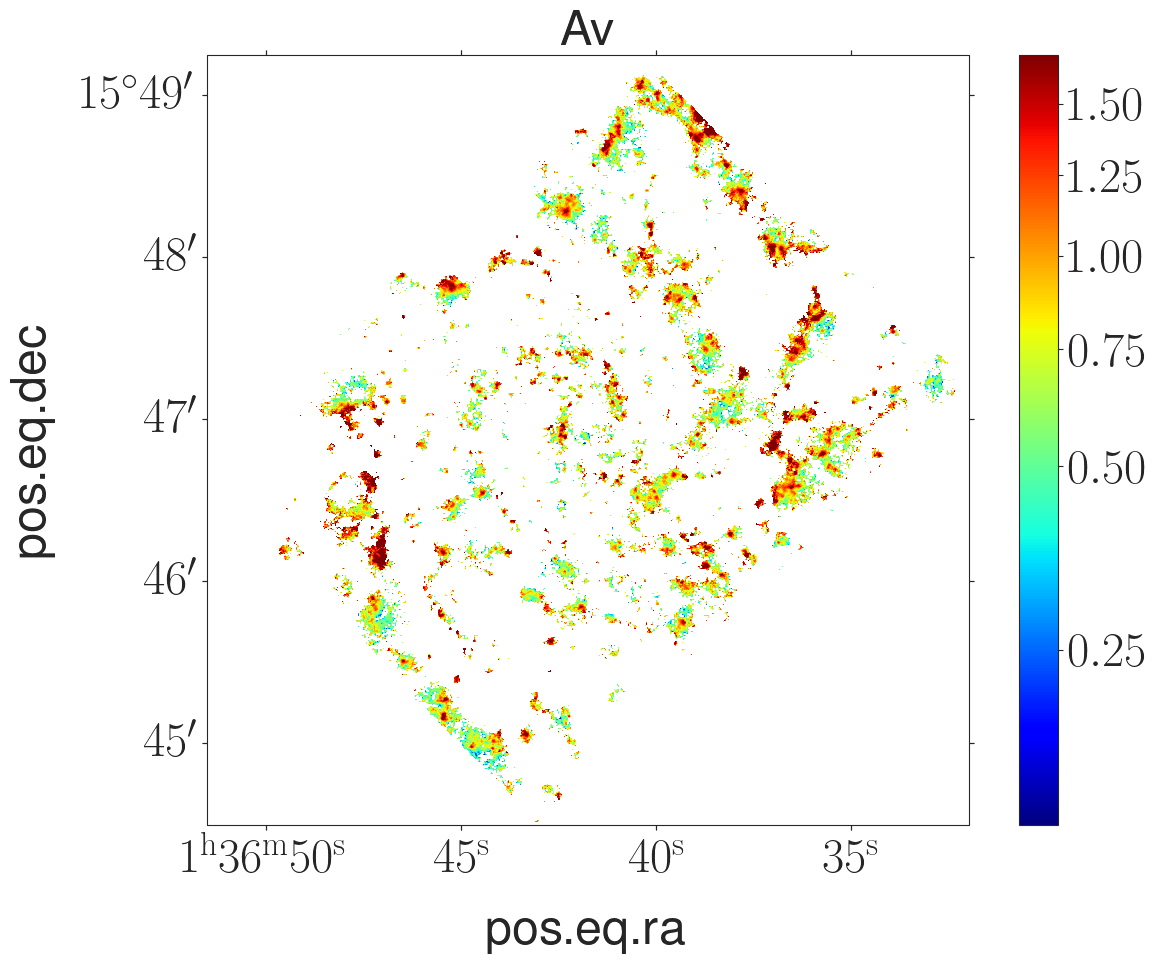

In [272]:
fig = plt.figure(figsize=(13,10))

ax = fig.add_subplot( projection=muse_wcs)
norm = simple_norm(Av_muse, 'sqrt',min_percent=10, max_percent = 93.)
img = ax.imshow(Av_muse, norm=norm, cmap='jet')
ax.set_title(r'Av')
cb = plt.colorbar(img, ax=ax)


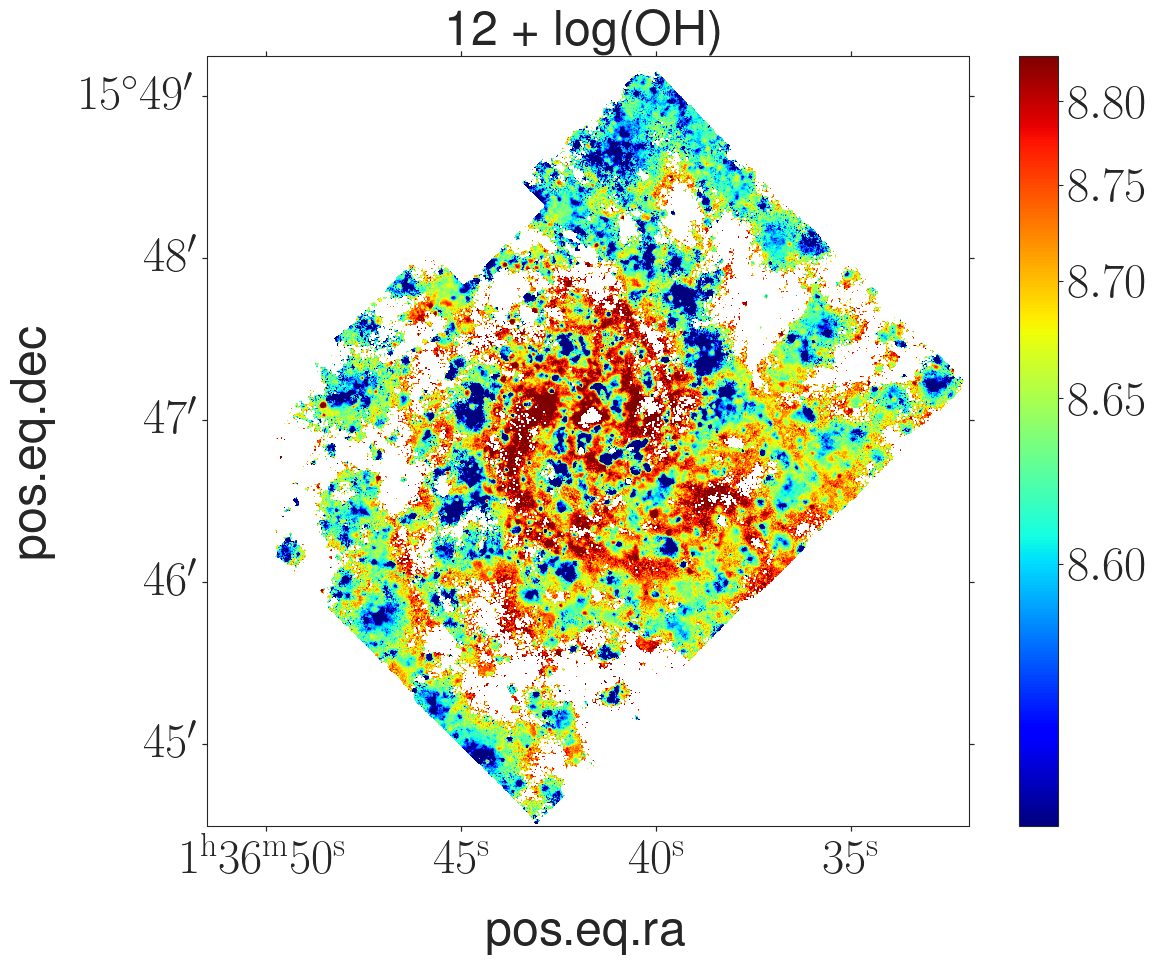

In [273]:
fig = plt.figure(figsize=(13,10))

ax = fig.add_subplot( projection=muse_wcs)
norm = simple_norm(oh, 'sqrt',min_percent=10, max_percent = 93.)
img = ax.imshow(oh, norm=norm, cmap='jet')
ax.set_title(r'12 + log(OH)')
cb = plt.colorbar(img, ax=ax)


In [274]:
x,y = np.where(~np.isnan(Av_muse))
Av_gas_values = Av_muse[x,y]
ra_muse, dec_muse = muse_wcs.array_index_to_world_values(x,y)
av_muse_tab = Table([ra_muse,dec_muse, x,y, Av_gas_values],names=['ra','dec','x','y','Av'])

In [275]:
x,y = np.where(~np.isnan(oh))
oh_gas_values = oh[x,y]
ra_muse, dec_muse = muse_wcs.array_index_to_world_values(x,y)
met_muse_tab = Table([ra_muse,dec_muse, x,y, oh_gas_values],names=['ra','dec','x','y','Z'])

In [ ]:
k = 0
nx = 15
ny = 6
Av_map_muse = np.zeros((nx,ny))*np.nan
met_map_muse = np.zeros((nx,ny))*np.nan

for i in range(15):
    for j in range(6):

        ra_cen, dec_cen = regions_dict[f'reg_{k}']['ra'], regions_dict[f'reg_{k}']['dec']
        tab_filt1 = box(av_muse_tab, 'ra','dec',ra_cen, dec_cen, 0,0,24/3600,24/3600,245)
        Av_map_muse[i, j] = np.median(tab_filt1['Av'])
        tab_filt2 = box(met_muse_tab, 'ra','dec',ra_cen, dec_cen, 0,0,24/3600,24/3600,245)
        met_map_muse[i, j] = np.median(tab_filt2['Z'])
        k+=1

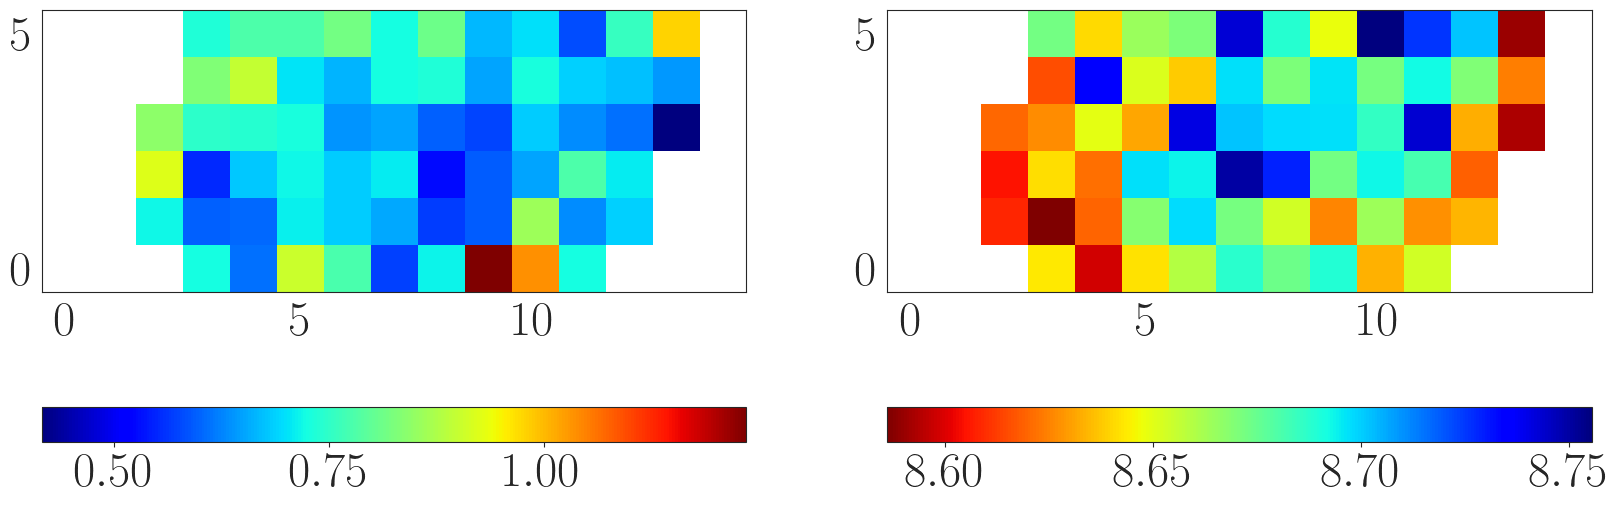

In [277]:
fig, ax = plt.subplots(1,2, figsize=(20,10))

img = ax[0].imshow(Av_map_muse.T, cmap='jet')
plt.colorbar(img,ax=ax[0], orientation='horizontal')
img= ax[1].imshow(met_map_muse.T, cmap='jet_r')
plt.colorbar(img,ax=ax[1], orientation='horizontal')

/home/avinashck/anaconda3/envs/inaoe/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/avinashck/anaconda3/envs/inaoe/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


(-10.0, 210.0)

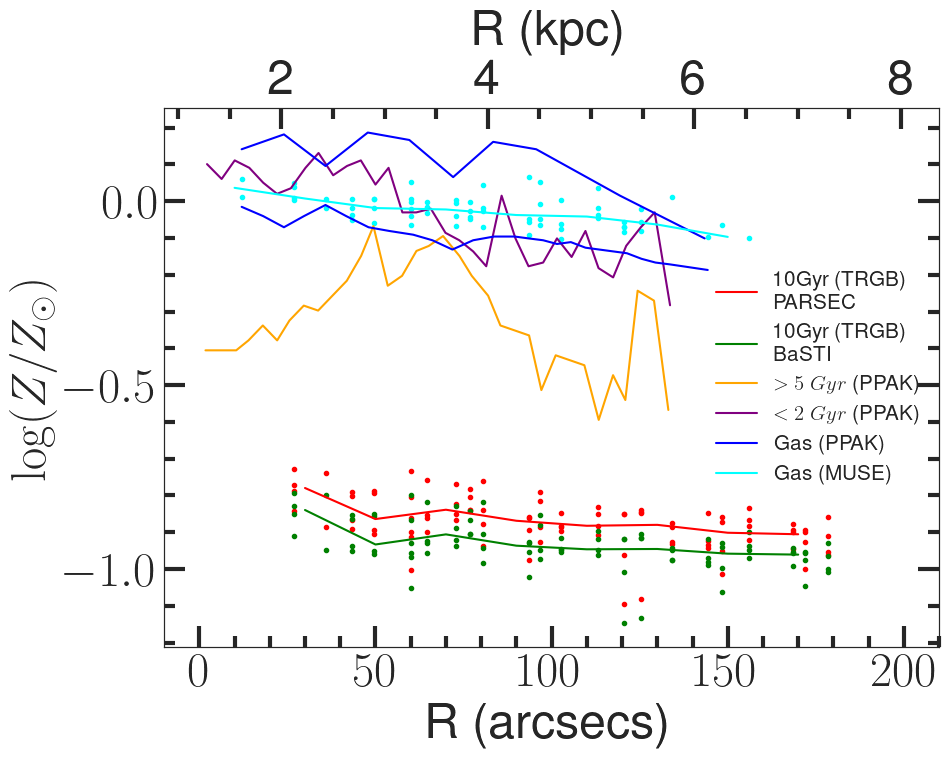

In [338]:
fig , ax = plt.subplots(figsize=(10,7), sharex=True)

x, y = np.mgrid[0:15,0:6]/1.0
x -= 7
y-= 2.5
x *= 24
y *= 24

r = np.sqrt(x**2 + y**2)

# Stellar-Metallicity PARSEC
x = r.ravel()
y = met_map.ravel()

ind = ~np.isnan(y)

x = x[ind]
y = y[ind]

init = exp1d(tau=10)
fit = fitting.LevMarLSQFitter()
model = fit(init,abs(x),y)

x_new = np.arange(0,200,20)
x_c = 0.5*(x_new[1:] + x_new[:-1])

y_new = []
for i in range(len(x_new)-1):
    ind = np.where((x>x_new[i]) & (x<=x_new[i+1]))
    
    y_new.append(np.median(y[ind]))

y_c = np.array(y_new)
y_1 = y_c
ax.scatter(x,np.log10(y/0.017), marker='.', color='red', label= '_nolegend_')
ax.plot(x_c,np.log10(y_c/0.017), '-r', label = '10Gyr (TRGB)\n PARSEC')
x_new = np.linspace(0,x.max(),1000)

# Stellar-Metallicity BaSTI
x = r.ravel()
y = met_map_basti.ravel()

ind = ~np.isnan(y)

x = x[ind]
y = y[ind]

init = exp1d(tau=10)
fit = fitting.LevMarLSQFitter()
model = fit(init,abs(x),y)

x_new = np.arange(0,200,20)
x_c = 0.5*(x_new[1:] + x_new[:-1])

y_new = []
for i in range(len(x_new)-1):
    ind = np.where((x>x_new[i]) & (x<=x_new[i+1]))
    
    y_new.append(np.median(y[ind]))

y_c = np.array(y_new)
y_1 = y_c
ax.scatter(x,np.log10(y/0.017), marker='.', color='green', label= '_nolegend_')
ax.plot(x_c,np.log10(y_c/0.017), '-g', label = '10Gyr (TRGB)\n BaSTI')



ax.set_ylabel(r'$\log(Z/Z_{\odot})$')

ax.xaxis.set_major_locator(AutoLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())

ax.yaxis.set_major_locator(AutoLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', length=15,direction="in", bottom=True,left=True, right=True, top=True, width=3)
ax.tick_params(which='minor', length=8, width=3)

ax1 = ax.twiny()  # instantiate a second axes that shares the same x-axis
ax1.set_xlabel('R (kpc)',labelpad=10)  # we already handled the x-label with ax1
xticks_n = np.array([2,4,6,8])
xticks = xticks_n*1e3/45

ax1.set_xticks(xticks, xticks_n)

ax1.set_xlim(ax.get_xlim()[0],ax.get_xlim()[1])

ax.set_xlabel('R (arcsecs)')

ax1.minorticks_on()
ax1.tick_params(which='both', length=15,direction="in", top=True, width=3)
ax1.tick_params(which='minor', length=8, width=3)

#ax.set_yscale('log')
#ax.set_ylim(-3, 0.03)

df = pd.read_csv('../data/Z_5Gyr.csv', header=None)

x = df[0]
y = df[1]

ax.plot(x,y, color='orange', label= r'$>5~Gyr$ (PPAK)')

df = pd.read_csv('../data/Z_2Gyr.csv', header=None)

x = df[0]
y = df[1]

ax.plot(x,y,color='purple',label= r'$<2~Gyr$ (PPAK)')


df = pd.read_csv('../data/Z_gas_up.csv', header=None)

x = df[0]
y = df[1]

ax.plot(x,y, color='blue', label='Gas (PPAK)')

df = pd.read_csv('../data/Z_gas_down.csv', header=None)

x = df[0]
ind = np.argsort(x)
y = df[1]

ax.plot(x[ind],y[ind], color='blue')

# Gas-Phase metallicity
x = r.ravel()
y = 10**(met_map_muse.ravel()-8.69)*0.017
ind = ~np.isnan(y)

x = x[ind]
y = y[ind]

x_new = np.arange(0,200,20)
x_c = 0.5*(x_new[1:] + x_new[:-1])

y_new = []
for i in range(len(x_new)-1):
    ind = np.where((x>x_new[i]) & (x<=x_new[i+1]))
    
    y_new.append(np.median(y[ind]))

y_c = np.array(y_new)

y_2 = y_c
ax.scatter(x,np.log10(y/0.017), marker='.', color='cyan', label= '_nolegend_')
ax.plot(x_c,np.log10(y_c/0.017), '-', label= 'Gas (MUSE)', color='cyan')

ax.legend(fontsize=15, frameon=False)
ax.set_xlim(-10, 210)

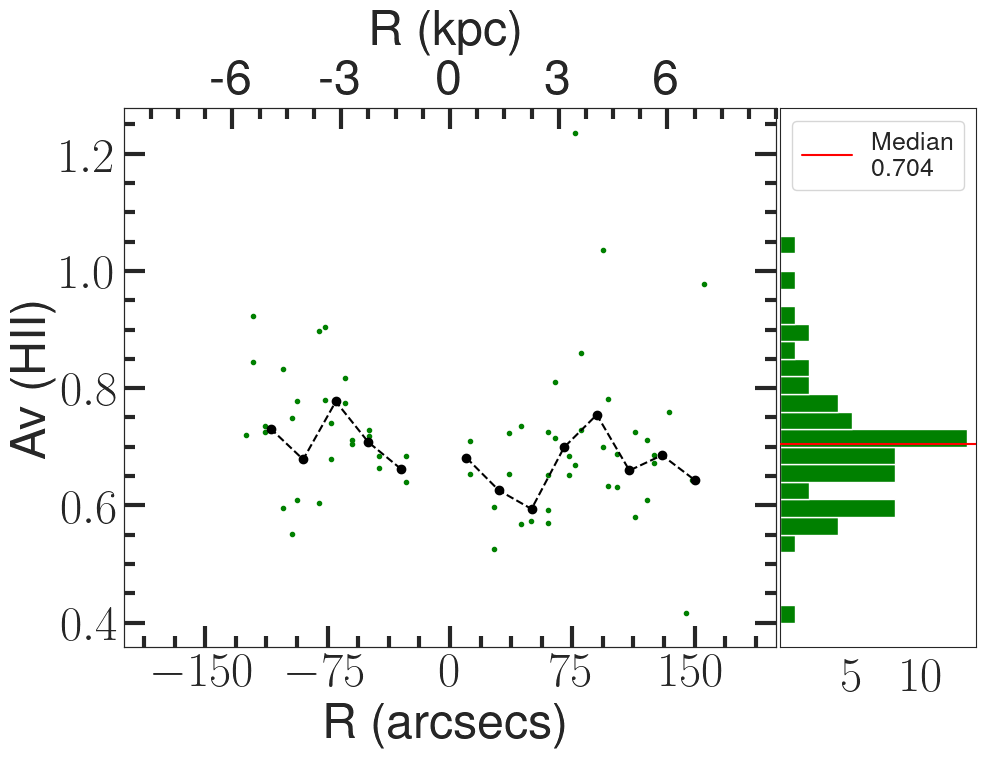

In [279]:
x, y = np.mgrid[0:15,0:6]/1.0
x -= 7
y-= 2.5
x *= 24
y *= 24

r = np.sqrt(x**2 + y**2)

fig , ax_ = plt.subplots(1,2, figsize=(11,7), sharey=True, width_ratios=[1,0.3])
ax = ax_[0]

x = r[:7].ravel()
y = (Av_map_muse)[:7].ravel()
ind = ~np.isnan(y)

x = x[ind]
y = y[ind]

x_new = np.arange(0,x.max()*1.1,20)
x_c = 0.5*(x_new[1:] + x_new[:-1])

y_new = []
for i in range(len(x_new)-1):
    ind = np.where((x>x_new[i]) & (x<=x_new[i+1]))
    
    y_new.append(np.median(y[ind]))

y_c = np.array(y_new)

ax.scatter(-x,y, marker='.', color='green')
ax.plot(-x_c,y_c, '--ok')

#Right
x = r[7:].ravel()
y = (Av_map_muse)[7:].ravel()
ind = ~np.isnan(y)

x = x[ind]
y = y[ind]

x_new = np.arange(0,x.max()*1.1,20)
x_c = 0.5*(x_new[1:] + x_new[:-1])

y_new = []
for i in range(len(x_new)-1):
    ind = np.where((x>x_new[i]) & (x<=x_new[i+1]))
    
    y_new.append(np.median(y[ind]))

y_c = np.array(y_new)

ax.scatter(x,y, marker='.', color='green')
ax.plot(x_c,y_c, '--ok')


ax.set_xlabel('R (arcsecs)')
ax.set_ylabel('Av (HII)')
ax.set_xlim(-200,200)

ax.set_xticks([-150,-75,0,75,150])
ax1 = ax.twiny()  # instantiate a second axes that shares the same x-axis
ax1.minorticks_on()
ax1.set_xlabel('R (kpc)',labelpad=10)  # we already handled the x-label with ax1

xticks_n = np.array([-6,-3,0,3,6])
xticks = xticks_n*1e3/45

ax1.set_xticks(xticks, xticks_n)


ax1.set_xlim(ax.get_xlim()[0],ax.get_xlim()[1])

ax.yaxis.set_major_locator(AutoLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', length=15,direction="in", bottom=True,left=True, right=True, width=3)
ax.tick_params(which='minor', length=8, width=3)
ax.minorticks_on()

ax1.yaxis.set_major_locator(AutoLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())

ax1.tick_params(which='both', length=15,direction="in",top=True, width=3)
ax1.tick_params(which='minor', length=8, width=3)


data = (Av_map_muse).ravel()
bins = np.arange(0.4,1.1,0.03)

ax_[1].hist(data,bins=bins, orientation='horizontal', color='green', label='_nolegend_')

m = np.nanmedian(Av_map_muse)
ax_[1].axhline(m, zorder=300, color='red')
ax_[1].set_xticks([5,10])
ax_[1].legend([f'Median\n{np.round(m,3)}'], fontsize=18)
plt.subplots_adjust(wspace=0.01)

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))

img = ax.scatter(Av_map.ravel(), met_map.ravel(), c=r*45/1e3, cmap='plasma')

cb = plt.colorbar(img,ax=ax)

cb.set_label('R (kpc)')

ax.errorbar(x=[0.4],y=[0.0035],xerr=0.0719,yerr=0.0002, fmt='.r',elinewidth=2,
            markersize=5, capsize=3, markerfacecolor='black', markeredgecolor='black')
ax.xaxis.set_major_locator(AutoLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())

ax.yaxis.set_major_locator(AutoLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', length=15,direction="in", bottom=True, top=True,left=True, right=True)
ax.tick_params(which='minor', length=8)

ax.set_xlabel('Av')
ax.set_ylabel('Z')

In [ ]:
f115w = np.array([27.27155834, 27.11447268, 26.78737654, 26.48242481, 26.22806565,
       25.63513022, 25.21561921, 24.49524254, 25.25102156, 25.74340321,
       26.26207453, 26.60104363, 26.68098357, 26.92416768, 27.1451311 ])[:7]
f115w_a = np.array([1.46383489, 1.35430766, 1.16390182, 1.14424779, 1.15101916,
       1.21014396, 1.26028085, 1.1703291 , 1.24884232, 1.20206925,
       1.17804216, 1.19735982, 1.1074136 , 1.30304933, 1.50606   ])[:7]

f150w = np.array([25.71734278, 25.66298599, 25.51999397, 25.29770887, 25.18062613,
       24.65056813, 24.26037403, 23.5535029 , 24.29935836, 24.72755162,
       25.16132626, 25.38555494, 25.46240873, 25.54193172, 25.65485763])[:7]

f150w_a = np.array([1.4616163 , 1.41431072, 1.30119274, 1.28306042, 1.25761357,
       1.32733796, 1.43434053, 1.34226686, 1.4074099 , 1.35237391,
       1.30138716, 1.34637685, 1.27800805, 1.38326344, 1.4920449 ])[:7]

f200w = np.array([25.9781503 , 25.74232124, 25.19845565, 24.80504045, 24.53260125,
       23.85941158, 23.47109451, 22.7474432 , 23.53099111, 23.99452647,
       24.61366905, 25.06264859, 25.12595093, 25.5101388 , 25.88185164])[:7]

f200w_a = np.array([1.22481289, 1.14931582, 1.0743086 , 1.1253553 , 1.16497143,
       1.32882919, 1.47040635, 1.35515924, 1.39665941, 1.35275438,
       1.19124447, 1.17974097, 1.06155608, 1.11030476, 1.17881908])[:7]

In [ ]:
sirius_vega = np.array([7.211, 7.216, 7.210, 7.209, 7.208, 7.209, 7.212, 7.213, 0, 0, 0.141])
vega = np.array([7.200, 7.204, 7.198, 7.197, 7.197, 7.198, 7.201, 7.202, 0, 0, 0.141])

In [ ]:
sirius_vega - vega

In [ ]:
fig, axs = plt.subplots(2,1,figsize=(10,10), sharex=True)

x, y = np.mgrid[0:15,0:6]/1.0
x -= 7
y-= 2.5
x *= 24
y *= 24

r = np.sqrt(x**2 + y**2)

r = np.where(x<0,r,r)
x = r.ravel()
y = trgb_f200w_mag.ravel()

ind = np.argsort(x)

x= x[ind]
y= y[ind]

x_new = np.arange(0,x.max()*1.2,20)
x_c = 0.5*(x_new[1:] + x_new[:-1])

y_new = []
for i in range(len(x_new)-1):
    ind = np.where((x>x_new[i]) & (x<=x_new[i+1]))
    
    y_new.append(np.nanmedian(y[ind]))

y_c = np.array(y_new)
ax.invert_yaxis()
ax =axs[0]
ax.scatter(x,y, color='blue',zorder=300)
ax.errorbar(x,y, yerr=[trgb_f200w_err_m.ravel(),trgb_f200w_err_p.ravel()], color='black',
           ls='None', capsize=3)


ax.plot(x_c,y_c,'-', color='blue', linewidth=3, label = 'TRGB mag (Observed)')


x = r.ravel()
y = trgb_f200w_mag.ravel() + model_f200w_crowd

x_new = np.arange(0,x.max()*1.2,20)
x_c = 0.5*(x_new[1:] + x_new[:-1])

y_new = []
for i in range(len(x_new)-1):
    ind = np.where((x>x_new[i]) & (x<=x_new[i+1]))
    
    y_new.append(np.nanmedian(y[ind]))

y_c = np.array(y_new)


ax.scatter(x,y, color='red')
ax.errorbar(x,y, yerr=[trgb_f200w_err_m.ravel(),trgb_f200w_err_p.ravel()], color='black',
           ls='None', capsize=3)
ax.plot(x_c,y_c,'--', color='red', label = 'TRGB mag (Corrected)', linewidth=3)


y_f200w = np.array([25.9781503 , 25.74232124, 25.19845565, 24.80504045, 24.53260125,
       23.85941158, 23.47109451, 22.7474432 , 23.53099111, 24.00988105,
       24.61366905, 25.06264859, 25.12595093, 25.5101388 , 25.88185164])

x = np.array([-168.42802617, -144.49913495, -120.59850745,  -96.74709298,
        -72.99315036,  -49.47726751,  -26.83281573,   12.        ,
         26.83281573,   49.47726751,   72.99315036,   96.74709298,
        120.59850745,  144.49913495,  168.42802617])

r_comp = np.sqrt(x**2 + 12**2)

ax.scatter(abs(r_comp)-5,y_f200w, color='orange', label='_no_legend_')

x = r_comp[7:][::-1] -5
y = 0.5*(y_f200w[:8] + y_f200w[7:][::-1])

ax.plot(x,y, '-r', label=r'$m_{50}$')

ax.set_ylim(23.20332137918283,23.754288570591175)
ax.invert_yaxis()
ax.set_ylabel(r'$F200W$')
ax = axs[1]
# TRGB color
x = r.ravel()
y = trgb_cols[:,:,7].ravel() 

ind = np.argsort(x)

x= x[ind]
y= y[ind]

x_new = np.arange(0,x.max()*1.2,20)
x_c = 0.5*(x_new[1:] + x_new[:-1])

y_new = []
for i in range(len(x_new)-1):
    ind = np.where((x>x_new[i]) & (x<=x_new[i+1]))
    
    y_new.append(np.nanmedian(y[ind]))

y_c = np.array(y_new)

ax.scatter(x,y, color='blue',zorder=300)

yerr_p = np.sqrt(0.007**2 + f115w_f200w_err_p[start:end+1]**2)
yerr_m = np.sqrt(0.007**2 + f115w_f200w_err_m[start:end+1]**2)

ax.errorbar(x,y, yerr=[yerr_m, yerr_p], color='black',
           ls='None', capsize=3)

ax.plot(x_c,y_c,'-', color='blue', linewidth=3, label = 'TRGB Color (Observed)')


x = r.ravel()
y = trgb_cols[:,:,7].ravel() + model_f115w_f200w_crowd

x_new = np.arange(0,x.max()*1.2,20)
x_c = 0.5*(x_new[1:] + x_new[:-1])

y_new = []
for i in range(len(x_new)-1):
    ind = np.where((x>x_new[i]) & (x<=x_new[i+1]))
    
    y_new.append(np.nanmedian(y[ind]))

y_c = np.array(y_new)


#ax.scatter(x,y, color='red')
#ax.errorbar(x,y, yerr=[yerr_m, yerr_p], color='black',
#           ls='None', capsize=3)
ax.plot(x_c,y_c,'--', color='red', label = 'TRGB Color (Corrected)', linewidth=3)
 
ax.set_xlabel('R (arcsec)')

ax1 = axs[0].twiny()  # instantiate a second axes that shares the same x-axis
ax1.set_xlabel('R (kpc)',labelpad=10)  # we already handled the x-label with ax1
xticks_n = np.array([2,4,6,8])
xticks = xticks_n*1e3/45

ax1.set_xticks(xticks, xticks_n)

ax1.set_xlim(axs[0].get_xlim()[0],ax.get_xlim()[1])
ax.set_xlabel('R (arcsecs)')
ax.set_ylabel(r'$F115W-F200W$')
for ax in axs:
    ax.xaxis.set_major_locator(AutoLocator())
    ax.xaxis.set_minor_locator(AutoMinorLocator())

    ax.yaxis.set_major_locator(AutoLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())

    ax.tick_params(which='both', length=15,direction="in", bottom=True, top=True,left=True, right=True, width=3)
    ax.tick_params(which='minor', length=8, width=3)
    
    ax.legend(fontsize=20)
    
plt.subplots_adjust(hspace=0)

In [ ]:
np.nanmedian(yerr_p), np.nanmedian(yerr_m)

In [ ]:
np.nanmedian(trgb_f200w_err_p.ravel()), np.nanmedian(trgb_f200w_err_m.ravel())

In [ ]:
df = tab[['ra_2', 'dec_2', 'flux_2','mag_vega_F200W']].to_pandas()

In [ ]:
df = df.rename(columns={'ra_2':'ra',
                'dec_2':'dec',
                'flux_2': 'flux',
                'mag_vega_F200W':'mag'})

In [ ]:
zero_flux = df['flux']/pow(10,-0.4*df['mag'])
zero_flux = np.median(zero_flux)

In [ ]:
2.5*np.log10(zero_flux)

In [ ]:
hdul_n = fits.open(dict_images[det_n][filt_n]['images'][0])
data_n = hdul_n[1].data

pixel_scale = hdul_n[1].header['CDELT1']*3600

wcs_n = WCS(hdul_n[1].header)

In [ ]:
hdul_n[1].header

In [ ]:
wcs_n

In [ ]:
np.arccos(0.422540420042849)*180/np.pi

In [ ]:
psf = fits.open(f'../data/PSF/epsf/F200W/snap_test_psf.fits')[0].data[0,0]
psf = psf.reshape(51,5,51,5).sum(axis=(1,3))
psf /= psf.sum()

hdu = fits.PrimaryHDU(psf)
hdul = fits.HDUList([hdu])
hdul.writeto('psf.fits', overwrite=True)

tel_params ={
            'aperture'       : 650,
            'pixel_scale'    : pixel_scale,
            'psf_file'       : f'psf.fits',
            'response_funcs' :  [ f'{data_path}/INSIST/UV/Coating.dat,5,100',   # 6 mirrors
                                ],
             'coeffs'        : 1/11112.266256569348,
             'theta'         : 65.00492096781794,
             'M_sky' : 27,
            }

In [ ]:
sim = pt.Imager(df, coords=(24.17399193760206,  15.78396038669509),
                tel_params=tel_params, n_x=11604, n_y=4630, exp_time = 2920.4)

In [ ]:
2.5*np.log10(sim.zero_flux), 

In [ ]:
sim.shot_noise = False
sim.sky = False
sim.Bias = False
sim.QN = False
sim.DC = False
sim.PRNU = False
det_params = {'shot_noise' :  'Poisson',
              'qe_response': [],
              'qe_mean'    : 1,
              'G1'         :  1,
              'bias'       : 1,
              'PRNU_frac'  :  0.25/100,
              'DCNU'       :  0.1/100,
              'RN'         :  0.5,
              'T'          :  218,
              'DN'         :  0.01/100
              }

sim(det_params=det_params, photometry=None)

In [ ]:
sim.show_image()

In [ ]:
sim.writeto('../data/pista_carbon_stars_II.fits')

In [ ]:
fs = glob.glob('data/*.csv')
df = pd.read_csv(fs[0])

for f in fs[1:]:
    df_n = pd.read_csv(f)
    df = pd.concat([df, df_n])

In [ ]:
df.keys()

In [ ]:
df_f = df[(df['age']>5.9) &(df['age']<=7)]
x = df_f['RA']
y = df_f['DEC']
c = df_f['age']
scale = 11417/4486
l = 5
fig, ax = plt.subplots(figsize=(l*scale+3,l))

theta = np.pi/2.75
img = ax.scatter(x*np.cos(theta) - y*np.sin(theta),x*np.sin(theta) + y*np.cos(theta),s=5,c=c, cmap='jet')
#ax.set_xlabel('RA')
#ax.set_ylabel('DEC')
ax.invert_xaxis()
ax.set_xlim(-4.259903639039913, -4.369990102024565)
ax.set_ylim(28.524099525386, 28.568378781292367)
ax.axis('Off')
cb = plt.colorbar(img, shrink=0.9, pad=-0.03)
cb.set_label('log(Age)')
fig.tight_layout()

In [ ]:
df_f = df[(df['age']>7) &(df['age']<=8)]
x = df_f['RA']
y = df_f['DEC']
c = df_f['age']
scale = 11417/4486
l = 5
fig, ax = plt.subplots(figsize=(l*scale+3,l))

theta = np.pi/2.75
img = ax.scatter(x*np.cos(theta) - y*np.sin(theta),x*np.sin(theta) + y*np.cos(theta),s=0.2,c=c, cmap='jet')
#ax.set_xlabel('RA')
#ax.set_ylabel('DEC')
ax.invert_xaxis()
ax.set_xlim(-4.259903639039913, -4.369990102024565)
ax.set_ylim(28.524099525386, 28.568378781292367)
ax.axis('Off')
cb = plt.colorbar(img, shrink=0.9, pad=-0.03)
cb.set_label('log(Age)')
fig.tight_layout()

In [ ]:
df_f = df[(df['age']>8) &(df['age']<=9.6)]
x = df_f['RA']
y = df_f['DEC']
c = df_f['age']
scale = 11417/4486
l = 5
fig, ax = plt.subplots(figsize=(l*scale+3,l))

theta = np.pi/2.75
img = ax.scatter(x*np.cos(theta) - y*np.sin(theta),x*np.sin(theta) + y*np.cos(theta),s=0.2,c=c, cmap='jet')
#ax.set_xlabel('RA')
#ax.set_ylabel('DEC')
ax.set_xlim(-4.259903639039913, -4.369990102024565)
ax.set_ylim(28.524099525386, 28.568378781292367)
ax.invert_xaxis()
ax.axis('Off')
cb = plt.colorbar(img, shrink=0.9, pad=-0.03)
cb.set_label('log(Age)')
fig.tight_layout()

In [ ]:
df_f = df[(df['age']>9.6) &(df['age']<=10)]
x = df_f['RA']
y = df_f['DEC']
c = df_f['age']
scale = 11417/4486
l = 5
fig, ax = plt.subplots(figsize=(l*scale+3,l))

theta = np.pi/2.75
img = ax.scatter(x*np.cos(theta) - y*np.sin(theta),x*np.sin(theta) + y*np.cos(theta),s=0.2,c=c, cmap='jet')
#ax.set_xlabel('RA')
#ax.set_ylabel('DEC')
ax.invert_xaxis()
ax.axis('Off')
cb = plt.colorbar(img, shrink=0.9, pad=-0.03)
cb.set_label('log(Age)')
fig.tight_layout()

In [ ]:
with open("../data/isochrones_master/cmd_hst_acs.dat") as f:
    dat = f.readlines()

data = []

for i,d in enumerate(dat[15:-1]):
    if 'Zini' not in d:
        data.append([float(i) for i in d.split()])
        
df_cmd_acs = pd.DataFrame(data,columns=dat[13][2:].split())[:-1]
df_cmd_acs = df_cmd_acs.drop_duplicates(['Mini','logAge','label'])
df_cmd_acs.to_csv("../data/isochrones_master/cmd_hst_acs.csv", index=None)

In [ ]:
df_cmd_acs = pd.read_csv("../data/isochrones_master/cmd_hst_acs.csv")

In [ ]:
ages = np.unique(df_cmd_acs['logAge'].values)
mets = np.unique(df_cmd_acs['Zini'].values)
mag_err_lim = 0.2

In [ ]:
ages

In [ ]:
mets

In [ ]:
mss = []
colss = []
for i in [9.6,9.8,10,10.1000]:
    df = df_cmd_acs[np.round(df_cmd_acs['logAge'],4)==i]
    df = df[df['label']==3]
    ms = []
    cols = []
    for j in [0.0001, 0.0002, 0.0005, 0.001 , 0.002 , 0.003 , 0.004 , 0.006]:
        df_ = df[df['Zini']==j]
        df_ = df_[df_['logL']==df_['logL'].max()]
        m = df_['F814Wmag'].values[0]
        col = (df_['F606Wmag'] - df_['F814Wmag']).values[0]
        ms.append(m)
        cols.append(col)
    mss.append(ms)
    colss.append(cols)
m = np.array(mss)
col = np.array(colss)

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

ax.plot(col,m, '-|', markersize=20)

ax.xaxis.set_major_locator(AutoLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())

ax.yaxis.set_major_locator(AutoLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', length=7,direction="in", bottom=True, top=True,left=True, right=True)
ax.tick_params(which='minor', length=4)
ax.invert_yaxis()

ax.legend([0.0001, 0.0002, 0.0005, 0.001 , 0.002 , 0.003 , 0.004 , 0.006],
         ncols=3, fontsize=15)
ax.set_xlabel(r'F606W-F814W')
ax.set_ylabel(r'F814W')

Av_ = 0.2
Av_x = 2
Av_y = -4.05

AF1_ =  Av_dict['f606w']*Av_
AF2_ =  Av_dict['f814w']*Av_
AF3_ =  Av_dict['f814w']*Av_

dx = AF1_ - AF2_
dy = AF3_

ax.annotate('', xy=(Av_x, Av_y),
             xycoords='data',
             xytext=(Av_x+dx, Av_y+dy),
             textcoords='data',
             arrowprops=dict(arrowstyle= '<|-',
                             color='black',
                             lw=2,
                             ls='-')
           )

ax.annotate(f'Av = {Av_}', xy=(Av_x-0.01, Av_y-0.01),fontsize=20)

ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1])
ax.set_xlim(ax.get_xlim()[0], ax.get_xlim()[1])

for i in [9.6,9.8,10,10.1000]:
    df = df_cmd_acs[np.round(df_cmd_acs['logAge'],3)==i]
    df = df[df['label']==3]
    ms = []
    cols = []
    for j in [0.0001, 0.0002, 0.0005, 0.001 , 0.002 , 0.003 , 0.004 , 0.006]:
        df_ = df[df['Zini']==j]
        x = df_['F606Wmag'] - df_['F814Wmag']
        y = df_['F814Wmag']
        
        mask = (y.values[1:]- y.values[:-1])<0.5
        mask = np.array([True] + list(mask))
        mask = np.where(~mask, np.nan, 1)
        
        if i ==10:
            lw = 2
            alpha=0.7
        else:
            lw =1
            alpha=0.3
        ax.plot(x,y*mask, color='black',alpha=alpha,lw=lw)
    

In [ ]:
x = np.array([0.0001, 0.0002, 0.0005, 0.001 , 0.002 , 0.003 , 0.004 , 0.006])
y = m[3]

init = models.Linear1D()
fit = fitting.LinearLSQFitter()
model = fit(init, x, y)
plt.plot(x,y, '--ok')
plt.plot(x,model(x),'--r')

In [ ]:
np.round(y.max()-y.min(),3)

In [ ]:
grad_y = np.gradient(y,x)
np.round(grad_y*0.001,3)

In [ ]:
x = 10**np.array([9.6,9.8,10,10.1139])
y = m[:,-1]
init = models.Linear1D()
fit = fitting.LinearLSQFitter()
model = fit(init, x, y)
plt.plot(x,y, '--ok')
plt.plot(x,model(x),'--r')

In [ ]:
np.round(y.max()-y.min(),3)

In [ ]:
np.round(model.parameters[0]*1e9,3)

In [ ]:
if not os.path.exists('../data/isochrones/HST_ACS'):
    os.mkdir('../data/isochrones/HST_ACS/')
else:
    os.system('rm ../data/isochrones/HST_ACS/*')
l = 1    
for i, age in enumerate([ 6.,  6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8 , 6.9, 7., 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7,
                          7.8, 7.9, 8.0, 8.1, 8.2]):
    
    if len(str(i+1))==1:
        i = '0' + str(i+1)
    else:
        i =  str(i+1)
    for met in [0.02]:
        
        temp = df_cmd_acs[df_cmd_acs['logAge']==age]
        temp = temp[temp['Zini']==met]
        
        # Interpolation using F115W-F200W vs F200W
        
        x = temp['F435Wmag'].values - temp['F814Wmag'].values 
        y = temp['F814Wmag'].values
        
        diff = np.array([0] + list(np.sqrt((x[1:]-x[:-1])**2 + (y[1:]-y[:-1])**2)))
        dist = []
        for i in range(len(diff)):
            dist.append(diff[:i+1].sum())
            
        temp['dist'] = dist
        temp = temp.sort_values('dist')
        
        x = temp['dist']
        x_new = np.arange(x.min(), x.max(),0.01)

        label = np.interp(x_new, x, temp['label'])
        Mini = np.interp(x_new, x, temp['Mini'])
        f435w = np.interp(x_new, x, temp['F435Wmag'])
        f555w = np.interp(x_new, x, temp['F555Wmag'])
        f814w = np.interp(x_new, x, temp['F814Wmag'])

        temp_interp = pd.DataFrame(zip(label, Mini, f435w, f555w, f814w), columns = ['label','Mini','F435Wmag', 'F555Wmag', 'F814Wmag'])
        temp_interp['Zini'] = temp['Zini'].max()
        temp_interp['logAge'] = temp['logAge'].max()
        temp = temp_interp
        
        temp = temp[['label', 'Mini', 'F435Wmag', 'F555Wmag', 'F814Wmag', 'Zini', 'logAge']]
        header = list(temp.keys())
        header[0] = '#' + header[0]
            
        if l<10:       
            temp.to_csv(f'../data/isochrones/HST_ACS/0{l}_PARSEC1.1_Z0.020_logAGE{age}Myr_HST_BVI.isoc',sep=' ',
                       index=None, header = header)
        else:
            temp.to_csv(f'../data/isochrones/HST_ACS/{l}_PARSEC1.1_Z0.020_logAGE{age}Myr_HST_BVI.isoc',sep=' ',
                       index=None, header = header)
        l+=1

In [ ]:
temp

In [ ]:
with open("../data/isochrones_master/cmd_hst_uvis_n.dat") as f:
    dat = f.readlines()

data = []

for i,d in enumerate(dat[13:-1]):
    if 'Zini' not in d:
        data.append([float(i) for i in d.split()])
        
df_cmd_uvis = pd.DataFrame(data,columns=dat[13][2:].split())[:-1]
df_cmd_uvis.to_csv("../data/isochrones_master/cmd_hst_uvis.csv")
#df_cmd_uvis = df_cmd_uvis[df_cmd_uvis['MH']==0.51508]
#df_cmd_uvis = df_cmd_uvis[(df_cmd_uvis['label']>-1) & (df_cmd_uvis['label']<7)]

In [ ]:
df_cmd_uvis = pd.read_csv("../data/isochrones_master/cmd_hst_uvis.csv")

In [ ]:
ages = np.round(np.arange(6.0,8.1,0.1),1)

mag_err_lim = 0.2

In [ ]:
if not os.path.exists('../data/isochrones/HST_UVIS'):
    os.mkdir('../data/isochrones/HST_UVIS/')
else:
    os.system('rm ../data/isochrones/HST_UVIS/*')
    
for i, age in enumerate(ages):
    temp = df_cmd_uvis[df_cmd_uvis['logAge']==age]
    if len(str(i+1))==1:
        i = '0' + str(i+1)
    else:
        i =  str(i+1)
    
    temp = temp[['label', 'Mini', 'F275Wmag', 'F336Wmag', 'Zini', 'logAge']]
    temp =  temp[temp['Mini']>=2]
    header = list(temp.keys())
    header[0] = '#' + header[0]
        
    temp.to_csv(f'../data/isochrones/HST_UVIS/{i}_PARSEC1.1_Z0.015_logAGE{age}Myr_HST_UVIS.isoc',sep=' ',
               index=None, header = header)

In [ ]:
np.round(9.9545,4)

In [ ]:
10**9.9545/1e9

In [ ]:
ages_ = [9.9545]

In [ ]:
a = []
for i in df_cmd_uvis['Zini']:
    if i in [0.0001,0.0004,0.001]:
        a.append(True)
    else:
        a.append(False)

In [ ]:
df_cmd = df_cmd_uvis[a]

In [ ]:
r_in = 0.3
r_out = 10

fig, ax, tab = gen_CMD('f606w','f814w','f814w', name = '606_814_main',cmd=df_cmd, out_dir='../HST/data/photometry/m81-gc', Av = 0.220,
                 Av_=0.5, xlims=[0.25,1.5], ylims=[23, 27.7], r_in=r_in,r_out=r_out, ref_xpos = 0.5, mag_err_lim=0.2,
                ra_col='ra_1', dec_col='dec_1', label = 3, met=0.0004, regions=['m81-gc'], ages=ages_, dismod=27.8,s=3, alpha=1, lw=4,
                  Av_x = 0.78, Av_y=27,skip_data=True,)
ax.get_legend().remove()
fig, ax, tab = gen_CMD('f606w','f814w','f814w', name = '606_814_main',cmd=df_cmd, out_dir='../HST/data/photometry/m81-gc', Av = 0.220,
                 Av_=0.5, xlims=[0.25,1.5], ylims=[23, 27.7], r_in=r_in,r_out=r_out, ref_xpos = 0.5, mag_err_lim=0.2, lw=2,
                ra_col='ra_1', dec_col='dec_1', label = 3, met=None, regions=['m81-gc'], ages=ages_, dismod=27.8,s=3,  alpha=0.5,
                  Av_x = 0.78, Av_y=27,fig=fig,ax=ax,)


In [ ]:
r_in = 0
r_out = 100

fig, ax, tab = gen_CMD('f606w','f814w','f814w', name = 'sim_gc',cmd=df_cmd_uvis, out_dir='../HST/data/sim', Av = 0.220,
                 Av_=0.5, xlims=[0,2.], ylims=[22, 28], r_in=r_in,r_out=r_out, ref_xpos = 0.25, mag_err_lim=0.5,
                ra_col='ra_1', dec_col='dec_1', ang=0,
                label = 9, met=0.0004, regions=['m81-gc'], ages=ages_, dismod=27.8,s=3,  alpha=0.5,
                  Av_x = 1.5, Av_y=27)

In [ ]:
x = tab['ra_1']
y = tab['dec_1']

plt.scatter(x,y,s=0.5, color='black')

In [ ]:
with open("../../HST/data/sim/9gyr.dat") as f:
    dat = f.readlines()

data = []

for i,d in enumerate(dat[14:]):
    if '#' not in d and 'terminated' not in d:
        data.append([float(i) for i in d.split()])

In [ ]:
df = pd.DataFrame(data,columns=dat[13][2:].split())
df = df.drop_duplicates(['Mini','age','label'])

In [ ]:
y, x = 10/3600*np.mgrid[-1000:1000,-1000:1000]/1000
p  = models.Sersic2D(r_eff=10/3600,n=2)(x,y)

In [ ]:
p/=p.sum()

In [ ]:
plt.imshow(np.log10(p),extent=[x.min()*3600,x.max()*3600,
                              y.min()*3600,y.max()*3600])

In [ ]:
flat = p.flatten()
sample_index = np.random.choice(a=flat.size,size=len(df), p=flat)

In [ ]:
adjusted_index = np.unravel_index(sample_index, p.shape)

In [ ]:
ra = x[adjusted_index] + 149.47781
dec = y[adjusted_index] + 68.816955

In [ ]:
ra_plot = (ra - 149.47781)*3600
dec_plot = (dec -68.816955)*3600
plt.scatter(ra_plot,dec_plot,s=0.0001, color='black')
plt.xlim(-0.3,0.3)

plt.ylim(-0.3,0.3)
plt.axis('equal')

In [ ]:
df['ra_1'] = ra
df['dec_1']= dec

In [ ]:
df = df.rename(columns={'F606Wmag':'mag_vega_F606W',
               'F814Wmag' : 'mag_vega_F814W'})

In [ ]:
df['mag_vega_F606W'] = df['mag_vega_F606W'] + 27.8 + Av_dict['f606w']*0.22
df['mag_vega_F814W'] = df['mag_vega_F814W'] + 27.8 + Av_dict['f814w']*0.22                                                                                                            

In [ ]:
df['mag_err_1'] = model_606(df['mag_vega_F606W'])
df['mag_err_2'] = model_814(df['mag_vega_F814W'])

In [ ]:
df['mag_err_1'].min()

In [ ]:
tab_sim = Table.from_pandas(df[['ra_1','dec_1','mag_vega_F606W', 'mag_err_1', 'mag_vega_F814W','mag_err_2']])

In [ ]:
tab_sim.write('../../HST/data/sim/sim_gc.fits', overwrite=True)

In [ ]:
((tab_sim['ra_1']-149.47781)*3600).mean()

In [ ]:
x = tab['mag_vega_F606W'].value
y = tab['mag_err_1'].value

init = models.Exponential1D()
fit = fitting.LevMarLSQFitter()

model_606 = fit(init,x,y)

plt.scatter(x, y,marker='.', color='black')

y = np.linspace(0,0.2)
x_606 = lambda y: model_606.parameters[1]*np.log(y/model_606.parameters[0])

plt.plot(x_606(y),y,'--r')

x = tab['mag_vega_F814W']
y = tab['mag_err_2']

init = models.Exponential1D()
fit = fitting.LevMarLSQFitter()
model_814 = fit(init,x,y)

plt.scatter(x, y,marker='.', color='red')

y = np.linspace(0,0.2)
x_814 = lambda y: model_814.parameters[1]*np.log(y/model_814.parameters[0])

plt.plot(x_814(y),y,'--g')

In [ ]:
tab0 = Table.read('../../HST/data/photometry/m81-gc/606_814_main.fits')
tab1 = Table.read('../../HST/data/photometry/m81-gc/606_814_1not2.fits')
tab2 = Table.read('../../HST/data/photometry/m81-gc/606_814_2not1.fits')

In [ ]:
err = 0.2
tab1 = tab1[(tab1['mag_vega_F606W']<=x_606(err))
                &  (tab1['mag_err']<=err)]

tab2 = tab2[(tab2['mag_vega_F814W']<=x_814(err)) 
                 & (tab2['mag_err']<=err)]

In [ ]:
tab1['mag_vega_F814W'] = x_814(err)
tab1['mag_err_1'] = tab1['mag_err']
tab1['mag_err_2'] = err

tab2['mag_vega_F606W'] = x_606(err)
tab2['mag_err_1'] = err
tab2['mag_err_2'] = tab2['mag_err']

In [ ]:
tab1.rename_columns(['ra','dec'], ['ra_1','dec_1'])
tab2.rename_columns(['ra','dec'], ['ra_1','dec_1'])

In [ ]:
tab_n = tab0[['ra_1','dec_1','mag_vega_F606W','mag_err_1',
             'mag_vega_F814W', 'mag_err_2']]

tab_n['flag'] = 'both'

In [ ]:
tab1 = tab1[['ra_1','dec_1','mag_vega_F606W','mag_err_1',
             'mag_vega_F814W', 'mag_err_2']]

tab1['flag'] = '606'

tab2 = tab2[['ra_1','dec_1','mag_vega_F606W','mag_err_1',
             'mag_vega_F814W', 'mag_err_2']]

tab2['flag'] = '814'

In [ ]:
tab_tot = vstack([tab_n, tab1, tab2])

In [ ]:
tab_tot

In [ ]:
x = tab_tot['ra_1']
y = tab_tot['dec_1']

plt.scatter(x,y)

In [ ]:
tab_tot.write('../../HST/data/photometry/m81-gc/606_814_comb.fits',
          overwrite=True)

In [ ]:
r_in = 0.5
r_out = 3

fig, ax, tab = gen_CMD('f606w','f814w','f814w',name = '606_814_final',cmd=df_cmd_uvis, out_dir='../HST/data/photometry/m81-gc', Av = 0.220,
                 Av_=0.5, xlims=[-2,2], ylims=[22,30], r_in=r_in,r_out=r_out, ref_xpos = -1.5, mag_err_lim=0.2,
                label = 3, met=0.0004, regions=['m81-gc'], ages=ages_, dismod=27.8,s=2,  alpha=0.3,
                  Av_x = 1.5, Av_y=27)

In [ ]:
x = tab['mag_vega_F606W']
y = np.sqrt(tab['mag_err_1']**2 + tab['mag_err_2']**2)

plt.scatter(x,y)

In [ ]:
r_in = 0
r_out = 500

fig, ax, tab = gen_CMD('f435w','f555w', name = 'f435w_f555w',cmd=df_cmd_acs, out_dir='photometry/ngc628',
                 Av_=0.5, xlims=[-2,3], ylims=[20,28], r_in=r_in,r_out=r_out, ref_xpos = -1.5,
                label = 9, met=0.02, regions=['filament'], ages=ages_, dismod=29.75,
                  Av_x = 2, Av_y=27)

In [ ]:
r_in = 0
r_out = 500

fig, ax, tab = gen_CMD('f555w','f814w', name = 'f555w_f814w',cmd=df_cmd_acs, out_dir='photometry/ngc628',
                 Av_=0.5, xlims=[-2,6], ylims=[20,28], r_in=r_in,r_out=r_out, ref_xpos = -1.5,
                label = 3, met=0.02, regions=['bubble'], ages=[9.0,9.4,9.8,10,10.1], dismod=29.75, gen_kde=True,
                  Av_x = 2, Av_y=27)

In [ ]:
r_in = 0
r_out = 12

fig, ax = plt.subplots(1,2, sharey=False,figsize=(24,10))

filt1 = 'f435w'

filt2 = 'f814w'

filt3 = 'f814w'

fig,ax1, tab = gen_CMD(filt1, filt2,filt3, name = 'ngc628/f435w_f814w',
                       cmd=None, Av_=1, Av_x=4, Av_y=26, xlims=[-1,6], ylims=[19,28],
                     out_dir='photometry',gen_kde=True,gen_contours=False, label=10, met=0.02,
                    dismod=29.8, ages=ages_, sqr_field=False, r_in=r_in, r_out=r_out, regions=['bubble'],
                    fig=fig,ax=ax[0],ref_xpos=-0.5)

fig,ax2, tab = gen_CMD(filt1, filt2,filt3, name = 'ngc628/f435w_f814w',
                       cmd=None, r=None, Av_=1, Av_x=4, Av_y=26, xlims=[-1,6], ylims=[19,28],
                 out_dir='photometry',gen_kde=False, label=10, met=0.02,dismod=29.95, ages=ages_,
                 r_in=r_in, r_out=r_out, fig=fig,ax=ax[1],ref_xpos=-0.5, alpha=0.5, s=0.5,
                regions=['bubble'])


In [ ]:
r_in = 0
r_out = 500

fig,ax1, tab = gen_CMD('f435w', 'f814w', 'f814w',name = 'ngc628/f435w_f814w',
                       cmd=df_cmd_acs, r=None, Av_=1, Av_x=1.5, Av_y=27, xlims=[-0.5,6], ylims=[17,30],
                 out_dir='photometry',gen_kde=True, label_min=0, label_max=10, met=None,dismod=30.04, ages=[8],
                 r_in=r_in, r_out=r_out,regions=['galaxy'])
#ax1.set_title('')
#ax1.get_legend().remove() 

In [ ]:
x = tab['mag_vega_F814W']
y = tab['mag_err_2']

fig, ax = plt.subplots()

ax.scatter(x,y,s=0.05, color='black')

ax.set_xlabel('F814W (vega)')
ax.set_ylabel('mag_err')

ax.xaxis.set_major_locator(AutoLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())

ax.yaxis.set_major_locator(AutoLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', length=7,direction="in", bottom=True, top=True,left=True, right=True)
ax.tick_params(which='minor', length=4)

In [ ]:
x = tab['ra_1']
y = tab['dec_1']

plt.scatter(x,y, s=0.1)

In [ ]:
r_in = 0
r_out = 10

fig, ax, tab = gen_CMD('f435w','f814w', name = 'f435w_f814w',cmd=df_cmd_acs, out_dir='photometry/ngc628',
                 Av_=0.5, xlims=[-2,6], ylims=[18,28], r_in=r_in,r_out=r_out, ref_xpos = -1.5,
                label = 3, met=0.02, regions=['bubble'], ages=ages_, dismod=29.8,
                  Av_x = 2, Av_y=27)

In [ ]:
ages_ = np.round(np.log10([4e6, 7e6, 1e7, 2e7, 3e7, 5e7]),1)

In [ ]:
ages_

In [ ]:
age_lin = []
for i in ages_:
    if i > 6  and i <9:
        i-=6
        age_lin.append(f'{np.ceil(10**i)} Myr')
    elif i >= 9:
        i-=9
        age_lin.append(f'{np.ceil(10**i)} Gyr')
        

In [ ]:
fig, ax = gen_CMD('f275w','f336w', cmd=df_cmd_uvis, out_dir='PHOT_OUTPUT_r25',
                 Av_=0.5, xlims=[-3,5], ylims=[18,28], r=10/0.04, met=0.008,label=9, ref_xpos=-2,
                 x_cen=631/2, y_cen=631/2, regions=['bubble','bkg3'], Av_x=4, Av_y=24,
                 flag=111)

In [ ]:
df_cmd_hst['Zini']

In [ ]:
df_cmd_hst_jwst = pd.read_csv('../data/isochrones_master/cmd_jwst_hst.csv')

In [ ]:
ages = np.round(np.arange(6.0,8.5,0.1),1)

In [ ]:
if not os.path.exists('../data/isochrones/HST_JWST'):
    os.mkdir('../data/isochrones/HST_JWST/')
else:
    os.system('rm ../data/isochrones/HST_JWST/*')
    
for i, age in enumerate(ages):
    temp = df_cmd_hst_jwst[df_cmd_hst_jwst['logAge_1']==age]
    if len(str(i+1))==1:
        i = '0' + str(i+1)
    else:
        i =  str(i+1)
    
    temp = temp[['label_1', 'Mass_1', 'F435Wmag', 'F555Wmag', 'F814Wmag', 'F115Wmag', 'F150Wmag', 'F200Wmag', 'Zini_1', 'logAge_1']]
    header = list(temp.keys())
    header[0] = '#' + header[0]
        
    temp.to_csv(f'../data/isochrones/HST_JWST/{i}_PARSEC1.1_Z0.02_logAGE{age}Myr_JWST_JHK.isoc',sep=' ',
               index=None, header = header)


In [ ]:
r_in = 0
r_out = 10

fig,ax = gen_CMD('f200w', 'f555w', name='f115w_f150w_f200w_f435w_f555w_f814w',
                 cmd=df_cmd_hst_jwst, r=None, ra_col='ra_1_1', dec_col='dec_1_1',
                 Av_=3, Av_x=2.5, Av_y=26, xlims=[-7,5], ylims=[18,30],
                 out_dir='PHOT_OUTPUT_r25',gen_kde=False, label=9, met=0.02,
                 r_in=r_in, r_out=r_out,
                regions=['bubble'])

In [ ]:
ages_ = np.round(np.log10([6e6, 1e7,2e7, 3e7, 5e7,1e8,5e8]),1)

In [ ]:
r_in = 0
r_out = 7

for i in range(17, 22):
    fig, ax = plt.subplots(1,2, sharey=False,figsize=(22,10))
    try:
        fig,ax1, tab = gen_CMD('f435w', 'f555w',name='ngc628/f435w_f555w', cmd=df_cmd_acs, r=None, Av_=1, Av_x=2.5, Av_y=26, xlims=[-2,3], ylims=[20,29],
                         out_dir='photometry',gen_kde=False, label=10, met=0.02,dismod=29.7418, ages=[6,7,7.6,7.8,8], alpha=0.5,
                         r_in=r_in, r_out=regions_dict[f'bubble_{i}']['radius'], fig=fig,ax=ax[0], ref_xpos=-1, s=1,
                        regions=[f'bubble_{i}'])
        
    except:
        pass
    fig,ax2, tab_ = gen_CMD('f115w', 'f200w',name='ngc628/f115w_f200w', cmd=df_cmd_jwst, r=None, Av_=1, Av_x=2.5, Av_y=26, xlims=[-0.5,4], ylims=[17,28],
                     out_dir='photometry',gen_kde=False, label=10, met=0.02,dismod=29.7418, ages=[6.8,7,7.6,7.8,8], alpha=0.5,
                     r_in=r_in, r_out=regions_dict[f'bubble_{i}']['radius'], fig=fig,ax=ax[1], s=1,
                    regions=[f'bubble_{i}'])

    fig,ax2, tab_ = gen_CMD('f115w', 'f200w',name='ngc628/f115w_f200w', cmd=df_cmd_jwst, r=None, Av_=1, Av_x=2.5, Av_y=26, xlims=[-0.5,4], ylims=[17,28],
                 out_dir='photometry',gen_kde=False, label=10, met=0.003,dismod=29.7418, ages=[10], alpha=0.9,
                 r_in=r_in, r_out=regions_dict[f'bubble_{i}']['radius'], fig=fig,ax=ax[1], skip_data=True, s=1,
                regions=[f'bubble_{i}'])
    ax2.annotate(f"""Bubble radius: {regions_dict[f'bubble_{i}']['radius']}" """,(0,18), fontsize=20)
    fig.savefig(f'../data/cmds/bubbles/bubble_{i}.png')
    break
    plt.close(fig,)

In [ ]:
ax2.legend().get_texts()[6].set_text('10.0 Gyr (Z=0.003)')

In [ ]:
r_in = 0
r_out = 7

i = 16
fig, ax = plt.subplots(1,2, sharey=False,figsize=(22,10))

fig,ax1, tab1 = gen_CMD('f435w', 'f555w',name='ngc628/f435w_f555w', cmd=df_cmd_acs, r=None, Av_=1, Av_x=2.5, Av_y=26, xlims=[-1,6], ylims=[20,29],
                 out_dir='photometry',gen_kde=False, label=10, met=0.02,dismod=29.75, ages=ages_, alpha=0.5,
                 r_in=r_in, r_out=regions_dict[f'bubble_{i}']['radius'], fig=fig,ax=ax[0],
                regions=[f'bubble_{i}'])

fig,ax2, tab1_ = gen_CMD('f115w', 'f200w',name='ngc628/f115w_f200w', cmd=df_cmd_jwst, r=None, Av_=1, Av_x=2.5, Av_y=26, xlims=[-0.5,4], ylims=[17,28],
                 out_dir='photometry',gen_kde=False, label=10, met=0.02,dismod=29.75, ages=ages_, alpha=0.5,
                 r_in=r_in, r_out=regions_dict[f'bubble_{i}']['radius'], fig=fig,ax=ax[1],
                regions=[f'bubble_{i}'])
ax2.annotate(f"""Bubble radius: {regions_dict[f'bubble_{i}']['radius']}" """,(0,18), fontsize=20)

r_in = 1.6
r_out = 7

fig,ax1, tab2 = gen_CMD('f435w', 'f555w',name='ngc628/f435w_f555w', cmd=df_cmd_acs, r=None, Av_=1, Av_x=2.5, Av_y=26, xlims=[-1,6], ylims=[20,29],
                 out_dir='photometry',gen_kde=False, label=10, met=0.02,dismod=29.75, ages=ages_, alpha=0.5, s=5,
                 r_in=r_in, r_out=regions_dict[f'bubble_{i}']['radius'], fig=fig,ax=ax[0],
                regions=[f'bubble_{i}'])

fig,ax2, tab2_ = gen_CMD('f115w', 'f200w',name='ngc628/f115w_f200w', cmd=df_cmd_jwst, r=None, Av_=1, Av_x=2.5, Av_y=26, xlims=[-0.5,4], ylims=[17,28],
                 out_dir='photometry',gen_kde=False, label=10, met=0.02,dismod=29.75, ages=ages_, alpha=0.5, s=5,
                 r_in=r_in, r_out=regions_dict[f'bubble_{i}']['radius'], fig=fig,ax=ax[1],
                regions=[f'bubble_{i}'])
ax2.annotate(f"""Bubble radius: {regions_dict[f'bubble_{i}']['radius']}" """,(0,18), fontsize=20)


In [ ]:
x = tab['ra_1']
y = tab['dec_1']

fig, ax = plt.subplots()

ax.scatter(x,y)

ax.invert_xaxis()
ax.axis('equal')

In [ ]:
df_sed_bub = Table.read("../data/f275_f336w_f435w_f336w_f115w_f150w_f200w_bub.fits")
df_sed_bkg = Table.read("../data/f275_f336w_f435w_f336w_f115w_f150w_f200w_bkg.fits")

In [ ]:
len(df_sed_bub), len(df_sed_bkg)

In [ ]:
filts = [i.upper() for i in list(Av_dict.keys())]
filts_wav = [2709.7, 3354.5, 4322.0, 5368.0, 8146.9, 11490, 14970, 19680]
Avs = np.array(list(Av_dict.values()))

In [ ]:
m = 21
dm = 0.5

df_filt1 = df_sed_bub[(df_sed_bub['mag_vega_F115W']>= m) 
                      & (df_sed_bub['mag_vega_F115W']<= m + dm)]

df_filt2 = df_sed_bkg[(df_sed_bkg['mag_vega_F115W']>= m) 
                      & (df_sed_bkg['mag_vega_F115W']<= m + dm)]

fig, ax = plt.subplots(figsize=(15,8))

for i in range(len(df_filt1)):

    y = df_filt1[i:i+1]['mag_vega_F275W', 'mag_vega_F336W', 'mag_vega_F435W', 'mag_vega_F555W', 'mag_vega_F814W',
                'mag_vega_F115W', 'mag_vega_F150W', 'mag_vega_F200W'].to_pandas().values[0]

    ax.plot(filts_wav,y,'-ob')
 

for i in range(len(df_filt2)):

    y = df_filt2[i:i+1]['mag_vega_F275W', 'mag_vega_F336W', 'mag_vega_F435W', 'mag_vega_F555W', 'mag_vega_F814W',
                'mag_vega_F115W', 'mag_vega_F150W', 'mag_vega_F200W'].to_pandas().values[0]

    #ax.plot(filts_wav,y,'-or')
    
ax.xaxis.set_major_locator(AutoLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())

ax.yaxis.set_major_locator(AutoLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', length=10,direction="in", bottom=True, top=True,left=True, right=True)
ax.tick_params(which='minor', length=4);
ax.set_xticks(filts_wav, labels=filts, rotation=45, fontsize = 15)
ax.invert_yaxis();

In [ ]:
rs = [0,5/0.031]

area = np.pi*(rs[-1]**2 - rs[-2]**2)

while 1:
    r = np.sqrt(area/np.pi + rs[-1]**2)
    if r < 797/2:
        rs.append(r)
    else:
        break
    
rs = np.array(rs)

In [ ]:
rs

In [ ]:
rs[1:]**2 - rs[:-1]**2

In [ ]:
x_cen = 797/2
y_cen = 797/2

In [ ]:
plt.figure(figsize=(7, 10))

ax1 = plt.subplot(1, 1, 1,projection=cutout_n.wcs)

ax1.set_title(filt_n, fontdict=font2)
norm = simple_norm(cutout_n.data, 'sqrt',percent=99.)

img = ax1.imshow(cutout_n.data, norm = norm, cmap='gray')

levels = [13.2,15]

smooth_data = gaussian_filter(cutout_m.data, 2)
cmap = ListedColormap(['yellow','cyan'])
ax1.contour(smooth_data, levels=levels, cmap=cmap, transform=ax1.get_transform(cutout_m.wcs))
#ax1.grid(color='red')


for r in rs:
    circle = Circle((x_cen, y_cen), r, fill=False,  color='black')
    ax1.add_patch(circle)
 
circle = Circle((x_cen, y_cen), 200, fill=False,  color='red')
ax1.add_patch(circle)

circle = Circle((x_cen, y_cen), 282.843, fill=False,  color='red')
ax1.add_patch(circle)

circle = Circle((x_cen, y_cen), rs.max(), fill=False,  color='red')
ax1.add_patch(circle)
    
cb = plt.colorbar(img, orientation='horizontal', anchor = (0.5, 1.1))
cb.set_label(f"{imh_m['BUNIT']}")

In [ ]:
mag_err_lim = 0.1

In [ ]:
age_lin = []
for i in ages_:
    if i > 6  and i <9:
        i-=6
        age_lin.append(f'{np.round(10**i,2)} Myr')
    elif i >= 9:
        i-=9
        age_lin.append(f'{np.round(10**i,2)} Gyr')   

In [ ]:
for i in range(len(rs)-1):
    fig,ax = gen_CMD('f115w', 'f150w', r_in=rs[i],r_out=rs[i+1],
                     cmd=None, flag=111, gen_kde=False, add_ref=True,
                     x_cen=797/2, y_cen=797/2, out_dir='PHOT_OUTPUT_r25')
    fig.suptitle(f"R = {np.round(rs[i],1)}-{np.round(rs[i+1],1)}", fontsize=20)
    plt.show()

In [ ]:
region, filt_n

In [ ]:
filt_n = 'F435W'

In [ ]:
if not os.path.exists(f"../PHOT_OUTPUT_m50/{region}/{filt_n}"):
    os.mkdir(f"../PHOT_OUTPUT_m50/{region}/{filt_n}")

In [ ]:
hdu = fits.open(f"../PHOT_OUTPUT_AUTO/{region}/{filt_n}/data_conv.fits")[1]

In [ ]:
data_source = hdu.data
pixel_scale = hdu.header['CDELT1']*3600

In [ ]:
norm = simple_norm(data_source, 'sqrt', percent=99.)
plt.imshow(data_source, cmap='jet', norm=norm)

In [ ]:
phot_table = Table.read(f"../PHOT_OUTPUT_AUTO/{region}/{filt_n}/{filt_n}_photometry_filt.fits")

In [ ]:
psf = np.median(fits.open(f'../data/PSF/epsf/{filt_n}/snap_test_psf.fits')[0].data, axis=(1,0))
psf = psf.reshape(51,5,51,5).sum(axis=(1,3))
#psf = np.where(psf>=0,psf,0)
#psf -= psf.min()
psf /= psf.sum()

In [ ]:
hdu = fits.PrimaryHDU(psf)
hdul = fits.HDUList([hdu])
hdul.writeto('psf.fits', overwrite=True)

In [ ]:
data = psf
norm = simple_norm(data, 'log', percent=99.99, log_a=100)
img = plt.imshow(data, cmap='jet', norm=norm)
plt.colorbar(img)

In [ ]:
tel_params ={
            'aperture'       : 650,
            'pixel_scale'    : pixel_scale,
            'psf_file'       : f'psf.fits',
            'response_funcs' :  [ f'{data_path}/INSIST/UV/Coating.dat,5,100',   # 6 mirrors
                                ],
             'coeffs'        : 0.5 ,
             'theta'         : 0
            }

In [ ]:
df = phot_table[ (phot_table['SNR']<20) ][['ra', 'dec',f'mag_vega_{filt_n}', 'flux','flag_phot']].to_pandas()

In [ ]:
df = df[df['flag_phot']==1]

In [ ]:
zero_flux = (df['flux']/10**(-0.4*df[f'mag_vega_{filt_n}'])).mean()

In [ ]:
zp = 2.5*np.log10(zero_flux)

In [ ]:
zero_flux = 10**(0.4*(zp+0.5))

In [ ]:
df = df.rename(columns = {f'mag_vega_{filt_n}': 'mag'})

In [ ]:
sim = pt.Imager(df=df, tel_params=tel_params, exp_time=2000,
               n_x=data_source.shape[0], n_y=data_source.shape[1])

In [ ]:
det_params = {'shot_noise' :  'Poisson',
              'qe_response': [],
              'qe_mean'    : 1,
              'G1'         :  1,
              'bias'       : 10,
              'PRNU_frac'  :  0.25/100,
              'DCNU'       :  0.1/100,
              'RN'         :  3,
              'T'          :  218,
              'DN'         :  0.01/100
              }

In [ ]:
(sim.n_x_sim - sim.n_x)/2, sim.n_x_sim - (sim.n_x_sim - sim.n_x)/2

In [ ]:
sim.shot_noise=False

In [ ]:
sim(det_params=det_params)

In [ ]:
sim.digital.min()

In [ ]:
sim.show_image()

In [ ]:
x = np.random.uniform(100.0,sim.n_x_sim -100,3600)
y = np.random.uniform(100.0,sim.n_y_sim -100,3600)

mag = np.array(list(np.linspace(20,32,60))*60)
df_add  = pd.DataFrame(zip(x,y,mag), columns = ['x','y','mag'])

In [ ]:
sim.shot_noise = False

In [ ]:
out_img = sim.add_stars(data_source, zero_flux, df_add)

In [ ]:
norm = simple_norm(out_img, 'sqrt', percent=99.)
plt.imshow(out_img, cmap='jet', norm=norm)

In [ ]:
hdu = fits.open(f"../PHOT_OUTPUT_EPSF/{region}/{filt_n}/data_conv.fits")

In [ ]:
hdu[1].data = out_img
wcs = WCS(hdu[1].header)

In [ ]:
coords = np.array(wcs.array_index_to_world_values(y-49,x-49))

In [ ]:
df_add['x'] = x - 49
df_add['y'] = y - 49

In [ ]:
df_add['ra'] = coords[0,:]
df_add['dec'] = coords[1,:]

In [ ]:
df_add.to_csv(f"../PHOT_OUTPUT_m50/{region}/{filt_n}/add_stars.csv", index=None)

In [ ]:
hdu.writeto(f"../PHOT_OUTPUT_m50/{region}/{filt_n}/data_conv.fits", 
            overwrite=True)

In [ ]:
@models.custom_model
def pritchet(m,alpha=0.5,m_50=30):
    return 0.5*(1 - alpha*(m - m_50)/np.sqrt(1 + alpha**2*(m-m_50)**2))

In [ ]:
df_match = pd.read_csv(f"../PHOT_OUTPUT_m50/{region}/{filt_n}/matched.csv")

In [ ]:
x = df_match['mag']
y = df_match[f'mag_vega_{filt_n}'] 
yerr = df_match['mag_err']

plt.figure(figsize=(5,5))
plt.errorbar(x, y, yerr, fmt='o', color = 'black', markersize=1, capsize=2)
plt.xlabel('Mag in')
plt.ylabel('Mag out')
plt.plot([25,30],[25,30],'--r')

In [ ]:
df_match = df_match[df_match['flag_phot']==1]
df_match = df_match[abs(df_match['mag'] - df_match[f'mag_vega_{filt_n}'])<2]

In [ ]:
x = df_match['mag']
y = df_match[f'mag_vega_{filt_n}']
yerr = df_match['mag_err']

plt.figure(figsize=(5,5))
plt.errorbar(x, y, yerr, fmt='o', color = 'black', markersize=1, capsize=2)
plt.plot([25,30],[25,30],'--r')

In [ ]:
x = np.array(df_match.groupby('mag').count().index)
y = np.array(df_match.groupby('mag').count()['x_1']/60)

y = y[np.where((x>22)&(x<30))[0]]
x = x[np.where((x>22)&(x<30))[0]]
init = pritchet()
fit = fitting.LevMarLSQFitter()
offset = y.max()
model = fit(init, x, y/offset)

fig, ax = plt.subplots(figsize=(9,7))
ax.scatter(x,y)

ax.plot(x, model(x)*offset, '--r')
ax.set_xlabel('mags')
ax.set_ylabel(r'$N_{out}/N_{in}$')
ax.set_title(f"{region} | {filt_n} | "+ r"$\alpha =$" + f" {np.round(model.alpha.value,2)}" + r" | $m_{50}=$" + f"{np.round(model.m_50.value,2)}")

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', width=2,direction="in", top = True,right = True,
               bottom = True, left = True)
ax.tick_params(which='major', length=7,direction="in")
ax.tick_params(which='minor', length=4, color='black',direction="in")
ax.set_ylim(0,1)

bkg2, F115W 25.59

In [ ]:
float(np.array(1))